In [45]:
# file: scripts/extract_last_layer_features_with_progress.py
import sys
import time
import threading
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm  # notebook/terminal friendly

from cgcnn2.util import cgcnn_pred
from cgcnn2.data import CIFData_NoTarget, collate_pool
from cgcnn2.model import CrystalGraphConvNet  # noqa: F401  # imported for completeness
from cgcnn2.util import cgcnn_descriptor  # noqa: F401

DST_DIR = Path("data_core/cif/CSD-modified/cifs/CR/ASR_selection")
MODEL = "R2_0.9384/best_model_0.9384.ckpt"

def _spinner(msg: str = "Running inference..."):
    """Minimal TTY/Notebook-friendly spinner while cgcnn_pred runs (why: cgcnn_pred has no progress hooks)."""
    frames = "|/-\\"
    i = 0
    while not getattr(_spinner, "stop", False):
        tqdm.write(f"{msg} {frames[i % len(frames)]}", end="\r")
        i += 1
        time.sleep(0.1)
    # clear line
    sys.stdout.write(" " * (len(msg) + 4) + "\r")
    sys.stdout.flush()

def main():
    # 1) 推理（为不可观测的内部循环加一个旋转指示器）
    sp_thread = threading.Thread(target=_spinner, kwargs={"msg": "cgcnn_pred – inference running"}, daemon=True)
    _spinner.stop = False
    sp_thread.start()
    try:
        preds, feats = cgcnn_pred(
            model_path=MODEL,
            full_set=DST_DIR,
            verbose=0,           # quieter; spinner is our UX
            cuda=False,
            num_workers=0,
        )
    finally:
        _spinner.stop = True
        sp_thread.join(timeout=1)

    # 2) 对齐 ID（与推理顺序一致，确保 shuffle=False）
    ds = CIFData_NoTarget(DST_DIR)
    loader = DataLoader(ds, batch_size=1, shuffle=False, collate_fn=collate_pool, num_workers=0)

    ids = []
    for b in tqdm(loader, total=len(ds), desc="Collecting IDs", dynamic_ncols=True):
        ids.append(b[-1][0] if isinstance(b[-1], list) else b[-1])

    # 3) 将最后一层特征转成 numpy（带进度条）
    feat_rows = []
    for f in tqdm(feats, total=len(feats), desc="Converting features", dynamic_ncols=True):
        if torch.is_tensor(f):
            feat_rows.append(f.detach().cpu().ravel().numpy())
        else:
            feat_rows.append(np.ravel(f))

    # 4) 形状与数量校验
    if len(ids) != len(feat_rows):
        raise RuntimeError(f"Length mismatch: ids={len(ids)} vs feats={len(feat_rows)}")

    X = np.vstack(feat_rows) if feat_rows else np.empty((0,))

    # 5) 保存
    out_csv = Path("data_core/cif/CSD-modified/cifs/CR/last_layer_features_all_ASR.csv")
    out_pt = Path("data_core/cif/CSD-modified/cifs/CR/last_layer_features_all_ASR.pt")

    feat_df = pd.DataFrame(X)
    feat_df.insert(0, "id", ids)
    feat_df.to_csv(out_csv, index=False)

    torch.save(feats, out_pt)

    tqdm.write(f"Saved CSV -> {out_csv}")
    tqdm.write(f"Saved PT  -> {out_pt}")

if __name__ == "__main__":
    main()


Converting features:   0%|          | 0/5590 [00:00<?, ?it/s]

Saved CSV -> data_core\cif\CSD-modified\cifs\CR\last_layer_features_all_ASR.csv
Saved PT  -> data_core\cif\CSD-modified\cifs\CR\last_layer_features_all_ASR.pt


In [46]:
# Merge the uploaded dataset with the uploaded CGCNN feature CSV on 'id' (inner join by default).
# Outputs:
# - /mnt/data/merged_ASR_with_features.csv
# - /mnt/data/ids_only_in_user.csv
# - /mnt/data/ids_only_in_features.csv

from pathlib import Path
import pandas as pd

USER_PATH = Path("data_core/cif/CSD-modified/cifs/CR/ASR_prediction_with_features.csv")
FEAT_PATH = Path("data_core/cif/CSD-modified/cifs/CR/last_layer_features_all_ASR.csv")
OUT_MERGED = Path("data_core/cif/CSD-modified/cifs/CR/merged_ASR_with_features.csv")
OUT_ONLY_USER = Path("data_core/cif/CSD-modified/cifs/CR/ids_only_in_user.csv")
OUT_ONLY_FEAT = Path("data_core/cif/CSD-modified/cifs/CR/ids_only_in_features.csv")

def normalize_id(s: pd.Series) -> pd.Series:
    return s.astype(str).str.strip()

# Read inputs
user_df = pd.read_csv(USER_PATH, low_memory=False)
feat_df = pd.read_csv(FEAT_PATH, low_memory=False)

# Detect/ensure ID columns
user_id = "id" if "id" in user_df.columns else None
if user_id is None:
    raise ValueError(f"未在 {USER_PATH} 中发现 'id' 列，实际列有：{list(user_df.columns)[:15]} ...")
if "id" not in feat_df.columns:
    raise ValueError(f"未在 {FEAT_PATH} 中发现 'id' 列，实际列有：{list(feat_df.columns)[:15]} ...")

# Normalize IDs
user_df[user_id] = normalize_id(user_df[user_id])
feat_df["id"] = normalize_id(feat_df["id"])

# Reports
only_in_user = sorted(set(user_df[user_id]) - set(feat_df["id"]))
only_in_feat = sorted(set(feat_df["id"]) - set(user_df[user_id]))

pd.DataFrame(only_in_user, columns=[user_id]).to_csv(OUT_ONLY_USER, index=False)
pd.DataFrame(only_in_feat, columns=["id"]).to_csv(OUT_ONLY_FEAT, index=False)

# Merge (inner join by default)
merged = pd.merge(
    user_df,
    feat_df,
    left_on=user_id,
    right_on="id",
    how="inner",
    copy=False,
    validate="m:m",
)
merged.to_csv(OUT_MERGED, index=False)



# Quick summary for the notebook output
{
    "user_rows": len(user_df),
    "feature_rows": len(feat_df),
    "merged_rows": len(merged),
    "only_in_user_count": len(only_in_user),
    "only_in_features_count": len(only_in_feat),
    "outputs": {
        "merged_csv": str(OUT_MERGED),
        "ids_only_in_user": str(OUT_ONLY_USER),
        "ids_only_in_features": str(OUT_ONLY_FEAT),
    }
}


{'user_rows': 5590,
 'feature_rows': 5590,
 'merged_rows': 5590,
 'only_in_user_count': 0,
 'only_in_features_count': 0,
 'outputs': {'merged_csv': 'data_core\\cif\\CSD-modified\\cifs\\CR\\merged_ASR_with_features.csv',
  'ids_only_in_user': 'data_core\\cif\\CSD-modified\\cifs\\CR\\ids_only_in_user.csv',
  'ids_only_in_features': 'data_core\\cif\\CSD-modified\\cifs\\CR\\ids_only_in_features.csv'}}

In [47]:
# Extract a, b, c from CIF files and merge into the existing merged dataset.
# Also rename specific columns as requested.
#
# Inputs:
# - Merged CSV (prior step): /mnt/data/merged_ASR_with_features.csv
# - CIF directory (preferred): data_core/cif/CSD-modified/cifs/CR/ASR_selection
# - Fallback CIFs (uploaded here): any *.cif under /mnt/data
#
# Outputs:
# - /mnt/data/merged_with_lattice.csv               (merged + a,b,c)
# - /mnt/data/merged_with_lattice_renamed.csv      (plus requested column renames)
#
from pathlib import Path
import re
import pandas as pd
from typing import Dict, Tuple, Optional, List

MERGED_IN = Path("data_core/cif/CSD-modified/cifs/CR/merged_ASR_with_features.csv")
PREF_DIR = Path("data_core/cif/CSD-modified/cifs/CR/ASR_selection")  # as provided
FALLBACK_DIR = Path("data_core/cif/CSD-modified/cifs/CR")  # uploaded location
OUT1 = Path("data_core/cif/CSD-modified/cifs/CR/merged_with_lattice.csv")
OUT2 = Path("data_core/cif/CSD-modified/cifs/CR/merged_with_lattice_renamed.csv")

RENAME_MAP = {
    "LCD (Å)": "lcd",
    "PLD (Å)": "pld",
    "ASA (m2/cm3)": "surface_area",
    "ASA (m2/g)": "ASA",
    "VF": "void_fraction",
}

def parse_cif_lengths(cif_path: Path) -> Optional[Tuple[float, float, float]]:
    """
    Minimal CIF parser extracting _cell_length_a/b/c (in Å).
    Returns (a, b, c) as floats, or None if not found.
    """
    try:
        text = cif_path.read_text(errors="ignore")
    except Exception:
        return None

    # CIF values may appear like: _cell_length_a   12.345(6)
    def extract(tag: str) -> Optional[float]:
        pattern = rf"^{tag}\s+([0-9.+\-Ee]+)(?:\([0-9]+\))?"
        m = re.search(pattern, text, flags=re.MULTILINE)
        if not m:
            return None
        try:
            return float(m.group(1))
        except ValueError:
            return None

    a = extract(r"_cell_length_a")
    b = extract(r"_cell_length_b")
    c = extract(r"_cell_length_c")
    if a is None or b is None or c is None:
        return None
    return (a, b, c)

def collect_cif_abcs(paths: List[Path]) -> pd.DataFrame:
    records = []
    for p in paths:
        if not p.is_file() or p.suffix.lower() != ".cif":
            continue
        abc = parse_cif_lengths(p)
        if abc is None:
            continue
        rec = {
            "id": p.stem,  # assume dataset 'id' equals CIF filename without extension
            "a": abc[0],
            "b": abc[1],
            "c": abc[2],
            "cif_path": str(p),
        }
        records.append(rec)
    return pd.DataFrame.from_records(records) if records else pd.DataFrame(columns=["id", "a", "b", "c", "cif_path"])

# 1) Load merged dataset
if not MERGED_IN.exists():
    raise FileNotFoundError(f"Missing merged dataset at {MERGED_IN}.")

merged_df = pd.read_csv(MERGED_IN, low_memory=False)
if "id" not in merged_df.columns:
    raise ValueError("Merged dataset must contain an 'id' column to join with CIF-derived parameters.")

# 2) Discover CIF files
cif_files: List[Path] = []
if PREF_DIR.exists():
    cif_files.extend(sorted(PREF_DIR.rglob("*.cif")))
# Always include uploaded CIFs (fallbacks) to be safe
cif_files.extend(sorted(FALLBACK_DIR.glob("*.cif")))

cif_files = list(dict.fromkeys(cif_files))  # deduplicate while preserving order

# 3) Parse a,b,c
abc_df = collect_cif_abcs(cif_files)

# 4) Merge a,b,c into merged dataset (left join to preserve all rows)
merged_with_lattice = pd.merge(
    merged_df,
    abc_df[["id", "a", "b", "c"]],
    on="id",
    how="left",
    validate="m:1",  # expect one set of a,b,c per id
    copy=False,
)
merged_with_lattice.to_csv(OUT1, index=False)

# 5) Rename requested columns
rename_candidates_present = {k: v for k, v in RENAME_MAP.items() if k in merged_with_lattice.columns}
merged_renamed = merged_with_lattice.rename(columns=rename_candidates_present)
merged_renamed.to_csv(OUT2, index=False)


{
    "cif_files_found": len(cif_files),
    "cif_parsed_success": len(abc_df),
    "merged_rows": len(merged_df),
    "merged_with_lattice_rows": len(merged_with_lattice),
    "renamed_columns_applied": rename_candidates_present,
    "outputs": {
        "merged_with_lattice_csv": str(OUT1),
        "merged_with_lattice_renamed_csv": str(OUT2),
    }
}


{'cif_files_found': 5590,
 'cif_parsed_success': 5590,
 'merged_rows': 5590,
 'merged_with_lattice_rows': 5590,
 'renamed_columns_applied': {'LCD (Å)': 'lcd',
  'PLD (Å)': 'pld',
  'ASA (m2/cm3)': 'surface_area',
  'ASA (m2/g)': 'ASA',
  'VF': 'void_fraction'},
 'outputs': {'merged_with_lattice_csv': 'data_core\\cif\\CSD-modified\\cifs\\CR\\merged_with_lattice.csv',
  'merged_with_lattice_renamed_csv': 'data_core\\cif\\CSD-modified\\cifs\\CR\\merged_with_lattice_renamed.csv'}}

In [48]:
# Compute Riemann-zeta-like features from lattice/porosity columns
# and append them to the merged dataset.
#
# Input:
#   /mnt/data/merged_with_lattice_renamed.csv
# Output:
#   /mnt/data/merged_with_lattice_renamed_zeta.csv
#
from pathlib import Path
import numpy as np
import pandas as pd

IN_PATH = Path("data_core/cif/CSD-modified/cifs/CR/merged_with_lattice_renamed.csv")
OUT_PATH = Path("data_core/cif/CSD-modified/cifs/CR/zeta_data/merged_with_lattice_renamed_zeta.csv")

# Columns to use (post-renaming as requested)
FEATURE_COLS = ['a', 'b', 'c', 'void_fraction', 'surface_area', 'lcd', 'pld', 'ASA']

# s values for zeta features (can be adjusted later if needed)
S_LIST = [1, 2, 3]

def robust_normalize(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    med = np.nanmedian(s.values)
    q75 = np.nanpercentile(s.values, 75)
    q25 = np.nanpercentile(s.values, 25)
    iqr = q75 - q25
    scale = iqr if np.isfinite(iqr) and iqr > 0 else (np.nanstd(s.values) if np.isfinite(np.nanstd(s.values)) and np.nanstd(s.values) > 0 else 1.0)
    return (s - med) / scale

FLOOR = 1e-2
OFFSET = 0.1

def zeta_sum_stable(seq, s, floor=FLOOR, offset=OFFSET):
    arr = np.asarray(seq, dtype=float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return np.nan
    v = np.abs(arr) + offset
    v = np.maximum(v, floor)
    return float(np.sum(1.0 / (v ** s)))

# 1) Load merged dataset
if not IN_PATH.exists():
    raise FileNotFoundError(f"Input file not found: {IN_PATH}")

df = pd.read_csv(IN_PATH, low_memory=False)

# 2) Check columns and build normalized copy
missing = [c for c in FEATURE_COLS if c not in df.columns]
if missing:
    raise ValueError(f"缺少必要列: {missing}")

norm = pd.DataFrame(index=df.index)
for c in FEATURE_COLS:
    norm[c] = robust_normalize(df[c])

# 3) Compute zeta features for each s
for s in S_LIST:
    df[f"zeta_stable_s{s}"] = norm[FEATURE_COLS].apply(lambda r: zeta_sum_stable(r.values, s), axis=1)

# 4) Save and preview
df.to_csv(OUT_PATH, index=False)

{
    "rows": len(df),
    "cols": len(df.columns),
    "s_values_used": S_LIST,
    "output": str(OUT_PATH)
}


{'rows': 5590,
 'cols': 191,
 's_values_used': [1, 2, 3],
 'output': 'data_core\\cif\\CSD-modified\\cifs\\CR\\zeta_data\\merged_with_lattice_renamed_zeta.csv'}

In [49]:
# file: tools/rename_numeric_to_feature.py
from __future__ import annotations

from pathlib import Path
from typing import Any, Dict, Union

import pandas as pd


def rename_0_127_to_feature(input_csv: Union[str, Path]) -> Path:
    """
    Rename columns 0..127 -> feature_0..feature_127.

    Why this function:
    - Some pipelines export numeric feature columns as bare numbers (int) or as strings ("0").
    - Downstream models often expect stable names like "feature_0".
    - We handle both int and str column names to avoid brittle schema mismatches.

    Parameters
    ----------
    input_csv : str | Path
        CSV file containing columns possibly named 0..127 or "0".."127".

    Returns
    -------
    Path
        Output CSV path. If nothing to rename, returns the original input path.

    Raises
    ------
    FileNotFoundError
        If the input file does not exist.
    """
    in_path = Path(input_csv)  # Path-safe; do not use `'in'` on Path (WindowsPath is not iterable)
    if not in_path.exists():
        raise FileNotFoundError(f"Input file not found: {in_path}")

    df = pd.read_csv(in_path, low_memory=False)

    # Build a unified rename map. Why: columns might be typed as int or str depending on prior saves.
    rename_map: Dict[Any, str] = {}
    cols = list(df.columns)  # snapshot for O(1) membership checks
    for i in range(128):
        if i in cols:           # int-typed column name
            rename_map[i] = f"feature_{i}"
        s = str(i)
        if s in cols:           # str-typed column name
            rename_map[s] = f"feature_{i}"

    if not rename_map:
        print("No 0..127 columns detected. Skipping rename.")
        return in_path

    df = df.rename(columns=rename_map)

    out_path = in_path.with_name(f"{in_path.stem}.csv")
    df.to_csv(out_path, index=False)

    # Short summary for quick verification (why: ensure downstream sees expected schema).
    feature_cols = [c for c in df.columns if str(c).startswith("feature_")]
    print(f"Renamed columns: {len(rename_map)}")
    print(f"Output file: {out_path}")
    print(f"Sample feature columns: {feature_cols[:10]}")

    return out_path


if __name__ == "__main__":
    # Example usage (edit the path below to your dataset path):
    # Keep this minimal and non-argparse to avoid Notebook argv conflicts.
    INPUT = "data_core/cif/CSD-modified/cifs/CR/zeta_data/merged_with_lattice_renamed_zeta.csv"
    rename_0_127_to_feature(INPUT)


Renamed columns: 128
Output file: data_core\cif\CSD-modified\cifs\CR\zeta_data\merged_with_lattice_renamed_zeta.csv
Sample feature columns: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']


In [50]:
# file: notebook_predict_ensemble.py  (直接在 Notebook/脚本中运行，无需命令行参数)

from pathlib import Path
import json
import sys
import numpy as np
import pandas as pd
from joblib import load

# ======= 配置：按需修改 =======
MODEL_PATH = Path("result_new_model/ensemble_model.pkl")
INPUT_CSV  = Path("data_core/cif/CSD-modified/cifs/CR/zeta_data/merged_with_lattice_renamed_zeta.csv")
OUTPUT_CSV = Path("data_core/cif/CSD-modified/cifs/CR/zeta_data/merged_with_lattice_renamed_zeta_pred.csv")
WEIGHTS_JSON = Path("result_new_model/cv_metrics.json")

# ======= 工具函数 =======
def robust_normalize(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    med = np.nanmedian(s.values)
    q75 = np.nanpercentile(s.values, 75)
    q25 = np.nanpercentile(s.values, 25)
    iqr = q75 - q25
    std = np.nanstd(s.values)
    scale = iqr if np.isfinite(iqr) and iqr > 0 else (std if np.isfinite(std) and std > 0 else 1.0)
    return (s - med) / scale

def zeta_sum_stable(seq, s, floor=1e-2, offset=0.1):
    arr = np.asarray(seq, dtype=float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return np.nan
    v = np.abs(arr) + offset
    v = np.maximum(v, floor)
    return float(np.sum(1.0 / (v ** s)))

def ensure_zeta4_if_needed(df: pd.DataFrame, feature_cols: list) -> pd.DataFrame:
    if "zeta_stable_s4" in feature_cols and "zeta_stable_s4" not in df.columns:
        base = ['a','b','c','void_fraction','surface_area','lcd','pld','ASA']
        miss = [c for c in base if c not in df.columns]
        if miss:
            raise ValueError(f"模型需要 zeta_stable_s4，但计算所需列缺失: {miss}")
        norm = pd.DataFrame(index=df.index)
        for c in base:
            norm[c] = robust_normalize(df[c])
        df["zeta_stable_s4"] = norm[base].apply(lambda r: zeta_sum_stable(r.values, s=4), axis=1)
    return df

def map_numeric_columns(df: pd.DataFrame, feature_cols: list) -> pd.DataFrame:
    for c in feature_cols:
        if c.startswith("feature_") and c not in df.columns:
            try:
                idx = int(c.split("_")[1])
                if str(idx) in df.columns:
                    df[c] = df[str(idx)]
            except Exception:
                pass
    return df

# ======= 主过程 =======
# 兼容：训练环境可能序列化用了 'numpy._core'，在当前环境注入别名避免反序列化失败
if "numpy._core" not in sys.modules:
    import numpy as _np
    sys.modules["numpy._core"] = _np.core  # 仅为反序列化映射；不影响数值

if not MODEL_PATH.exists():
    raise FileNotFoundError(f"模型未找到: {MODEL_PATH}")
if not INPUT_CSV.exists():
    raise FileNotFoundError(f"输入数据未找到: {INPUT_CSV}")

# 1) 加载模型 bundle
bundle = load(MODEL_PATH)
models = bundle["models"]
feature_cols = list(bundle["feature_cols"])
meta = bundle["meta"]

# 2) 读取数据并补齐特征
df = pd.read_csv(INPUT_CSV, low_memory=False)
df = ensure_zeta4_if_needed(df, feature_cols)
df = map_numeric_columns(df, feature_cols)

missing = [c for c in feature_cols if c not in df.columns]
if missing:
    raise ValueError(f"输入缺少模型所需特征列（前40项）：{missing[:40]}（total {len(missing)} columns）")

# 3) 基模型预测
X = df[feature_cols]
pred_lgb = models["lgb"].predict(X)
try:
    pred_cat = models["cat"].predict(X)
except Exception:
    pred_cat = models["cat"].predict(X.to_numpy())
pred_gpr = models["gpr"].predict(X.to_numpy(dtype=float))

Z = np.vstack([pred_lgb, pred_cat, pred_gpr]).T  # (n,3)

# 4) 各类融合
pred_avg = Z.mean(axis=1)

nonneg_w = np.array(meta.get("nonneg_weights", [1/3, 1/3, 1/3]), dtype=float)
if nonneg_w.size != 3:
    nonneg_w = np.ones(3, dtype=float) / 3.0
pred_nonneg = Z @ nonneg_w

ridge = meta.get("ridge", None)
if ridge is not None and hasattr(ridge, "predict"):
    pred_ridge = ridge.predict(Z)
    ridge_w = getattr(ridge, "coef_", None)
    ridge_w = ridge_w.tolist() if isinstance(ridge_w, np.ndarray) and len(ridge_w) == 3 else None
else:
    pred_ridge = pred_nonneg
    ridge_w = None

prediction = pred_ridge  # 最终输出

# 5) 写回结果 + 权重
out = df.copy()
out["pred_lgb"] = pred_lgb
out["pred_cat"] = pred_cat
out["pred_gpr"] = pred_gpr
out["pred_avg"] = pred_avg
out["pred_nonneg"] = pred_nonneg
out["pred_ridge"] = pred_ridge
out["prediction_ensemble"] = prediction
out.to_csv(OUTPUT_CSV, index=False)

with open(WEIGHTS_JSON, "w", encoding="utf-8") as f:
    json.dump(
        {
            "nonneg_weights": nonneg_w.tolist(),
            "ridge_weights": ridge_w,  # 可能为 None
            "note": "ridge_weights 为 Ridge(CV) 的系数，可能为负且不和为1；nonneg_weights 为非负且和为1。",
        },
        f, ensure_ascii=False, indent=2
    )

print(f"Saved predictions -> {OUTPUT_CSV}")
print(f"Saved weights    -> {"result_new_model/cv_metrics.json"}")


Saved predictions -> data_core\cif\CSD-modified\cifs\CR\zeta_data\merged_with_lattice_renamed_zeta_pred.csv
Saved weights    -> result_new_model/cv_metrics.json


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21564\1521693713.py:14: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_IN)


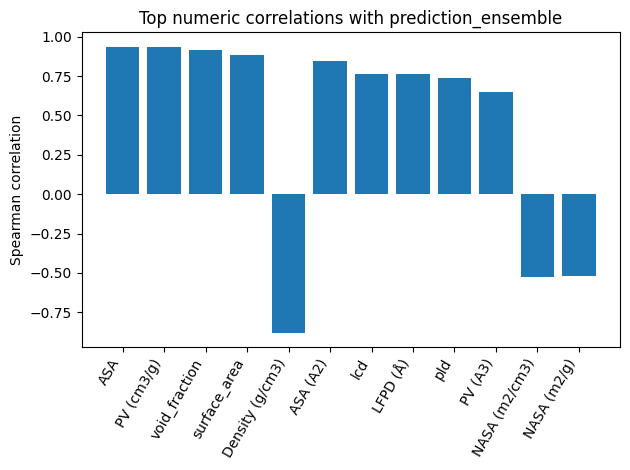

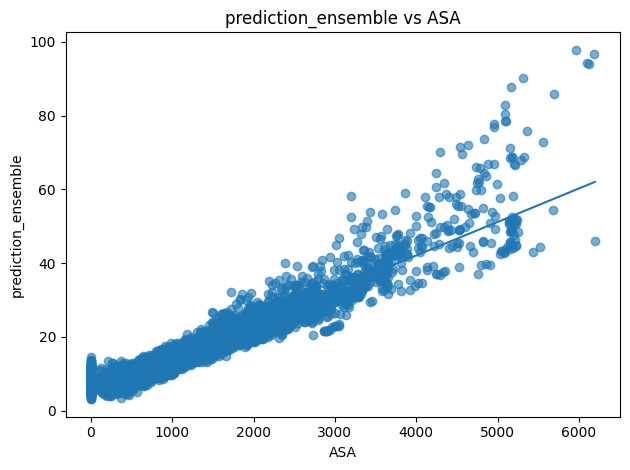

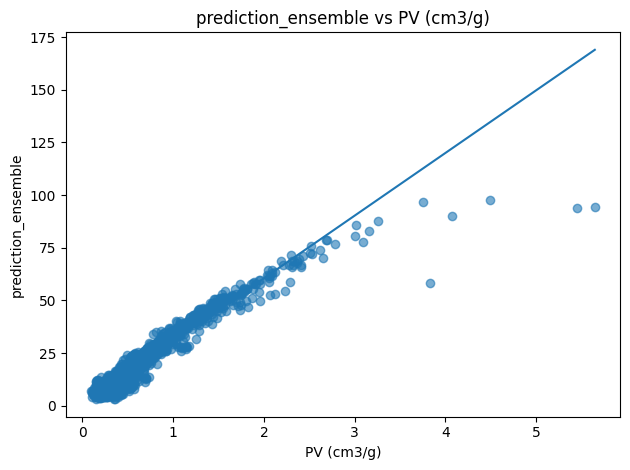

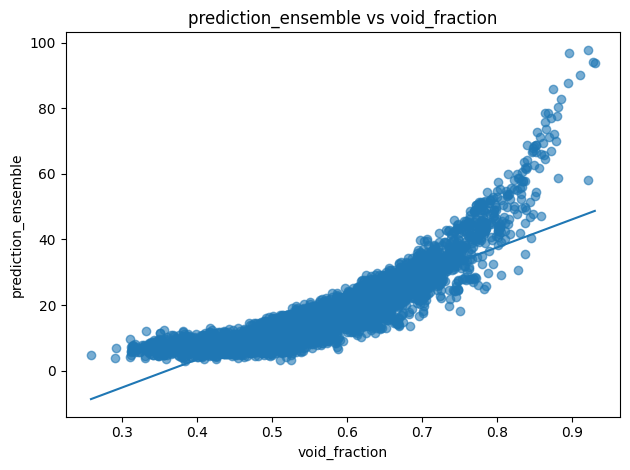

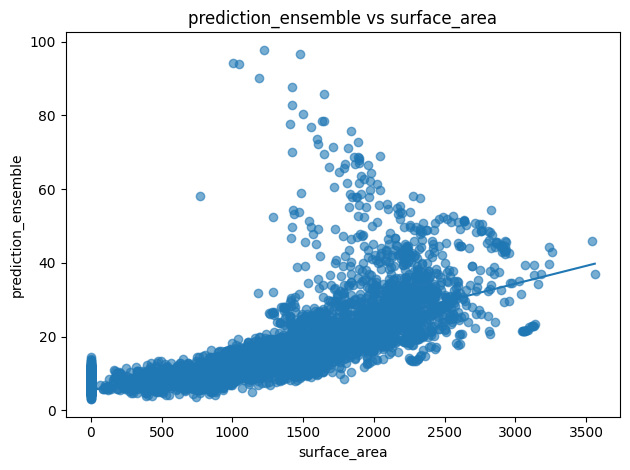

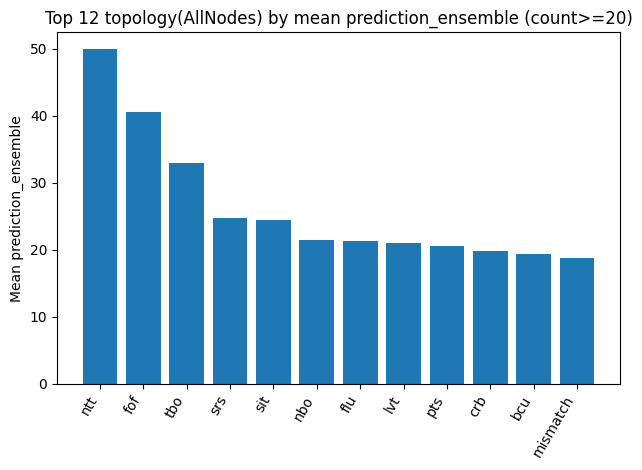

Report saved: data_core\cif\CSD-modified\cifs\CR\ensemble_model\zeta_interpretability_report.xlsx


In [51]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# ------------- Config -------------
CSV_IN = Path("data_core/cif/CSD-modified/cifs/CR/zeta_data/merged_with_lattice_renamed_zeta_pred.csv")
TARGET = "prediction_ensemble"
NUM_FEATURES = ["lcd","pld","LFPD (Å)","Density (g/cm3)","ASA (A2)","surface_area","ASA","NASA (A2)","NASA (m2/cm3)","NASA (m2/g)","PV (A3)","void_fraction","PV (cm3/g)"]
CAT_CANDIDATES = ["structure_dimension","topology(AllNodes)","topology(SingleNodes)","topology(AllNodes)-zeo","topology(SingleNodes)-zeo","dimension_by_topo","catenation","Metal Types","KH_Classes","hall","number_spacegroup"]
OUT_XLSX = Path("data_core/cif/CSD-modified/cifs/CR/ensemble_model/zeta_interpretability_report.xlsx")

# ------------- Load -------------
df = pd.read_csv(CSV_IN)

cat_cols = [c for c in CAT_CANDIDATES if c in df.columns]

for c in [TARGET] + NUM_FEATURES:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.loc[~df[TARGET].isna()].copy()

# ------------- Numeric correlations -------------
available_num = [c for c in NUM_FEATURES if c in df.columns]
rows=[]
for c in available_num:
    s = df[[TARGET, c]].dropna()
    if len(s) >= 5:
        rows.append((c, s[TARGET].corr(s[c], method="spearman"), s[TARGET].corr(s[c], method="pearson"), len(s)))
num_cor = pd.DataFrame(rows, columns=["feature","spearman","pearson","n"]).sort_values("spearman", key=lambda s: s.abs(), ascending=False)


# ------------- Plots: top correlations -------------
top_k = num_cor.head(12)
plt.figure()
plt.bar(top_k["feature"], top_k["spearman"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("Spearman correlation")
plt.title("Top numeric correlations with prediction_ensemble")
plt.tight_layout()
plt.show()

for c in top_k["feature"][:4]:
    s = df[[TARGET, c]].dropna()
    if len(s) < 5:
        continue
    plt.figure()
    plt.scatter(s[c], s[TARGET], alpha=0.6)
    try:
        z = np.polyfit(s[c], s[TARGET], 1)
        xs = np.linspace(s[c].min(), s[c].max(), 100)
        plt.plot(xs, np.polyval(z, xs))
    except Exception:
        pass
    plt.xlabel(c); plt.ylabel(TARGET); plt.title(f"{TARGET} vs {c}")
    plt.tight_layout(); plt.show()

# ------------- Categorical / topology analysis -------------
cat_tables = {}
for c in cat_cols:
    g = df.groupby(c, dropna=False)[TARGET].agg(["count","mean","median","std"]).sort_values("mean", ascending=False)
    cat_tables[c] = g

stack = []
for c, g in cat_tables.items():
    tmp = g.copy(); tmp.insert(0, "category", c); tmp.insert(1, "level", tmp.index.astype(str)); stack.append(tmp.reset_index(drop=True))
if stack:
     
    cat_export_df = pd.concat(stack, ignore_index=True)



topo_col = next((c for c in ["topology(AllNodes)","topology(AllNodes)-zeo","topology(SingleNodes)","topology(SingleNodes)-zeo","structure_dimension"] if c in df.columns), None)
if topo_col:
    g = df.groupby(topo_col)[TARGET].agg(["count","mean"]).sort_values("mean", ascending=False)
    g = g[g["count"] >= 20].head(12)
    if not g.empty:
        plt.figure()
        plt.bar(g.index.astype(str), g["mean"])
        plt.xticks(rotation=60, ha="right")
        plt.ylabel("Mean prediction_ensemble")
        plt.title(f"Top {len(g)} {topo_col} by mean prediction_ensemble (count>=20)")
        plt.tight_layout()
        plt.show()

# ------------- Export report -------------
with pd.ExcelWriter(OUT_XLSX) as xw:
    num_cor.to_excel(xw, sheet_name="numeric_cor", index=False)
    for c, g in cat_tables.items():
        g.to_excel(xw, sheet_name=c[:28])



print("Report saved:", OUT_XLSX)


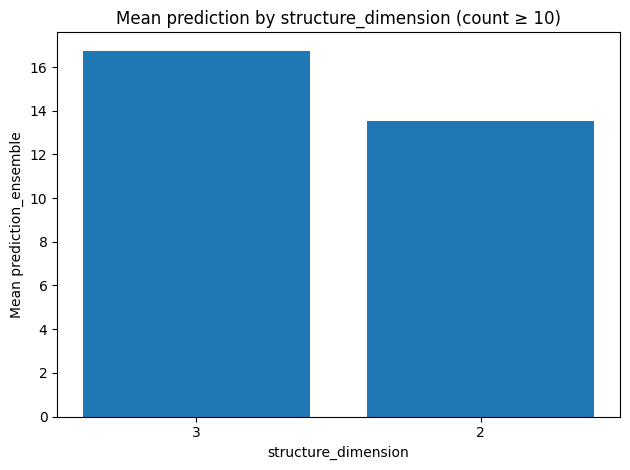

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21564\1747510058.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(l) for l in top_levels], showfliers=False)


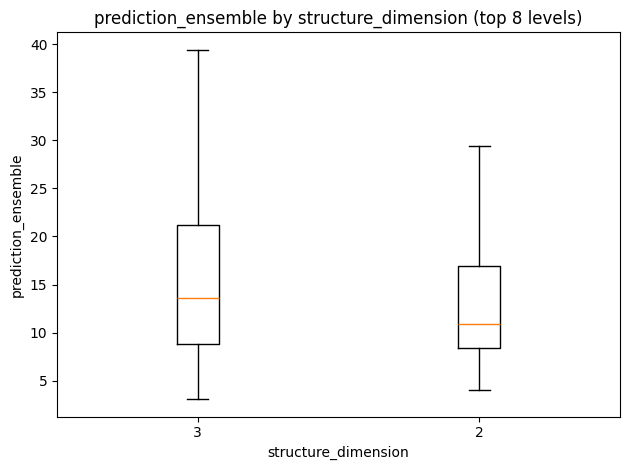

In [52]:
TARGET = "prediction_ensemble"
COL = "structure_dimension"
MIN_COUNT = 10

df = pd.read_csv(CSV_IN, low_memory=False)
df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce")
df = df.loc[~df[TARGET].isna()].copy()

if COL not in df.columns:
    raise KeyError(f"Column not found: {COL}")

g = df.groupby(COL, dropna=False)[TARGET].agg(["count", "mean", "median", "std"]).sort_values("mean", ascending=False)


g_plot = g[g["count"] >= MIN_COUNT]
if not g_plot.empty:
    plt.figure()
    plt.bar(g_plot.index.astype(str), g_plot["mean"])
    plt.xticks(rotation=0)
    plt.xlabel("structure_dimension")
    plt.ylabel("Mean prediction_ensemble")
    plt.title(f"Mean prediction by structure_dimension (count ≥ {MIN_COUNT})")
    plt.tight_layout()
    plt.show()

# boxplot for top 8 most frequent levels
top_levels = df[COL].value_counts(dropna=False).head(8).index.tolist()
groups = [df.loc[df[COL]==lvl, TARGET].dropna().values for lvl in top_levels]
if len(groups) >= 2:
    plt.figure()
    plt.boxplot(groups, labels=[str(l) for l in top_levels], showfliers=False)
    plt.xlabel("structure_dimension")
    plt.ylabel("prediction_ensemble")
    plt.title("prediction_ensemble by structure_dimension (top 8 levels)")
    plt.tight_layout()
    plt.show()

Ridge  R^2=0.978  MAE=1.2060  (n_test=1118)
RF     R^2=0.982  MAE=1.0125  (n_test=1118)


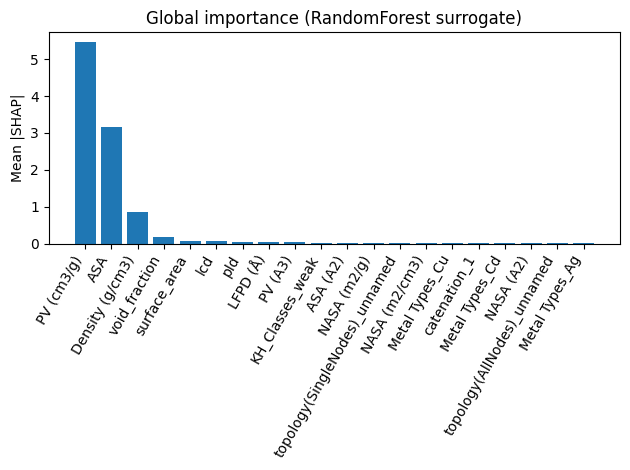

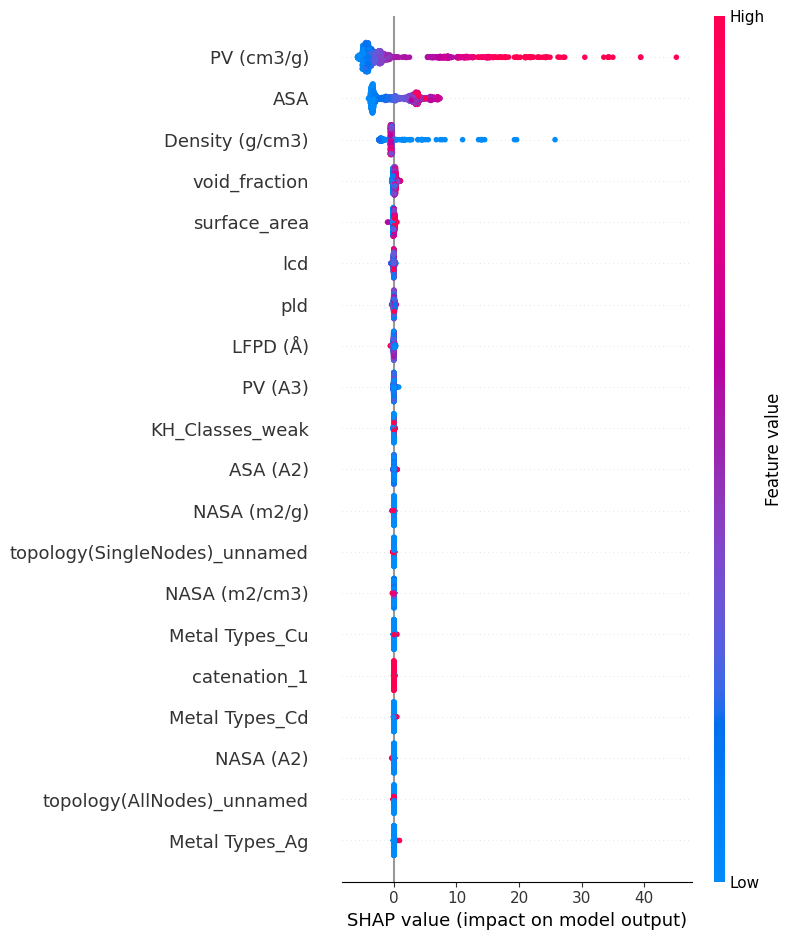

<Figure size 640x480 with 0 Axes>

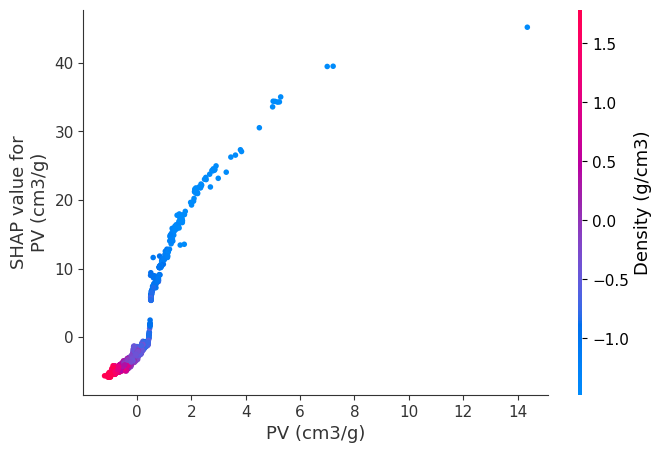

<Figure size 640x480 with 0 Axes>

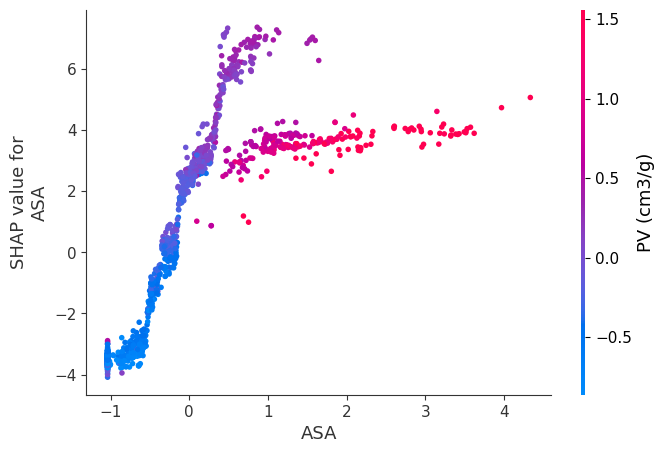

<Figure size 640x480 with 0 Axes>

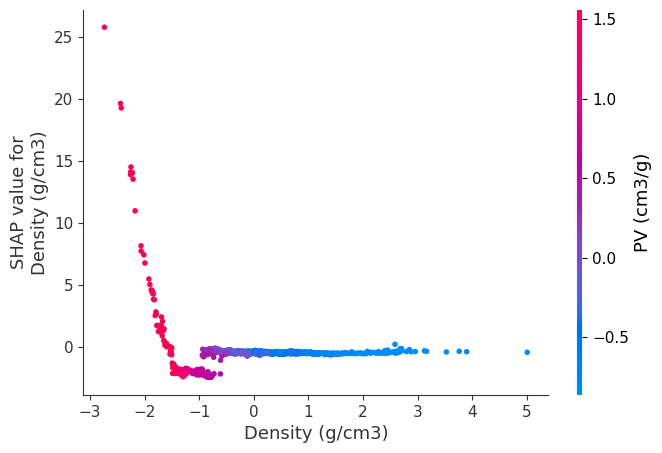

<Figure size 640x480 with 0 Axes>

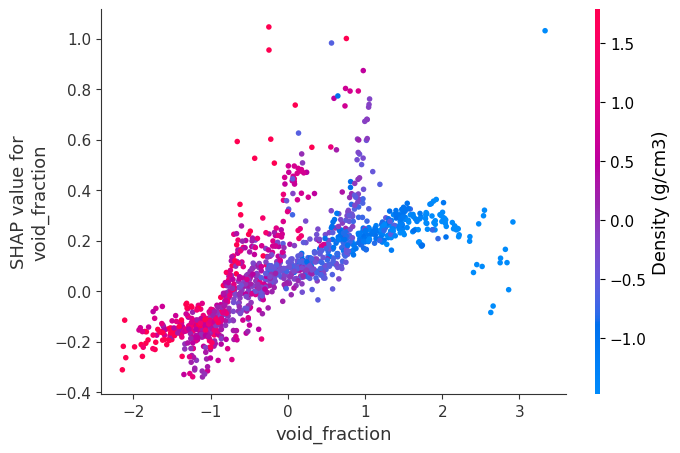

<Figure size 640x480 with 0 Axes>

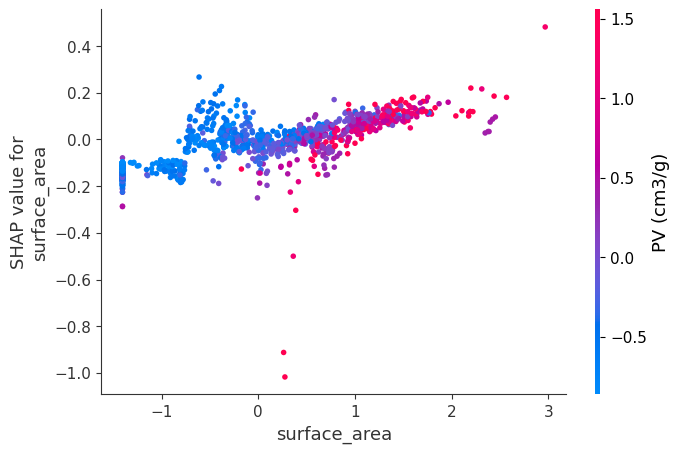

<Figure size 640x480 with 0 Axes>

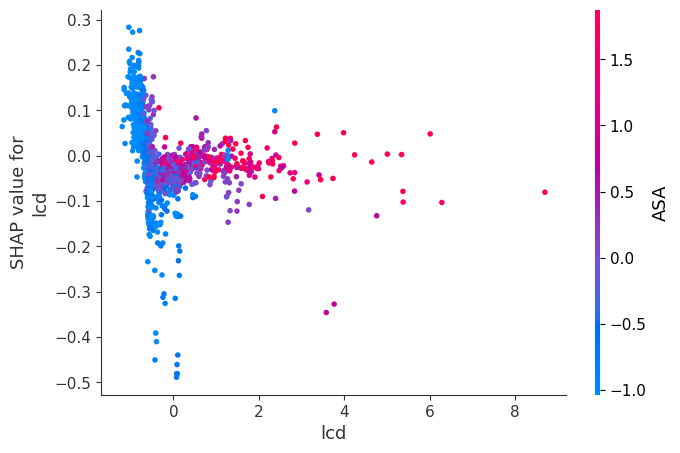

D:\pycharm\py_project\CGCNN2_data_science_project\.venv\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


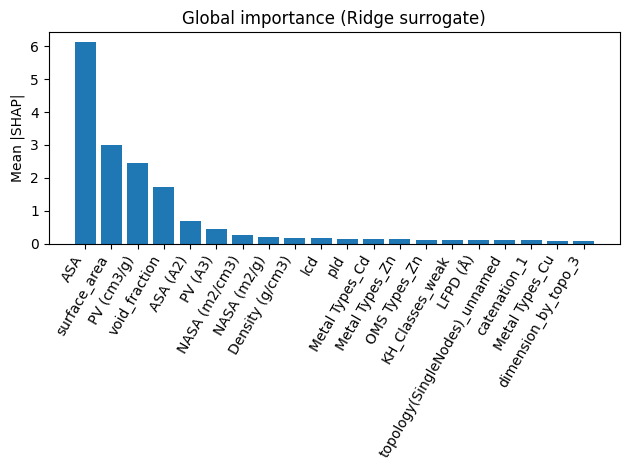

Kruskal–Wallis over topology(AllNodes) (n_levels=35): H=808.739, p=6.165e-148
Artifacts in: data_core\cif\CSD-modified\cifs\CR\zeta_shap_outputs
 - SHAP RF: data_core\cif\CSD-modified\cifs\CR\zeta_shap_outputs\shap_summary_rf.csv
 - SHAP Ridge: data_core\cif\CSD-modified\cifs\CR\zeta_shap_outputs\shap_summary_ridge.csv
 - Topology×Metal tables (xlsx): data_core\cif\CSD-modified\cifs\CR\zeta_shap_outputs\topology_metal_tables.xlsx


In [53]:

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

from scipy.stats import kruskal, mannwhitneyu
from itertools import combinations


# ---------------- Config ----------------
TARGET = "prediction_ensemble"

NUM_FEATURES = [
    "lcd","pld","LFPD (Å)","Density (g/cm3)",
    "ASA (A2)","surface_area","ASA",
    "NASA (A2)","NASA (m2/cm3)","NASA (m2/g)",
    "PV (A3)","void_fraction","PV (cm3/g)",
]

CAT_FEATURES_CAND = [
    "topology(AllNodes)","topology(SingleNodes)","topology(AllNodes)-zeo","topology(SingleNodes)-zeo",
    "structure_dimension","dimension_by_topo","catenation","Metal Types","Has OMS","OMS Types","KH_Classes"
]

TOPO_COL_PRIORITIES = ["topology(AllNodes)","topology(AllNodes)-zeo","topology(SingleNodes)","topology(SingleNodes)-zeo"]
METAL_COL = "Metal Types"

OUT_DIR = Path("data_core/cif/CSD-modified/cifs/CR/zeta_shap_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

SHAP_SAMPLE_N = 1200
OHE_MIN_FREQ = 20
RANDOM_STATE = 42

# ---------------- Load ----------------
df = pd.read_csv(CSV_IN, low_memory=False)

num_cols = [c for c in NUM_FEATURES if c in df.columns]
cat_cols = [c for c in CAT_FEATURES_CAND if c in df.columns]

for c in num_cols + [TARGET]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.loc[~df[TARGET].isna()].copy()

if len(df) > 6000:
    df = df.sample(n=6000, random_state=RANDOM_STATE).reset_index(drop=True)

# ---------------- Preprocess ----------------
num_pipe = Pipeline([("impute", SimpleImputer(strategy="median")), ("scale", StandardScaler())])

# Compatibility with older sklearn: use 'sparse' only
ohe = OneHotEncoder(handle_unknown="ignore", min_frequency=OHE_MIN_FREQ)
cat_pipe = Pipeline([("impute", SimpleImputer(strategy="most_frequent")), ("onehot", ohe)])

pre = ColumnTransformer([("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)], sparse_threshold=0.0)

# ---------------- Train two surrogates ----------------
X = df[num_cols + cat_cols]
y = df[TARGET].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

ridge = Ridge(alpha=1.0, random_state=RANDOM_STATE)
rf = RandomForestRegressor(n_estimators=240, random_state=RANDOM_STATE, n_jobs=-1)

pipe_ridge = Pipeline([("pre", pre), ("model", ridge)])
pipe_rf = Pipeline([("pre", pre), ("model", rf)])

pipe_ridge.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

ypr_ridge = pipe_ridge.predict(X_test)
ypr_rf = pipe_rf.predict(X_test)

r2_ridge = r2_score(y_test, ypr_ridge); mae_ridge = mean_absolute_error(y_test, ypr_ridge)
r2_rf = r2_score(y_test, ypr_rf); mae_rf = mean_absolute_error(y_test, ypr_rf)

print(f"Ridge  R^2={r2_ridge:.3f}  MAE={mae_ridge:.4f}  (n_test={len(y_test)})")
print(f"RF     R^2={r2_rf:.3f}  MAE={mae_rf:.4f}  (n_test={len(y_test)})")

# ---------------- Prepare feature matrix & names ----------------
pre_fitted = pipe_rf.named_steps["pre"]
Xt_all = pre_fitted.transform(X)
if hasattr(Xt_all, "toarray"):
    try:
        Xt_all = Xt_all.toarray()
    except Exception:
        pass

feat_names = []
if num_cols: feat_names.extend(num_cols)
if cat_cols:
    ohe_fitted = pre_fitted.named_transformers_["cat"].named_steps["onehot"]
    feat_names.extend(list(ohe_fitted.get_feature_names_out(cat_cols)))

# ---------------- SHAP: RF (TreeExplainer) ----------------
import shap
n = min(SHAP_SAMPLE_N, Xt_all.shape[0])
idx = np.random.RandomState(RANDOM_STATE).choice(Xt_all.shape[0], size=n, replace=False)

expl_rf = shap.TreeExplainer(pipe_rf.named_steps["model"])
shap_rf = expl_rf.shap_values(Xt_all[idx])
rf_abs_mean = np.abs(shap_rf).mean(axis=0)
rf_summary = pd.DataFrame({"feature": feat_names, "mean_abs_shap": rf_abs_mean}).sort_values("mean_abs_shap", ascending=False)
rf_summary.to_csv(OUT_DIR / "shap_summary_rf.csv", index=False)


plt.figure(); plt.bar(rf_summary.head(20)["feature"], rf_summary.head(20)["mean_abs_shap"]); plt.xticks(rotation=60, ha="right"); plt.ylabel("Mean |SHAP|"); plt.title("Global importance (RandomForest surrogate)"); plt.tight_layout(); plt.show()
shap.summary_plot(shap_rf, features=Xt_all[idx], feature_names=feat_names, max_display=20, show=True)

# Dependence plots for top numeric base features
top_num = [f for f in rf_summary.head(20)["feature"].tolist() if f in num_cols][:6]
for f in top_num:
    j = feat_names.index(f)
    plt.figure()
    shap.dependence_plot(ind=j, shap_values=shap_rf, features=Xt_all[idx], feature_names=feat_names, show=True)

# ---------------- SHAP: Ridge ----------------
Xt_all_ridge = pre_fitted.transform(X)
if hasattr(Xt_all_ridge, "toarray"):
    try:
        Xt_all_ridge = Xt_all_ridge.toarray()
    except Exception:
        pass

expl_ridge = shap.LinearExplainer(pipe_ridge.named_steps["model"], Xt_all_ridge, feature_perturbation="interventional")
n2 = min(SHAP_SAMPLE_N, Xt_all_ridge.shape[0])
idx2 = np.random.RandomState(RANDOM_STATE).choice(Xt_all_ridge.shape[0], size=n2, replace=False)
shap_ridge = expl_ridge.shap_values(Xt_all_ridge[idx2])
ridge_abs_mean = np.abs(shap_ridge).mean(axis=0)
ridge_summary = pd.DataFrame({"feature": feat_names, "mean_abs_shap": ridge_abs_mean}).sort_values("mean_abs_shap", ascending=False)
ridge_summary.to_csv(OUT_DIR / "shap_summary_ridge.csv", index=False)


plt.figure(); plt.bar(ridge_summary.head(20)["feature"], ridge_summary.head(20)["mean_abs_shap"]); plt.xticks(rotation=60, ha="right"); plt.ylabel("Mean |SHAP|"); plt.title("Global importance (Ridge surrogate)"); plt.tight_layout(); plt.show()

# ---------------- Topology × Metal Types ----------------
topo_col = next((c for c in TOPO_COL_PRIORITIES if c in df.columns), None)
if topo_col is None and "structure_dimension" in df.columns:
    topo_col = "structure_dimension"

if topo_col is not None and METAL_COL in df.columns:
    pivot_mean = pd.pivot_table(df, index=topo_col, columns=METAL_COL, values=TARGET, aggfunc="mean")
    pivot_cnt = pd.pivot_table(df, index=topo_col, columns=METAL_COL, values=TARGET, aggfunc="count")
    

    # # Heatmap-like images (no color specified)
    # plt.figure()
    # plt.imshow(pivot_mean.fillna(np.nan).to_numpy(), aspect="auto")
    # plt.xticks(ticks=np.arange(pivot_mean.shape[1]), labels=pivot_mean.columns.astype(str), rotation=60, ha="right")
    # plt.yticks(ticks=np.arange(pivot_mean.shape[0]), labels=pivot_mean.index.astype(str))
    # plt.title("Mean prediction_ensemble (Topology × Metal)")
    # plt.tight_layout()
    # plt.show()
    # 
    # plt.figure()
    # plt.imshow(pivot_cnt.fillna(0).to_numpy(), aspect="auto")
    # plt.xticks(ticks=np.arange(pivot_cnt.shape[1]), labels=pivot_cnt.columns.astype(str), rotation=60, ha="right")
    # plt.yticks(ticks=np.arange(pivot_cnt.shape[0]), labels=pivot_cnt.index.astype(str))
    # plt.title("Sample count (Topology × Metal)")
    # plt.tight_layout()
    # plt.show()

    with pd.ExcelWriter(OUT_DIR / "topology_metal_tables.xlsx") as xw:
        pivot_mean.to_excel(xw, sheet_name="mean_pred")
        pivot_cnt.to_excel(xw, sheet_name="count")

# ---------------- Kruskal–Wallis + pairwise (Holm) ----------------
if topo_col is not None:
    counts = df[topo_col].value_counts()
    keep_levels = counts[counts >= 20].index.tolist()
    groups = [df.loc[df[topo_col]==lvl, TARGET].dropna().values for lvl in keep_levels]

    if len(groups) >= 2:
        H, p_kw = kruskal(*groups)
        print(f"Kruskal–Wallis over {topo_col} (n_levels={len(groups)}): H={H:.3f}, p={p_kw:.3e}")

        results = []
        for a, b in combinations(keep_levels, 2):
            x = df.loc[df[topo_col]==a, TARGET].dropna().values
            y = df.loc[df[topo_col]==b, TARGET].dropna().values
            if len(x) >= 5 and len(y) >= 5:
                stat, p = mannwhitneyu(x, y, alternative="two-sided")
                results.append((a, b, stat, p, len(x), len(y)))
        pw = pd.DataFrame(results, columns=["group_a","group_b","U","p_raw","n_a","n_b"]).sort_values("p_raw")

        m = len(pw)
        holm = []
        for i, (_, row) in enumerate(pw.iterrows(), start=1):
            holm.append(min((m - i + 1) * row["p_raw"], 1.0))
        pw["p_holm"] = holm
        
        pw.to_csv(OUT_DIR / "pairwise_topology_tests.csv", index=False)

print("Artifacts in:", OUT_DIR)
print(" - SHAP RF:", OUT_DIR / "shap_summary_rf.csv")
print(" - SHAP Ridge:", OUT_DIR / "shap_summary_ridge.csv")
print(" - Topology×Metal tables (xlsx):", OUT_DIR / "topology_metal_tables.xlsx")


In [54]:
# ---- Paths ----
INPUT = Path("data_core/cif/CSD-modified/cifs/CR/zeta_data/merged_with_lattice_renamed_zeta_pred.csv")
# 可改；若想原地覆盖，把 OUTPUT 改成 INPUT
OUTPUT = Path("data_core/cif/CSD-modified/cifs/CR/zeta_data/merged_with_lattice_renamed_zeta_pred_reverse_name.csv")

# ---- Mapping (old -> new) ----
# 仅当源列存在且目标列不存在时才会改名（避免覆盖已有标准列）
MAPPING = {
    "lcd": "LCD (Å)",
    "pld": "PLD (Å)",
    "surface_area": "ASA (m2/cm3)",
    "ASA": "ASA (m2/g)",
    "void_fraction": "VF",
}

def main() -> None:
    if not INPUT.exists():
        raise FileNotFoundError(f"Input not found: {INPUT}")

    df = pd.read_csv(INPUT, low_memory=False)
    before_cols = set(df.columns)

    # 安全重命名：避免覆盖已存在的目标列
    rename_plan = {}
    skipped = []
    for src, dst in MAPPING.items():
        if src in df.columns:
            if dst not in df.columns:
                rename_plan[src] = dst
            else:
                # 目标已存在，跳过以防覆盖
                skipped.append((src, dst, "target-exists"))
        else:
            skipped.append((src, dst, "source-missing"))

    df = df.rename(columns=rename_plan)

    df.to_csv(OUTPUT, index=False)

    # 报告
    print("=== Rename summary ===")
    if rename_plan:
        for s, d in rename_plan.items():
            print(f"  RENAMED: {s} -> {d}")
    else:
        print("  No columns renamed.")

    if skipped:
        print("=== Skipped (reason) ===")
        for s, d, why in skipped:
            print(f"  {s} -> {d}  [{why}]")

    after_cols = set(df.columns)
    added = sorted(list(after_cols - before_cols))
    removed = sorted(list(before_cols - after_cols))
    print("=== Diff ===")
    print("  Added columns:", added)
    print("  Removed columns:", removed)
    print(f"[DONE] Saved to: {OUTPUT}")

if __name__ == "__main__":
    main()

=== Rename summary ===
  RENAMED: lcd -> LCD (Å)
  RENAMED: pld -> PLD (Å)
  RENAMED: surface_area -> ASA (m2/cm3)
  RENAMED: ASA -> ASA (m2/g)
  RENAMED: void_fraction -> VF
=== Diff ===
  Added columns: ['ASA (m2/cm3)', 'ASA (m2/g)', 'LCD (Å)', 'PLD (Å)', 'VF']
  Removed columns: ['ASA', 'lcd', 'pld', 'surface_area', 'void_fraction']
[DONE] Saved to: data_core\cif\CSD-modified\cifs\CR\zeta_data\merged_with_lattice_renamed_zeta_pred_reverse_name.csv


In [85]:
# hts/asr_high_throughput_screening_fused.py
#!/usr/bin/env python3
"""
High-throughput screening on merged_with_lattice_renamed_zeta_pred.csv
- Fuse CGCNN prediction ('prediction') and ensemble prediction ('prediction_ensemble')
  into a single target 'prediction_fused' using rank-based late fusion.
- Apply adaptive threshold backoff (community-like constraints) to form a feasible pool.
- Score candidates (fused prediction + pore metrics, penalize density).
- Enforce diversity by topology/structure dimension; export shortlist and Pareto front.

Notes:
- Comments are in English per request.
- File paths: tries a user-relative path first, then falls back to /mnt/data.
"""

from __future__ import annotations
from pathlib import Path
from typing import Iterable, List, Optional, Tuple, Dict

import numpy as np
import pandas as pd


# ======================= Paths =======================
# Primary (project-relative) path:
INPUT_CSV = Path("data_core/cif/CSD-modified/cifs/CR/zeta_data/merged_with_lattice_renamed_zeta_pred_reverse_name.csv")


OUT_DIR = Path("data_core/cif/CSD-modified/cifs/CR/asr_hts_outputs_fused")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ======================= Columns =======================
PRED_COL_CGCNN = "prediction"
PRED_COL_ENSEMBLE = "prediction_ensemble"
# Final fused column (created by this script)
PRED_COL_FUSED = "prediction_fused"

NUM_FEATURES = [
    "LCD (Å)", "PLD (Å)", "LFPD (Å)", "Density (g/cm3)",
    "ASA (A2)", "ASA (m2/cm3)", "ASA (m2/g)",
    "NASA (A2)", "NASA (m2/cm3)", "NASA (m2/g)",
    "PV (A3)", "VF", "PV (cm3/g)",
    "NAV (A3)", "NAV_VF", "NPV (cm3/g)",
    "average_atomic_mass", "natoms",
]
CAT_FEATURES = [
    "topology(AllNodes)", "topology(SingleNodes)",
    "structure_dimension", "Metal Types", "Has OMS", "OMS Types",
    "Water_stability", "Solvent_stability"
]
ID_COLS_TRY = ["id", "refcode", "name", "mofid-v1", "mofid-v2"]

# =================== Initial thresholds (community-like) ===================
INIT = dict(
    PLD_MIN=3.4,
    LCD_MIN=6.0,
    VF_MIN=0.35,
    PVG_MIN=0.50,      # cm3/g
    ASA_MIN=600.0,     # m2/g
    DENSITY_MAX=1.00,  # g/cm3
)

# Relaxation bounds (scientifically reasonable)
BOUNDS = dict(
    PLD_MIN=3.0,
    LCD_MIN=5.0,
    VF_MIN=0.25,
    PVG_MIN=0.30,
    ASA_MIN=400.0,
    DENSITY_MAX=1.20,
)

# Step per round
STEPS = dict(
    PLD_MIN=-0.2,
    LCD_MIN=-0.5,
    VF_MIN=-0.03,
    PVG_MIN=-0.05,
    ASA_MIN=-50.0,
    DENSITY_MAX=+0.05,
)

MAX_RELAX_ROUNDS = 8
MIN_POOL = 150

# Stability gating (off by default)
USE_STABILITY = False
THERMAL_MIN_C = 250.0

# Scoring weights
# W_PRED uses fused prediction; W_PORE aggregates pore metrics; W_DENS penalizes density
W_PRED = 0.50
W_PORE = 0.40
W_DENS = 0.10

# Diversity & outputs
K_PER_TOPOLOGY = 8
USE_SECONDARY_METAL_DEDUP = True
TOP_N_GLOBAL = 500
TOP_N_SHORTLIST = 150
TOP_K_PER_TOPOLOGY_EXPORT = 20

# Fusion behavior
FUSION_METHOD = "rank"  # "rank" (default, robust) or "zscore"
FUSION_WEIGHTS = (50, 50)  # (w_cgcnn, w_ensemble), must sum to 1.0 ideally


# ======================= Helpers =======================
def _coerce_float(df: pd.DataFrame, cols: Iterable[str]) -> None:
    """Coerce columns to float; non-parsable values become NaN."""
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

def _first_existing_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    """Pick the first ID-like column that exists."""
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _rank01(s: pd.Series, ascending: bool) -> pd.Series:
    """Robust [0,1] fractional rank; handles ties; safe for NaN."""
    r = s.rank(method="average", ascending=ascending, na_option="keep")
    if r.notna().any():
        denom = (r.max() - r.min())
        if denom and denom != 0:
            return (r - r.min()) / denom
        else:
            return pd.Series(0.5, index=r.index)
    return r

def _zscore(s: pd.Series) -> pd.Series:
    """Z-score with NaN handling; constant series → 0."""
    mu = s.mean(skipna=True)
    sd = s.std(skipna=True)
    if pd.notna(sd) and sd > 0:
        return (s - mu) / sd
    return pd.Series(0.0, index=s.index)

def _apply_constraints(df: pd.DataFrame, thr: Dict[str, float], use_stability: bool = False) -> pd.Series:
    """Build boolean mask according to thresholds; optional stability gating."""
    def has(c: str) -> bool: return c in df.columns
    mask = pd.Series(True, index=df.index)

    if has("PLD (Å)"):            mask &= (df["PLD (Å)"] >= thr["PLD_MIN"])
    if has("LCD (Å)"):            mask &= (df["LCD (Å)"] >= thr["LCD_MIN"])
    if has("VF"):                 mask &= (df["VF"] >= thr["VF_MIN"])
    if has("PV (cm3/g)"):         mask &= (df["PV (cm3/g)"] >= thr["PVG_MIN"])
    if has("ASA (m2/g)"):         mask &= (df["ASA (m2/g)"] >= thr["ASA_MIN"])
    if has("Density (g/cm3)"):    mask &= (df["Density (g/cm3)"] <= thr["DENSITY_MAX"])

    if use_stability:
        if "Thermal_stability (℃)" in df.columns:
            mask &= (pd.to_numeric(df["Thermal_stability (℃)"], errors="coerce") >= THERMAL_MIN_C)
        if "Water_stability" in df.columns:
            mask &= df["Water_stability"].astype(str).str.lower().str.contains("stable", na=False)
        if "Solvent_stability" in df.columns:
            mask &= df["Solvent_stability"].astype(str).str.lower().str.contains("stable", na=False)

    return mask.fillna(False)

def _relax_once(thr: Dict[str, float]) -> Dict[str, float]:
    """One relaxation step with clamping to bounds."""
    new_thr = thr.copy()
    for k, step in STEPS.items():
        if k == "DENSITY_MAX":
            new_thr[k] = min(thr[k] + step, BOUNDS["DENSITY_MAX"])
        else:
            new_thr[k] = max(thr[k] + step, BOUNDS[k])
    return new_thr

def _quantile_fallback(df: pd.DataFrame, thr: Dict[str, float]) -> Dict[str, float]:
    """Fallback: use dataset quantiles (q10 for mins, q90 for max)."""
    out = thr.copy()

    def q(col: str, qv: float) -> Optional[float]:
        if col in df.columns and df[col].notna().any():
            return float(df[col].quantile(qv))
        return None

    for key, col in [("PLD_MIN", "PLD (Å)"), ("LCD_MIN", "LCD (Å)"),
                     ("VF_MIN", "VF"), ("PVG_MIN", "PV (cm3/g)"),
                     ("ASA_MIN", "ASA (m2/g)")]:
        v = q(col, 0.10)
        if v is not None:
            out[key] = max(min(out[key], v), BOUNDS[key])

    v90 = q("Density (g/cm3)", 0.90)
    if v90 is not None:
        out["DENSITY_MAX"] = min(max(out["DENSITY_MAX"], v90), BOUNDS["DENSITY_MAX"])
    return out

def _pareto_front(arr: np.ndarray, maximize: List[bool]) -> np.ndarray:
    """Return boolean mask of Pareto-efficient points (O(n^2))."""
    if arr.size == 0:
        return np.zeros((0,), dtype=bool)
    A = arr.copy()
    for j, is_max in enumerate(maximize):
        if is_max:
            A[:, j] = -A[:, j]
    n = A.shape[0]
    eff = np.ones(n, dtype=bool)
    for i in range(n):
        if not eff[i]:
            continue
        dominates = (A <= A[i]).all(axis=1) & (A < A[i]).any(axis=1)
        dominates[i] = False
        if dominates.any():
            eff[i] = False
    return eff

def _fuse_predictions(df: pd.DataFrame,
                      col_cgcnn: str,
                      col_ens: str,
                      method: str = "rank",
                      weights: Tuple[float, float] = (0.5, 0.5)) -> pd.Series:
    """
    Fuse two predictions into one:
    - 'rank': average of fractional ranks in [0,1], higher-is-better.
    - 'zscore': average of standardized z-scores.
    If one column is missing, returns the other; if both exist but one has NaN, fuses on available rows.
    """
    has_cg = col_cgcnn in df.columns
    has_en = col_ens in df.columns
    if not has_cg and not has_en:
        raise KeyError("Neither 'prediction' nor 'prediction_ensemble' found.")

    if method == "rank":
        if has_cg:
            r1 = _rank01(df[col_cgcnn], ascending=False)
        else:
            r1 = pd.Series(np.nan, index=df.index)
        if has_en:
            r2 = _rank01(df[col_ens], ascending=False)
        else:
            r2 = pd.Series(np.nan, index=df.index)
        w1, w2 = weights
        fused = (w1 * r1.fillna(r1.mean())) + (w2 * r2.fillna(r2.mean()))
        return fused
    elif method == "zscore":
        if has_cg:
            z1 = _zscore(df[col_cgcnn])
        else:
            z1 = pd.Series(np.nan, index=df.index)
        if has_en:
            z2 = _zscore(df[col_ens])
        else:
            z2 = pd.Series(np.nan, index=df.index)
        w1, w2 = weights
        fused = (w1 * z1.fillna(0.0)) + (w2 * z2.fillna(0.0))
        # Map to 0..1 via rank for comparability with rank-based scoring down the line
        return _rank01(fused, ascending=False)
    else:
        raise ValueError("FUSION_METHOD must be 'rank' or 'zscore'.")


# ======================= Load data =======================
csv_path = INPUT_CSV 
df = pd.read_csv(csv_path)

id_col = _first_existing_col(df, ID_COLS_TRY) or "row_id"
if id_col not in df.columns:
    df[id_col] = np.arange(len(df))

# Numeric coercion
num_cols = [c for c in NUM_FEATURES if c in df.columns]
extra_num = ["Thermal_stability (℃)"] if "Thermal_stability (℃)" in df.columns else []
_coerce_float(df, [PRED_COL_CGCNN, PRED_COL_ENSEMBLE] + num_cols + extra_num)

# Keep rows with at least one prediction available
df = df.loc[df[[c for c in [PRED_COL_CGCNN, PRED_COL_ENSEMBLE] if c in df.columns]].notna().any(axis=1)].copy()

# ======================= Fuse predictions =======================
df[PRED_COL_FUSED] = _fuse_predictions(
    df, PRED_COL_CGCNN, PRED_COL_ENSEMBLE, method=FUSION_METHOD, weights=FUSION_WEIGHTS
)

# For downstream, we treat fused prediction as the target to screen on
PRED_TARGET = PRED_COL_FUSED

# ======================= Adaptive thresholds =======================
thr = INIT.copy()
mask = _apply_constraints(df, thr, use_stability=USE_STABILITY)
round_idx = 0

while (not mask.any()) and round_idx < MAX_RELAX_ROUNDS:
    round_idx += 1
    thr = _relax_once(thr)
    mask = _apply_constraints(df, thr, use_stability=USE_STABILITY)

if not mask.any():
    thr = _quantile_fallback(df, thr)
    mask = _apply_constraints(df, thr, use_stability=USE_STABILITY)

if not mask.any():
    # Final soft fallback
    thr_soft = dict(
        PLD_MIN=max(BOUNDS["PLD_MIN"], 3.0),
        LCD_MIN=BOUNDS["LCD_MIN"],
        VF_MIN=BOUNDS["VF_MIN"],
        PVG_MIN=BOUNDS["PVG_MIN"],
        ASA_MIN=BOUNDS["ASA_MIN"],
        DENSITY_MAX=BOUNDS["DENSITY_MAX"],
    )
    thr = thr_soft
    mask = _apply_constraints(df, thr, use_stability=False)

# If pool still small, relax density ceiling within bound to reach MIN_POOL (if possible)
if "Density (g/cm3)" in df.columns and mask.any():
    while mask.sum() < MIN_POOL and thr["DENSITY_MAX"] < BOUNDS["DENSITY_MAX"]:
        thr["DENSITY_MAX"] = min(thr["DENSITY_MAX"] + 0.05, BOUNDS["DENSITY_MAX"])
        mask = _apply_constraints(df, thr, use_stability=USE_STABILITY)

# ======================= Scoring (BEFORE pool) =======================
# Positive contributors: fused prediction + pore metrics
pos_feats = [c for c in ["PV (cm3/g)", "VF", "ASA (m2/g)"] if c in df.columns]
# Negative contributors: density
neg_feats = [c for c in ["Density (g/cm3)"] if c in df.columns]

pred_rank = _rank01(df[PRED_TARGET], ascending=False)

if pos_feats:
    pore_terms = [_rank01(df[c], ascending=False) for c in pos_feats]
    pore_stack = np.vstack([t.fillna(t.mean()) for t in pore_terms])
    pore_rank = pd.Series(np.nanmean(pore_stack, axis=0), index=df.index)
else:
    pore_rank = pd.Series(0.0, index=df.index)

if neg_feats:
    dens_rank = _rank01(df[neg_feats[0]], ascending=True)  # lower density is better
else:
    dens_rank = pd.Series(0.0, index=df.index)

df["score"] = (W_PRED * pred_rank.fillna(pred_rank.mean())) \
            + (W_PORE * pore_rank.fillna(pore_rank.mean())) \
            + (W_DENS * (1 - dens_rank.fillna(dens_rank.mean())))

# ======================= Now build pool WITH score =======================
if not mask.any():
    raise RuntimeError("Adaptive relaxation still resulted in empty pool. Please inspect data or relax bounds further.")
pool = df.loc[mask].copy().sort_values("score", ascending=False)

# ======================= Exports: global & pool =======================
(df.sort_values("score", ascending=False)
   .to_csv(OUT_DIR / "full_scored_with_flags.csv", index=False))
df_global = df.sort_values("score", ascending=False).head(TOP_N_GLOBAL).copy()
df_global.to_csv(OUT_DIR / "global_topN_scored.csv", index=False)
pool.to_csv(OUT_DIR / "pool_pass_constraints.csv", index=False)

# ======================= Diversity shortlist =======================
topo_col = "topology(AllNodes)" if "topology(AllNodes)" in pool.columns else None
strata_col = topo_col or ("structure_dimension" if "structure_dimension" in pool.columns else None)

shortlist_rows: List[pd.DataFrame] = []
if strata_col:
    for k, g in pool.groupby(strata_col, dropna=False):
        g_sorted = g.sort_values("score", ascending=False)
        if USE_SECONDARY_METAL_DEDUP and "Metal Types" in g_sorted.columns:
            seen: set = set()
            picked = []
            for _, row in g_sorted.iterrows():
                m = str(row["Metal Types"])
                if m not in seen:
                    picked.append(row)
                    seen.add(m)
                if len(picked) >= K_PER_TOPOLOGY:
                    break
            sub = pd.DataFrame(picked)
        else:
            sub = g_sorted.head(K_PER_TOPOLOGY)
        shortlist_rows.append(sub)
    shortlist = pd.concat(shortlist_rows, ignore_index=True)
else:
    shortlist = pool.head(TOP_N_SHORTLIST).copy()

shortlist = shortlist.sort_values("score", ascending=False).head(TOP_N_SHORTLIST).copy()
shortlist.to_csv(OUT_DIR / "shortlist_diverse.csv", index=False)

# ======================= Pareto front (on pool) =======================
objs = []
maximize = []
if PRED_TARGET in pool.columns:   objs.append(pool[PRED_TARGET].to_numpy(float));   maximize.append(True)
if "PV (cm3/g)" in pool.columns:  objs.append(pool["PV (cm3/g)"].to_numpy(float));  maximize.append(True)
if "VF" in pool.columns:          objs.append(pool["VF"].to_numpy(float));          maximize.append(True)
if "ASA (m2/g)" in pool.columns:  objs.append(pool["ASA (m2/g)"].to_numpy(float));  maximize.append(True)
if "Density (g/cm3)" in pool.columns:
    objs.append(pool["Density (g/cm3)"].to_numpy(float));                            maximize.append(False)

if objs:
    M = np.vstack(objs).T
    def _pareto_front_local(A: np.ndarray, maximize: List[bool]) -> np.ndarray:
        B = A.copy()
        for j, is_max in enumerate(maximize):
            if is_max: B[:, j] = -B[:, j]
        n = B.shape[0]
        eff = np.ones(n, dtype=bool)
        for i in range(n):
            if not eff[i]: continue
            dom = (B <= B[i]).all(axis=1) & (B < B[i]).any(axis=1)
            dom[i] = False
            if dom.any(): eff[i] = False
        return eff

    mask_p = _pareto_front_local(M, maximize=maximize)
    pareto = pool.loc[mask_p].copy().sort_values("score", ascending=False)
    pareto.to_csv(OUT_DIR / "pareto_front.csv", index=False)

# ======================= Log =======================
print("[THRESHOLDS USED] "
      f"PLD≥{thr['PLD_MIN']:.2f}Å, LCD≥{thr['LCD_MIN']:.2f}Å, VF≥{thr['VF_MIN']:.2f}, "
      f"PV≥{thr['PVG_MIN']:.2f} cm3/g, ASA≥{thr['ASA_MIN']:.0f} m2/g, ρ≤{thr['DENSITY_MAX']:.2f} g/cm3; "
      f"stability={'ON' if USE_STABILITY else 'OFF'}")
print(f"[FUSION] method={FUSION_METHOD}, weights={FUSION_WEIGHTS}; target={PRED_TARGET}")
print(f"[DONE] Total={len(df)} | Pool={len(pool)} | Shortlist={len(shortlist)}")
print(f"      Outputs → {OUT_DIR.resolve()}")
print("      Files:")
print("        - full_scored_with_flags.csv")
print("        - global_topN_scored.csv")
print("        - pool_pass_constraints.csv")
print("        - shortlist_diverse.csv")
print("        - pareto_front.csv (if any)")


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21564\173620581.py:260: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


[THRESHOLDS USED] PLD≥3.40Å, LCD≥6.00Å, VF≥0.35, PV≥0.50 cm3/g, ASA≥600 m2/g, ρ≤1.00 g/cm3; stability=OFF
[FUSION] method=rank, weights=(50, 50); target=prediction_fused
[DONE] Total=5590 | Pool=1221 | Shortlist=150
      Outputs → D:\pycharm\py_project\CGCNN2_data_science_project\data_core\cif\CSD-modified\cifs\CR\asr_hts_outputs_fused
      Files:
        - full_scored_with_flags.csv
        - global_topN_scored.csv
        - pool_pass_constraints.csv
        - shortlist_diverse.csv
        - pareto_front.csv (if any)


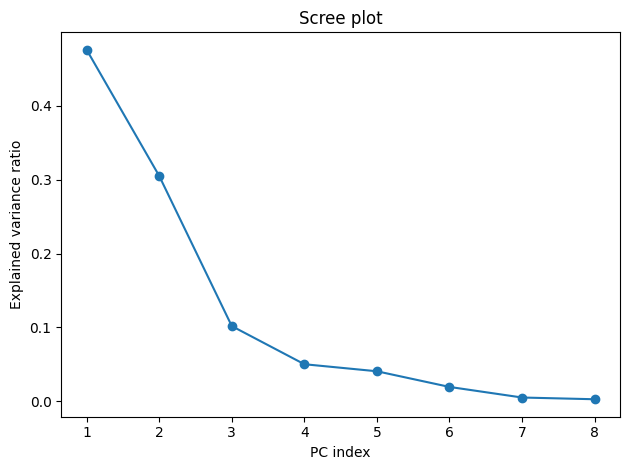

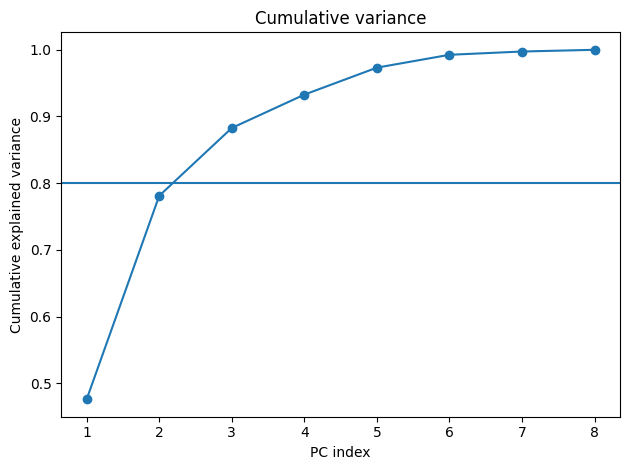

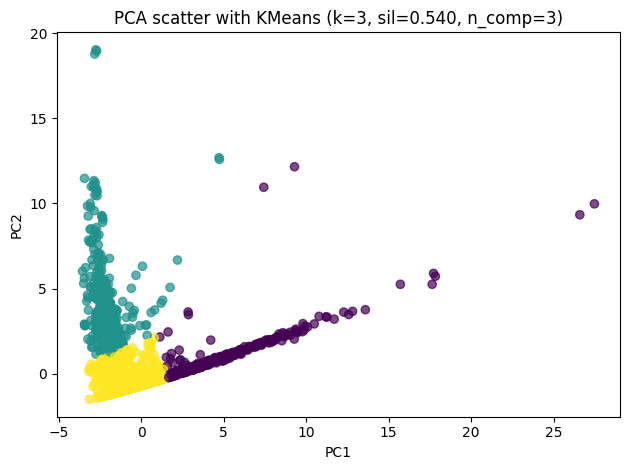

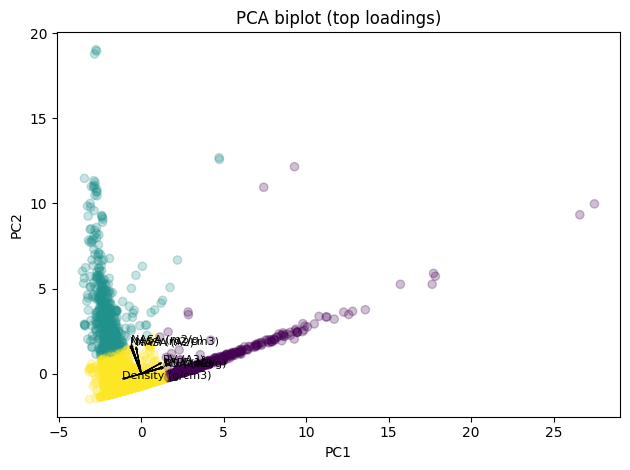

[OK] rows=5590, n_components=3, best_k=3, silhouette=0.540
Artifacts:
 - Assignments CSV : data_core\cif\CSD-modified\cifs\CR\asr_pca_kmeans_fused\ASR_pca_kmeans_fused_assignments.csv
 - Loadings CSV    : data_core\cif\CSD-modified\cifs\CR\asr_pca_kmeans_fused\ASR_pca_kmeans_fused_loadings.csv
 - Summary XLSX    : data_core\cif\CSD-modified\cifs\CR\asr_pca_kmeans_fused\ASR_pca_kmeans_fused_summary.xlsx
 - Figures         : data_core\cif\CSD-modified\cifs\CR\asr_pca_kmeans_fused


In [86]:
# analysis/pca_kmeans_prediction_fused.py
#!/usr/bin/env python3
"""
PCA + KMeans clustering around 'prediction_fused' for 5,590 materials.
- If 'prediction_fused' is missing, create it by rank-fusing 'prediction' and 'prediction_ensemble'.
- Numeric features use the (new) standardized names after your renaming.
- PCA components chosen by >=80% cumulative variance (cap 10; >=2).
- KMeans k selected by silhouette over k=2..10.
- If dataset has more than 5,590 rows: subsample to exactly 5,590 (reproducible).
- Outputs CSVs, XLSX summary, and figures (matplotlib; single-plot per figure; default colors).

All comments are in English per your requirement.
"""

from __future__ import annotations
from pathlib import Path
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# -------------------- Paths --------------------
# Project path first; fallback to /mnt/data if not found
INPUT1 = Path("data_core/cif/CSD-modified/cifs/CR/zeta_data/merged_with_lattice_renamed_zeta_pred.csv")

CSV_IN = INPUT1 

OUT_DIR = Path("data_core/cif/CSD-modified/cifs/CR/asr_pca_kmeans_fused")
OUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_PREFIX = OUT_DIR / "ASR_pca_kmeans_fused"  # *_assignments.csv, *_loadings.csv, *_summary.xlsx

# -------------------- Columns --------------------
TARGET = "prediction_fused"                # created if missing
CGCNN_COL = "prediction"
ENSEMBLE_COL = "prediction_ensemble"

# Numeric features (post-renaming). Only those present will be used.
NUM_FEATURES = [
    "LCD (Å)","PLD (Å)","LFPD (Å)","Density (g/cm3)",
    "ASA (A2)","ASA (m2/cm3)","ASA (m2/g)",
    "NASA (A2)","NASA (m2/cm3)","NASA (m2/g)",
    "PV (A3)","VF","PV (cm3/g)"
]

ID_CANDIDATES = ["id","refcode","name","mofid-v1","mofid-v2","row_id"]

# ----------------- PCA / KMeans config -----------------
MAX_COMPONENTS = 10
VAR_THRESHOLD = 0.80
K_MIN, K_MAX = 2, 10
N_TARGET = 5590
RANDOM_STATE = 42

# -------------------- Helpers --------------------
def rank01(s: pd.Series, ascending: bool) -> pd.Series:
    """Fractional rank in [0,1]."""
    r = s.rank(method="average", ascending=ascending, na_option="keep")
    if r.notna().any():
        denom = (r.max() - r.min())
        return (r - r.min()) / denom if denom and denom != 0 else pd.Series(0.5, index=r.index)
    return r

def ensure_prediction_fused(df: pd.DataFrame) -> pd.DataFrame:
    """Create 'prediction_fused' by rank-based late fusion if missing."""
    if TARGET in df.columns:
        return df
    if (CGCNN_COL not in df.columns) and (ENSEMBLE_COL not in df.columns):
        raise KeyError("Neither 'prediction_fused' nor source columns ('prediction', 'prediction_ensemble') exist.")
    s1 = rank01(pd.to_numeric(df[CGCNN_COL], errors="coerce") if CGCNN_COL in df.columns else pd.Series(np.nan, index=df.index), ascending=False)
    s2 = rank01(pd.to_numeric(df[ENSEMBLE_COL], errors="coerce") if ENSEMBLE_COL in df.columns else pd.Series(np.nan, index=df.index), ascending=False)
    w1, w2 = 0.5, 0.5
    fused = (w1 * s1.fillna(s1.mean())) + (w2 * s2.fillna(s2.mean()))
    df[TARGET] = fused
    return df

def pick_id_col(df: pd.DataFrame) -> str:
    for c in ID_CANDIDATES:
        if c in df.columns:
            return c
    df["row_id"] = np.arange(len(df))
    return "row_id"

# -------------------- Load --------------------
df = pd.read_csv(CSV_IN, low_memory=False)
df = ensure_prediction_fused(df)

# pick id
ID_COL = pick_id_col(df)

# retain available numeric columns
num_cols: List[str] = [c for c in NUM_FEATURES if c in df.columns]

# coerce numeric types
for c in num_cols + [TARGET]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# remove rows missing target or having all-nan numeric features
mask_valid = (~df[TARGET].isna()) & (df[num_cols].notna().any(axis=1))
df = df.loc[mask_valid].reset_index(drop=True)

# enforce 5,590 rows if possible
if len(df) > N_TARGET:
    df = df.sample(n=N_TARGET, random_state=RANDOM_STATE).reset_index(drop=True)

# -------------------- Impute & scale --------------------
X = df[num_cols].to_numpy()
imp = SimpleImputer(strategy="median")
X_imp = imp.fit_transform(X)

scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X_imp)

# ------------------------ PCA ------------------------
pca = PCA(n_components=min(MAX_COMPONENTS, X_scaled.shape[1]), random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

explained = pca.explained_variance_ratio_
cum = np.cumsum(explained)
n_opt = int(np.argmax(cum >= VAR_THRESHOLD) + 1) if (cum >= VAR_THRESHOLD).any() else min(3, X_pca.shape[1])
n_opt = max(2, n_opt)

X_p = X_pca[:, :n_opt]

# ------------------- KMeans selection -------------------
sil_scores = []
best_k = None
best_sil = -1.0
best_labels = None
best_model = None

upper_k = min(K_MAX, len(df) - 1)
for k in range(K_MIN, max(K_MIN, upper_k) + 1):
    km = KMeans(n_clusters=k, n_init=20, random_state=RANDOM_STATE)
    labels = km.fit_predict(X_p)
    if len(set(labels)) < 2:
        sil = -1.0
    else:
        sil = silhouette_score(X_p, labels)
    sil_scores.append((k, sil))
    if sil > best_sil:
        best_k, best_sil, best_labels, best_model = k, sil, labels, km

sil_df = pd.DataFrame(sil_scores, columns=["k","silhouette"]).sort_values("k")

# ------------------- Outputs: tables -------------------
assign = pd.DataFrame({
    ID_COL: df[ID_COL].values,
    "cluster": best_labels,
    "PC1": X_p[:, 0],
    "PC2": X_p[:, 1],
    TARGET: df[TARGET].values,
})
loadings = pd.DataFrame(
    pca.components_.T,
    index=num_cols,
    columns=[f"PC{i+1}" for i in range(pca.components_.shape[0])],
)

# cluster stats (count/mean/median/std on numeric features + target)
cluster_stats = (
    df[[ID_COL, TARGET] + num_cols]
    .merge(assign[[ID_COL, "cluster"]], on=ID_COL, how="left")
    .groupby("cluster")[[TARGET] + num_cols]
    .agg(["count","mean","median","std"])
)

# z-score means per cluster for numeric features
z = (df[num_cols] - df[num_cols].mean()) / df[num_cols].std(ddof=0)
z["cluster"] = best_labels
z_mean = z.groupby("cluster").mean().reset_index()

assign.to_csv(OUT_PREFIX.with_name(OUT_PREFIX.name + "_assignments.csv"), index=False)
loadings.to_csv(OUT_PREFIX.with_name(OUT_PREFIX.name + "_loadings.csv"))
with pd.ExcelWriter(OUT_PREFIX.with_name(OUT_PREFIX.name + "_summary.xlsx")) as xw:
    sil_df.to_excel(xw, sheet_name="k_silhouette", index=False)
    assign.to_excel(xw, sheet_name="assignments", index=False)
    cluster_stats.to_excel(xw, sheet_name="cluster_profile")
    z_mean.to_excel(xw, sheet_name="cluster_mean_z", index=False)

# ------------------------ Plots ------------------------
# scree
plt.figure()
plt.plot(np.arange(1, len(explained)+1), explained, marker="o")
plt.xlabel("PC index")
plt.ylabel("Explained variance ratio")
plt.title("Scree plot")
plt.tight_layout()
plt.savefig(OUT_DIR / "pca_scree.png", dpi=180)
plt.show()

# cumulative variance
plt.figure()
plt.plot(np.arange(1, len(cum)+1), cum, marker="o")
plt.axhline(VAR_THRESHOLD)
plt.xlabel("PC index")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative variance")
plt.tight_layout()
plt.savefig(OUT_DIR / "pca_cumulative.png", dpi=180)
plt.show()

# PCA scatter with clusters
plt.figure()
plt.scatter(X_p[:,0], X_p[:,1], c=best_labels, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA scatter with KMeans (k={best_k}, sil={best_sil:.3f}, n_comp={n_opt})")
plt.tight_layout()
plt.savefig(OUT_DIR / "pca_scatter_clusters.png", dpi=180)
plt.show()

# Biplot (top 10 features by max abs loading on PC1/PC2)
load2 = pca.components_.T[:, :2]
ldf = pd.DataFrame(load2, index=num_cols, columns=["PC1","PC2"])
top_feats = ldf.abs().max(axis=1).sort_values(ascending=False).head(10).index.tolist()

plt.figure()
plt.scatter(X_p[:,0], X_p[:,1], c=best_labels, alpha=0.25)
scale = 3.0  # adjust arrow length
for f in top_feats:
    x, y = ldf.loc[f, "PC1"]*scale, ldf.loc[f, "PC2"]*scale
    plt.arrow(0, 0, x, y, head_width=0.1, length_includes_head=True)
    plt.text(x*1.05, y*1.05, f, fontsize=8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA biplot (top loadings)")
plt.tight_layout()
plt.savefig(OUT_DIR / "pca_biplot_top10.png", dpi=180)
plt.show()

print(f"[OK] rows={len(df)}, n_components={n_opt}, best_k={best_k}, silhouette={best_sil:.3f}")
print("Artifacts:")
print(" - Assignments CSV :", OUT_PREFIX.with_name(OUT_PREFIX.name + '_assignments.csv'))
print(" - Loadings CSV    :", OUT_PREFIX.with_name(OUT_PREFIX.name + '_loadings.csv'))
print(" - Summary XLSX    :", OUT_PREFIX.with_name(OUT_PREFIX.name + '_summary.xlsx'))
print(" - Figures         :", OUT_DIR)


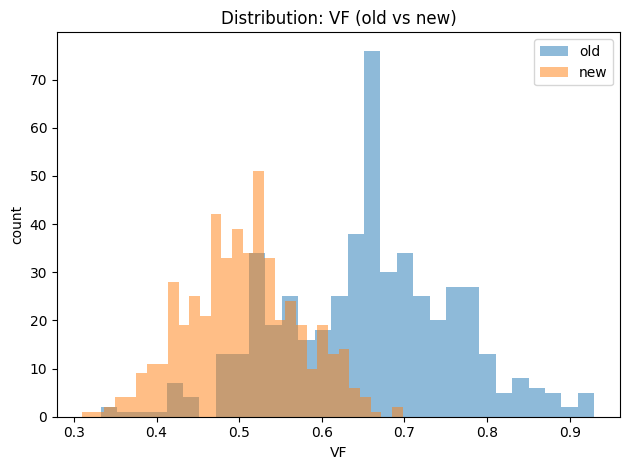

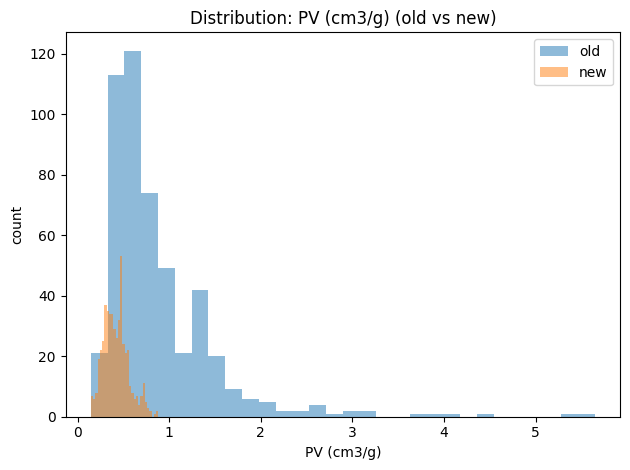

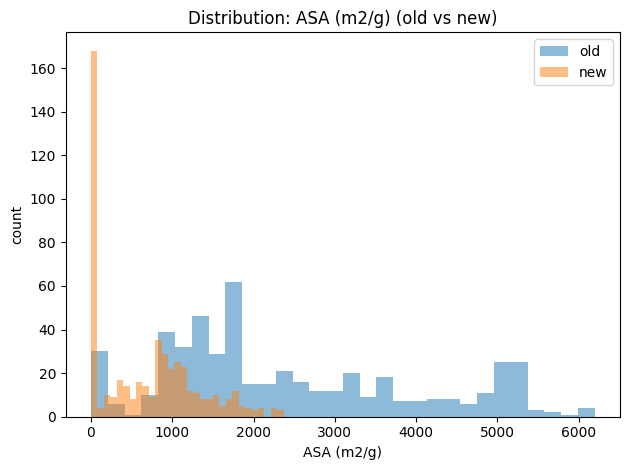

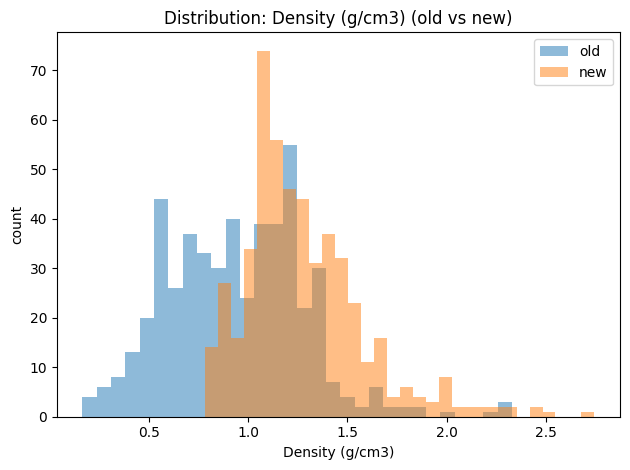

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


old = pd.read_csv("data_core/cif/CSD-modified/cifs/CR/asr_hts_outputs_adaptive_aligned/global_topN_scored.csv", low_memory=False)
new = pd.read_csv("data_core/cif/CSD-modified/cifs/CR/asr_hts_outputs_fused/global_topN_scored_fused.csv", low_memory=False)

KEY_NUMS = ["prediction","prediction_ensemble","prediction_fused","VF","PV (cm3/g)","ASA (m2/g)","Density (g/cm3)"]
KEY_CATS = ["topology(AllNodes)","structure_dimension","Metal Types"]

def summarize(df, tag):
    cols = [c for c in KEY_NUMS if c in df.columns]
    summ = df[cols].apply(pd.to_numeric, errors="coerce").describe().T
    summ.insert(0, "set", tag)
    return summ

sum_old = summarize(old, "old")
sum_new = summarize(new, "new")


# Composition tables
def comp(df, col, tag):
    if col not in df.columns:
        return pd.DataFrame(columns=[col,"n","pct","set"])
    vc = df[col].astype(str).value_counts(dropna=False)
    pct = vc / vc.sum()
    t = pd.DataFrame({col: vc.index, "n": vc.values, "pct": pct.values})
    t["set"] = tag
    return t

for c in KEY_CATS:
    t = pd.concat([comp(old, c, "old"), comp(new, c, "new")], axis=0, ignore_index=True)
    

# Plot distributions where column exists in both sets
for col in ["VF","PV (cm3/g)","ASA (m2/g)","Density (g/cm3)"]:
    if col in old.columns or col in new.columns:
        plt.figure()
        if col in old.columns:
            plt.hist(pd.to_numeric(old[col], errors="coerce").dropna(), bins=30, alpha=0.5, label="old")
        if col in new.columns:
            plt.hist(pd.to_numeric(new[col], errors="coerce").dropna(), bins=30, alpha=0.5, label="new")
        plt.xlabel(col); plt.ylabel("count"); plt.title(f"Distribution: {col} (old vs new)")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [89]:
# # hts/asr_screen_fused_with_stability_integrated.py
# #!/usr/bin/env python3
# """
# Integrated high-throughput screening with prediction fusion + geometry constraints + two stability strategies.
# - HARD: strict stability gate (thermal + water/solvent regex).
# - SOFT: keep all, subtract a stability penalty from the score.
# - Robust empty-pool guards: export empty CSVs with headers, skip concat/Pareto safely.
# 
# All comments in English (per request).
# """
# 
# from __future__ import annotations
# from pathlib import Path
# from typing import Iterable, List, Optional, Tuple, Dict
# import re
# import numpy as np
# import pandas as pd
# 
# 
# # ======================= Paths =======================
# INPUT1 = Path("data_core/cif/CSD-modified/cifs/CR/zeta_data/merged_with_lattice_renamed_zeta_pred.csv")
# 
# CSV_IN = INPUT1 
# 
# OUT_DIR = Path("data_core/cif/CSD-modified/cifs/CR/asr_hts_outputs_fused_stability")
# OUT_DIR.mkdir(parents=True, exist_ok=True)
# 
# # ======================= Columns =======================
# PRED_CGCNN = "prediction"
# PRED_ENSEMBLE = "prediction_ensemble"
# PRED_FUSED = "prediction_fused"   # created if missing
# 
# NUM_FEATURES = [
#     "LCD (Å)", "PLD (Å)", "LFPD (Å)", "Density (g/cm3)",
#     "ASA (A2)", "ASA (m2/cm3)", "ASA (m2/g)",
#     "NASA (A2)", "NASA (m2/cm3)", "NASA (m2/g)",
#     "PV (A3)", "VF", "PV (cm3/g)",
#     "NAV (A3)", "NAV_VF", "NPV (cm3/g)",
#     "average_atomic_mass", "natoms",
# ]
# CAT_FEATURES = [
#     "topology(AllNodes)", "topology(SingleNodes)",
#     "structure_dimension", "Metal Types", "Has OMS", "OMS Types",
#     "Water_stability", "Solvent_stability"
# ]
# ID_CANDS = ["id", "refcode", "name", "mofid-v1", "mofid-v2", "row_id"]
# 
# # =================== Geometry thresholds ===================
# INIT = dict(PLD_MIN=3.4, LCD_MIN=6.0, VF_MIN=0.35, PVG_MIN=0.50, ASA_MIN=600.0, DENSITY_MAX=1.00)
# BOUNDS = dict(PLD_MIN=3.0, LCD_MIN=5.0, VF_MIN=0.25, PVG_MIN=0.30, ASA_MIN=400.0, DENSITY_MAX=1.20)
# STEPS = dict(PLD_MIN=-0.2, LCD_MIN=-0.5, VF_MIN=-0.03, PVG_MIN=-0.05, ASA_MIN=-50.0, DENSITY_MAX=+0.05)
# MAX_RELAX_ROUNDS = 8
# MIN_POOL = 150
# 
# # =================== Stability parameters ===================
# THERMAL_MIN_C = 300.0  # HARD gate threshold; reduce to 250.0 if too strict
# STABLE_REGEX = r"(stable|robust|good)"  # case-insensitive for water/solvent labels
# 
# # SOFT penalty weights (tune if needed)
# SOFT_WATER_PENALTY   = 0.15  # add if water not matching regex
# SOFT_SOLVENT_PENALTY = 0.10  # add if solvent not matching regex
# SOFT_THERMAL_PENALTY = 0.10  # scaled by shortage degree below THERMAL_MIN_C
# 
# # =================== Scoring weights ===================
# W_PRED = 0.50
# W_PORE = 0.40
# W_DENS = 0.10
# 
# # =================== Diversity & exports ===================
# K_PER_TOPOLOGY = 8
# USE_SECONDARY_METAL_DEDUP = True
# TOP_N_GLOBAL = 500
# TOP_N_SHORTLIST = 150
# 
# # ======================= Helpers =======================
# def _coerce_float(df: pd.DataFrame, cols: Iterable[str]) -> None:
#     """Coerce columns to float; non-parsable values become NaN."""
#     for c in cols:
#         if c in df.columns:
#             df[c] = pd.to_numeric(df[c], errors="coerce")
# 
# def _first_id(df: pd.DataFrame, cands: List[str]) -> str:
#     """Pick the first existing ID column, else synthesize 'row_id'."""
#     for c in cands:
#         if c in df.columns:
#             return c
#     df["row_id"] = np.arange(len(df))
#     return "row_id"
# 
# def _rank01(s: pd.Series, ascending: bool) -> pd.Series:
#     """Stable [0,1] rank; handles ties; NaN-safe."""
#     r = s.rank(method="average", ascending=ascending, na_option="keep")
#     if r.notna().any():
#         den = r.max() - r.min()
#         return (r - r.min()) / den if den and den != 0 else pd.Series(0.5, index=r.index)
#     return r
# 
# def _zscore(s: pd.Series) -> pd.Series:
#     mu = s.mean(skipna=True)
#     sd = s.std(skipna=True)
#     if pd.notna(sd) and sd > 0:
#         return (s - mu) / sd
#     return pd.Series(0.0, index=s.index)
# 
# def _fuse_predictions(df: pd.DataFrame) -> pd.Series:
#     """Rank-based late fusion (equal weights) for CGCNN + Ensemble; fallback if one missing."""
#     if PRED_FUSED in df.columns:
#         return pd.to_numeric(df[PRED_FUSED], errors="coerce")
#     s1 = _rank01(pd.to_numeric(df[PRED_CGCNN], errors="coerce") if PRED_CGCNN in df.columns else pd.Series(np.nan, index=df.index), ascending=False)
#     s2 = _rank01(pd.to_numeric(df[PRED_ENSEMBLE], errors="coerce") if PRED_ENSEMBLE in df.columns else pd.Series(np.nan, index=df.index), ascending=False)
#     return 0.5 * s1.fillna(s1.mean()) + 0.5 * s2.fillna(s2.mean())
# 
# def _apply_constraints(df: pd.DataFrame, thr: Dict[str, float]) -> pd.Series:
#     has = df.columns.__contains__
#     mask = pd.Series(True, index=df.index)
#     if has("PLD (Å)"):         mask &= (df["PLD (Å)"] >= thr["PLD_MIN"])
#     if has("LCD (Å)"):         mask &= (df["LCD (Å)"] >= thr["LCD_MIN"])
#     if has("VF"):              mask &= (df["VF"] >= thr["VF_MIN"])
#     if has("PV (cm3/g)"):      mask &= (df["PV (cm3/g)"] >= thr["PVG_MIN"])
#     if has("ASA (m2/g)"):      mask &= (df["ASA (m2/g)"] >= thr["ASA_MIN"])
#     if has("Density (g/cm3)"): mask &= (df["Density (g/cm3)"] <= thr["DENSITY_MAX"])
#     return mask.fillna(False)
# 
# def _relax_once(thr: Dict[str, float]) -> Dict[str, float]:
#     new_thr = thr.copy()
#     for k, step in STEPS.items():
#         if k == "DENSITY_MAX":
#             new_thr[k] = min(thr[k] + step, BOUNDS["DENSITY_MAX"])
#         else:
#             new_thr[k] = max(thr[k] + step, BOUNDS[k])
#     return new_thr
# 
# def _quantile_fallback(df: pd.DataFrame, thr: Dict[str, float]) -> Dict[str, float]:
#     out = thr.copy()
#     def q(col: str, p: float) -> Optional[float]:
#         if col in df.columns and df[col].notna().any():
#             return float(df[col].quantile(p))
#         return None
#     for key, col in [("PLD_MIN","PLD (Å)"),("LCD_MIN","LCD (Å)"),("VF_MIN","VF"),("PVG_MIN","PV (cm3/g)"),("ASA_MIN","ASA (m2/g)")]:
#         v = q(col, 0.10)
#         if v is not None:
#             out[key] = max(min(out[key], v), BOUNDS[key])
#     v90 = q("Density (g/cm3)", 0.90)
#     if v90 is not None:
#         out["DENSITY_MAX"] = min(max(out["DENSITY_MAX"], v90), BOUNDS["DENSITY_MAX"])
#     return out
# 
# def _stability_mask_hard(df: pd.DataFrame) -> pd.Series:
#     """Strict gate: thermal >= THERMAL_MIN_C & water/solvent match regex."""
#     m = pd.Series(True, index=df.index)
#     if "Thermal_stability (℃)" in df.columns:
#         m &= (pd.to_numeric(df["Thermal_stability (℃)"], errors="coerce") >= THERMAL_MIN_C)
#     pattern = re.compile(STABLE_REGEX, flags=re.IGNORECASE)
#     if "Water_stability" in df.columns:
#         m &= df["Water_stability"].astype(str).str.contains(pattern, na=False)
#     if "Solvent_stability" in df.columns:
#         m &= df["Solvent_stability"].astype(str).str.contains(pattern, na=False)
#     return m.fillna(False)
# 
# def _stability_penalty_soft(df: pd.DataFrame) -> pd.Series:
#     """Soft penalty: +weights if water/solvent not matching regex; +thermal shortage penalty below THERMAL_MIN_C."""
#     pen = pd.Series(0.0, index=df.index)
#     pattern = re.compile(STABLE_REGEX, flags=re.IGNORECASE)
#     if "Water_stability" in df.columns:
#         bad = ~df["Water_stability"].astype(str).str.contains(pattern, na=False)
#         pen = pen + SOFT_WATER_PENALTY * bad.astype(float)
#     if "Solvent_stability" in df.columns:
#         bad = ~df["Solvent_stability"].astype(str).str.contains(pattern, na=False)
#         pen = pen + SOFT_SOLVENT_PENALTY * bad.astype(float)
#     if "Thermal_stability (℃)" in df.columns:
#         T = pd.to_numeric(df["Thermal_stability (℃)"], errors="coerce")
#         shortage = np.clip((THERMAL_MIN_C - T) / 100.0, 0.0, 1.0)
#         pen = pen + SOFT_THERMAL_PENALTY * shortage.fillna(1.0)  # missing T → max shortage
#     return pen
# 
# def _score_common(df: pd.DataFrame, pred_col: str) -> pd.Series:
#     """Score combining fused prediction, pore metrics (positive), and density (negative)."""
#     pos_feats = [c for c in ["PV (cm3/g)", "VF", "ASA (m2/g)"] if c in df.columns]
#     pred_rank = _rank01(df[pred_col], ascending=False)
#     if pos_feats:
#         stacks = [_rank01(df[c], ascending=False).fillna(0.5) for c in pos_feats]
#         pore_rank = pd.Series(np.nanmean(np.vstack(stacks), axis=0), index=df.index)
#     else:
#         pore_rank = pd.Series(0.0, index=df.index)
#     if "Density (g/cm3)" in df.columns:
#         dens_rank = _rank01(df["Density (g/cm3)"], ascending=True).fillna(0.5)  # lower density better
#     else:
#         dens_rank = pd.Series(0.0, index=df.index)
#     return (W_PRED * pred_rank.fillna(pred_rank.mean())) \
#          + (W_PORE * pore_rank.fillna(pore_rank.mean())) \
#          + (W_DENS * (1 - dens_rank))
# 
# def _diversity_shortlist(pool: pd.DataFrame, top_n: int) -> pd.DataFrame:
#     """Return a diverse shortlist; empty-pool safe."""
#     if pool is None or pool.empty:
#         return pd.DataFrame(columns=list(pool.columns) if pool is not None else [])
#     topo_col = "topology(AllNodes)" if "topology(AllNodes)" in pool.columns else None
#     strata_col = topo_col or ("structure_dimension" if "structure_dimension" in pool.columns else None)
# 
#     if strata_col:
#         picks: List[pd.DataFrame] = []
#         for _, g in pool.groupby(strata_col, dropna=False):
#             if g.empty:
#                 continue
#             g_sorted = g.sort_values("score", ascending=False)
#             if USE_SECONDARY_METAL_DEDUP and "Metal Types" in g_sorted.columns:
#                 seen = set(); picked = []
#                 for _, row in g_sorted.iterrows():
#                     mt = str(row["Metal Types"])
#                     if mt not in seen:
#                         picked.append(row); seen.add(mt)
#                     if len(picked) >= K_PER_TOPOLOGY:
#                         break
#                 sub = pd.DataFrame(picked)
#             else:
#                 sub = g_sorted.head(K_PER_TOPOLOGY)
#             if not sub.empty:
#                 picks.append(sub)
#         if picks:
#             sl = pd.concat(picks, ignore_index=True)
#         else:
#             sl = pool.sort_values("score", ascending=False).head(top_n).copy()
#     else:
#         sl = pool.sort_values("score", ascending=False).head(top_n).copy()
# 
#     if sl is None or sl.empty:
#         return pd.DataFrame(columns=list(pool.columns))
#     return sl.sort_values("score", ascending=False).head(top_n).copy()
# 
# def _export_empty_csv(path: Path, columns: List[str]) -> None:
#     pd.DataFrame(columns=columns).to_csv(path, index=False)
# 
# 
# # ======================= Load & prepare =======================
# df = pd.read_csv(CSV_IN, low_memory=False)
# id_col = _first_id(df, ID_CANDS)
# 
# # Coerce numerics & build fused prediction
# extra_num = ["Thermal_stability (℃)"] if "Thermal_stability (℃)" in df.columns else []
# num_cols = [c for c in NUM_FEATURES if c in df.columns]
# _coerce_float(df, num_cols + [PRED_CGCNN, PRED_ENSEMBLE] + extra_num)
# 
# df[PRED_FUSED] = _fuse_predictions(df)
# df = df.loc[~df[PRED_FUSED].isna()].copy()
# 
# # ======================= Common geometry constraints =======================
# thr = INIT.copy()
# mask_base = _apply_constraints(df, thr)
# rounds = 0
# while (not mask_base.any()) and rounds < MAX_RELAX_ROUNDS:
#     rounds += 1
#     thr = _relax_once(thr)
#     mask_base = _apply_constraints(df, thr)
# if not mask_base.any():
#     thr = _quantile_fallback(df, thr)
#     mask_base = _apply_constraints(df, thr)
# if not mask_base.any():
#     thr = dict(PLD_MIN=max(BOUNDS["PLD_MIN"], 3.0), LCD_MIN=BOUNDS["LCD_MIN"], VF_MIN=BOUNDS["VF_MIN"],
#                PVG_MIN=BOUNDS["PVG_MIN"], ASA_MIN=BOUNDS["ASA_MIN"], DENSITY_MAX=BOUNDS["DENSITY_MAX"])
#     mask_base = _apply_constraints(df, thr)
# 
# # Enlarge pool by relaxing density upper bound (within bound) to reach minimal pool size
# if "Density (g/cm3)" in df.columns and mask_base.any():
#     while mask_base.sum() < MIN_POOL and thr["DENSITY_MAX"] < BOUNDS["DENSITY_MAX"]:
#         thr["DENSITY_MAX"] = min(thr["DENSITY_MAX"] + 0.05, BOUNDS["DENSITY_MAX"])
#         mask_base = _apply_constraints(df, thr)
# 
# # ======================= HARD strategy =======================
# hard_df = df.copy()
# hard_df["score"] = _score_common(hard_df, PRED_FUSED)
# 
# mask_hard_stab = _stability_mask_hard(hard_df)
# mask_hard = (mask_base & mask_hard_stab)
# 
# if not mask_hard.any():
#     print("[HARD] Warning: no entries pass stability hard gate; exporting empty artifacts.")
#     cols_hdr = list(hard_df.columns)
#     _export_empty_csv(OUT_DIR / "hard_pool_pass_constraints.csv", cols_hdr)
#     _export_empty_csv(OUT_DIR / "hard_global_topN_scored.csv", cols_hdr)
#     _export_empty_csv(OUT_DIR / "hard_shortlist_diverse.csv", cols_hdr)
#     _export_empty_csv(OUT_DIR / "hard_pareto_front.csv", cols_hdr)
# else:
#     pool_hard = hard_df.loc[mask_hard].copy().sort_values("score", ascending=False)
#     pool_hard.to_csv(OUT_DIR / "hard_pool_pass_constraints.csv", index=False)
#     hard_df.sort_values("score", ascending=False).head(TOP_N_GLOBAL).to_csv(OUT_DIR / "hard_global_topN_scored.csv", index=False)
# 
#     hard_shortlist = _diversity_shortlist(pool_hard, TOP_N_SHORTLIST)
#     hard_shortlist.to_csv(OUT_DIR / "hard_shortlist_diverse.csv", index=False)
# 
#     # Pareto (HARD) with guard
#     if not pool_hard.empty:
#         objs, maximize = [], []
#         if PRED_FUSED in pool_hard.columns:   objs.append(pool_hard[PRED_FUSED].to_numpy(float));   maximize.append(True)
#         if "PV (cm3/g)" in pool_hard.columns: objs.append(pool_hard["PV (cm3/g)"].to_numpy(float)); maximize.append(True)
#         if "VF" in pool_hard.columns:         objs.append(pool_hard["VF"].to_numpy(float));         maximize.append(True)
#         if "ASA (m2/g)" in pool_hard.columns: objs.append(pool_hard["ASA (m2/g)"].to_numpy(float)); maximize.append(True)
#         if "Density (g/cm3)" in pool_hard.columns:
#             objs.append(pool_hard["Density (g/cm3)"].to_numpy(float));                              maximize.append(False)
#         if objs:
#             M = np.vstack(objs).T
#             B = M.copy()
#             for j, is_max in enumerate(maximize):
#                 if is_max: B[:, j] = -B[:, j]
#             eff = np.ones(B.shape[0], dtype=bool)
#             for i in range(B.shape[0]):
#                 if not eff[i]: continue
#                 dom = (B <= B[i]).all(axis=1) & (B < B[i]).any(axis=1); dom[i] = False
#                 if dom.any(): eff[i] = False
#             pool_hard.loc[eff].sort_values("score", ascending=False).to_csv(OUT_DIR / "hard_pareto_front.csv", index=False)
#         else:
#             _export_empty_csv(OUT_DIR / "hard_pareto_front.csv", list(pool_hard.columns))
# 
# # ======================= SOFT strategy =======================
# soft_df = df.copy()
# soft_df["score_base"] = _score_common(soft_df, PRED_FUSED)
# soft_df["stability_penalty"] = _stability_penalty_soft(soft_df)
# soft_df["score"] = soft_df["score_base"] - soft_df["stability_penalty"]
# 
# pool_soft = soft_df.loc[mask_base].copy().sort_values("score", ascending=False)
# pool_soft.to_csv(OUT_DIR / "soft_pool_pass_constraints.csv", index=False)
# soft_df.sort_values("score", ascending=False).head(TOP_N_GLOBAL).to_csv(OUT_DIR / "soft_global_topN_scored.csv", index=False)
# 
# soft_shortlist = _diversity_shortlist(pool_soft, TOP_N_SHORTLIST)
# soft_shortlist.to_csv(OUT_DIR / "soft_shortlist_diverse.csv", index=False)
# 
# # Pareto (SOFT) with guard
# if not pool_soft.empty:
#     objs, maximize = [], []
#     if PRED_FUSED in pool_soft.columns:   objs.append(pool_soft[PRED_FUSED].to_numpy(float));   maximize.append(True)
#     if "PV (cm3/g)" in pool_soft.columns: objs.append(pool_soft["PV (cm3/g)"].to_numpy(float)); maximize.append(True)
#     if "VF" in pool_soft.columns:         objs.append(pool_soft["VF"].to_numpy(float));         maximize.append(True)
#     if "ASA (m2/g)" in pool_soft.columns: objs.append(pool_soft["ASA (m2/g)"].to_numpy(float)); maximize.append(True)
#     if "Density (g/cm3)" in pool_soft.columns:
#         objs.append(pool_soft["Density (g/cm3)"].to_numpy(float));                                maximize.append(False)
#     if objs:
#         M = np.vstack(objs).T
#         B = M.copy()
#         for j, is_max in enumerate(maximize):
#             if is_max: B[:, j] = -B[:, j]
#         eff = np.ones(B.shape[0], dtype=bool)
#         for i in range(B.shape[0]):
#             if not eff[i]: continue
#             dom = (B <= B[i]).all(axis=1) & (B < B[i]).any(axis=1); dom[i] = False
#             if dom.any(): eff[i] = False
#         pool_soft.loc[eff].sort_values("score", ascending=False).to_csv(OUT_DIR / "soft_pareto_front.csv", index=False)
#     else:
#         _export_empty_csv(OUT_DIR / "soft_pareto_front.csv", list(pool_soft.columns))
# 
# # ======================= Logs =======================
# print(f"[GEOMETRY] PLD≥{thr['PLD_MIN']:.2f}Å, LCD≥{thr['LCD_MIN']:.2f}Å, VF≥{thr['VF_MIN']:.2f}, "
#       f"PV≥{thr['PVG_MIN']:.2f} cm3/g, ASA≥{thr['ASA_MIN']:.0f} m2/g, ρ≤{thr['DENSITY_MAX']:.2f} g/cm3")
# print(f"[HARD] thermal≥{THERMAL_MIN_C:.0f}℃ & regex={STABLE_REGEX!r} (case-insensitive) → see hard_* files")
# print(f"[SOFT] penalty weights: water={SOFT_WATER_PENALTY}, solvent={SOFT_SOLVENT_PENALTY}, thermal={SOFT_THERMAL_PENALTY} → see soft_* files")
# print(f"Outputs → {OUT_DIR.resolve()}")


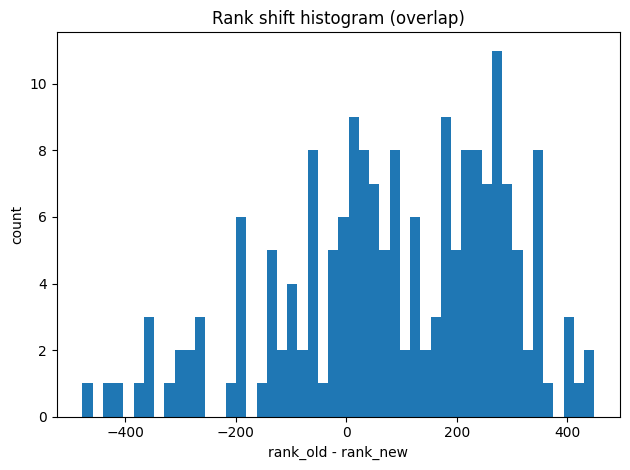

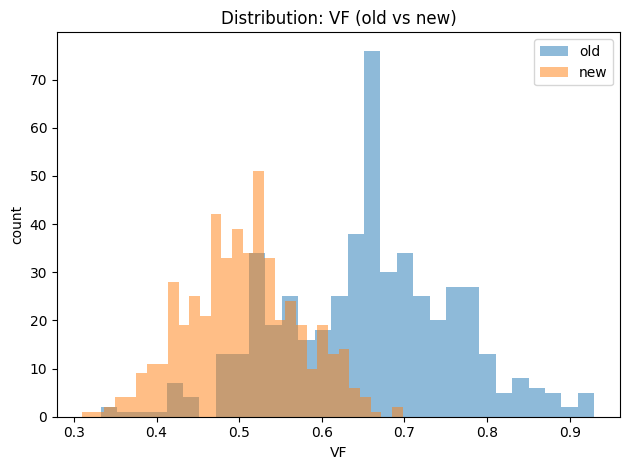

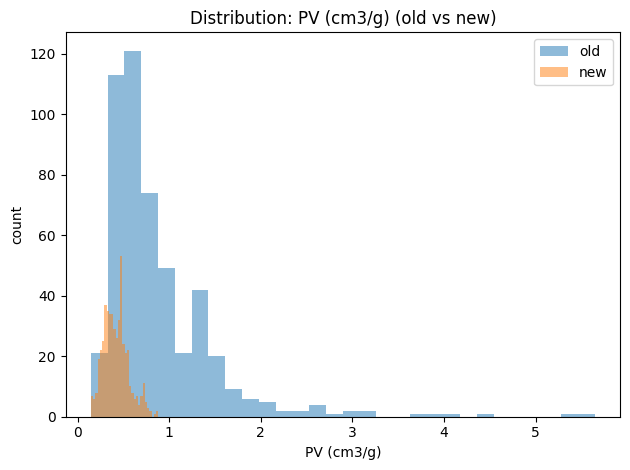

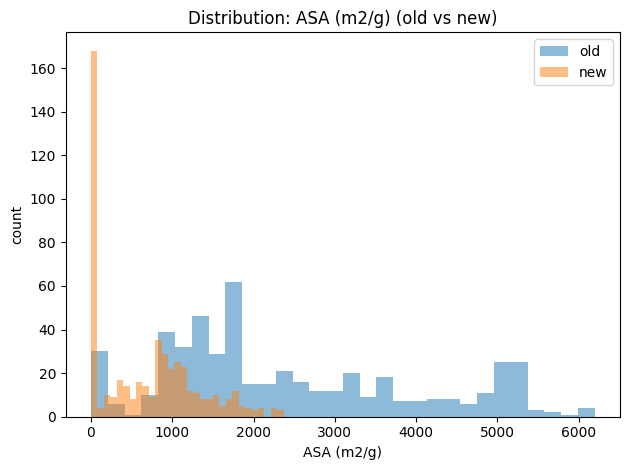

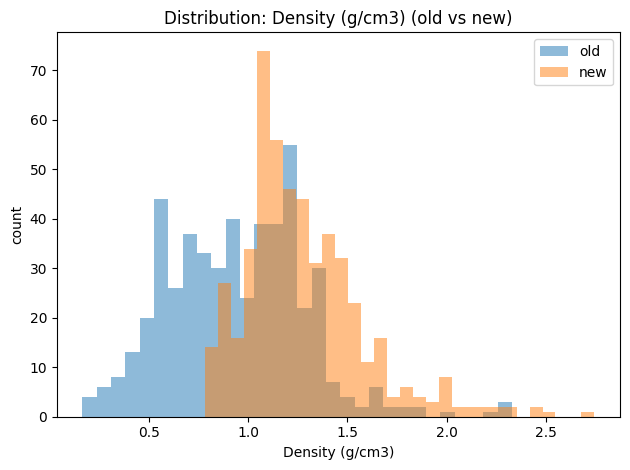

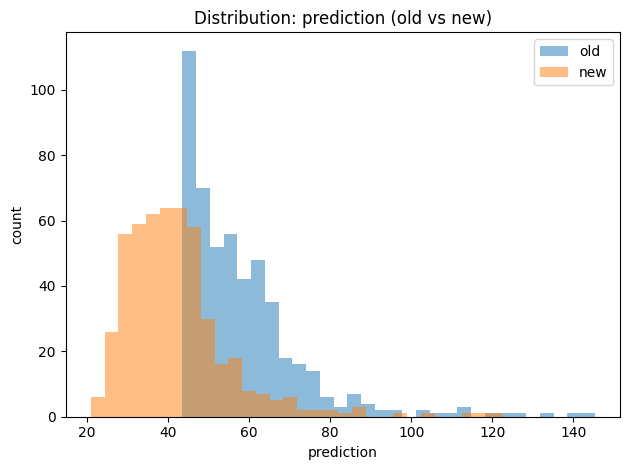

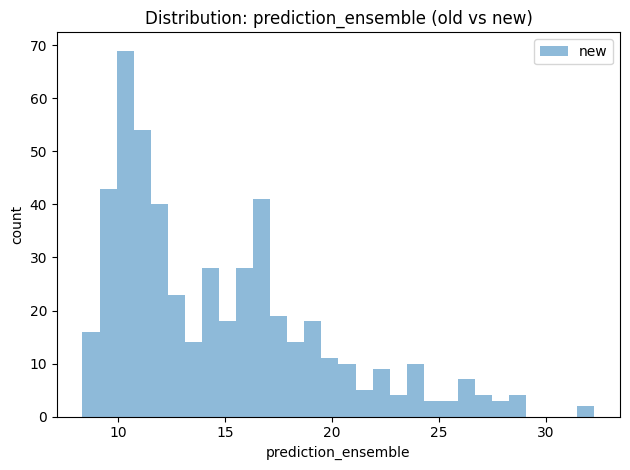

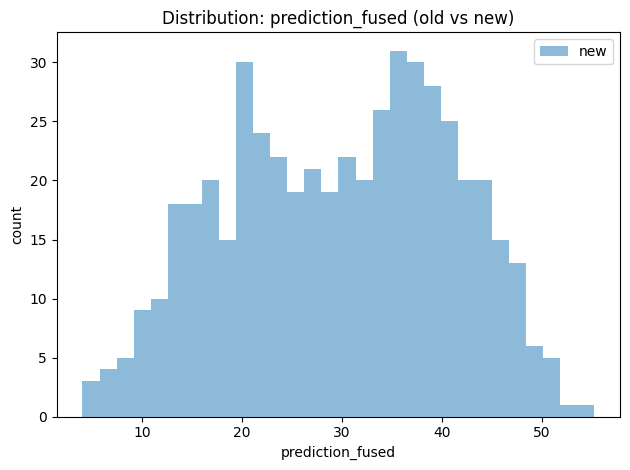

Artifacts saved to: paper_summary_ab
Files:
 - paper_summary_ab\composition_delta_metals.csv
 - paper_summary_ab\composition_delta_structure.csv
 - paper_summary_ab\composition_delta_topology.csv
 - paper_summary_ab\dist_ASA_m2_g.png
 - paper_summary_ab\dist_Density_g_cm3.png
 - paper_summary_ab\dist_prediction.png
 - paper_summary_ab\dist_prediction_ensemble.png
 - paper_summary_ab\dist_prediction_fused.png
 - paper_summary_ab\dist_PV_cm3_g.png
 - paper_summary_ab\dist_VF.png
 - paper_summary_ab\head_new_top30.csv
 - paper_summary_ab\head_old_top30.csv
 - paper_summary_ab\kpi_summary.csv
 - paper_summary_ab\numeric_summary.csv
 - paper_summary_ab\rank_shift_hist.png


In [90]:
# Paper-ready A/B comparison summary for two pipelines:
# - A: baseline (CGCNN-aligned)  -> /mnt/data/global_topN_scored.csv
# - B: fused strategy            -> /mnt/data/global_topN_scored_fused.csv
#
# What this script produces (all under /mnt/data/paper_summary_ab/):
# 1) kpi_summary.csv                  # Jaccard, overlap, rank-shift stats
# 2) rank_shift_hist.png              # rank shift histogram (overlap)
# 3) numeric_summary.csv              # describe() for key numeric columns (old/new)
# 4) composition_delta_topology.csv   # composition delta tables
# 5) composition_delta_structure.csv
# 6) composition_delta_metals.csv
# 7) dist_*.png                       # distributions for key numeric: VF, PVg, ASA_g, density, predictions
# 8) head_old_top30.csv / head_new_top30.csv
#
# Notes:
# - Uses matplotlib only; one chart per figure; default colors.
# - Robust to missing columns.
# - Auto-detects an ID-like column.


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import chain


OUTDIR = Path("./paper_summary_ab")
OUTDIR.mkdir(parents=True, exist_ok=True)

OLD_PATH = Path("data_core/cif/CSD-modified/cifs/CR/asr_hts_outputs_adaptive_aligned/global_topN_scored.csv")          # pipeline A (CGCNN-aligned Top-N)
NEW_PATH = Path("data_core/cif/CSD-modified/cifs/CR/asr_hts_outputs_fused/global_topN_scored_fused.csv")    # pipeline B (Fused Top-N)

old = pd.read_csv(OLD_PATH, low_memory=False)
new = pd.read_csv(NEW_PATH, low_memory=False)

ID_CAND = ["id","refcode","name","mofid-v1","mofid-v2","row_id","uid","ID","Id","material_id"]
PRED_COLS = ["prediction","prediction_ensemble","prediction_fused"]
META_COLS = ["topology(AllNodes)","structure_dimension","Metal Types"]
FEAT_COLS = ["VF","PV (cm3/g)","ASA (m2/g)","Density (g/cm3)","PLD (Å)","LCD (Å)"]

def pick_id(df):
    for c in ID_CAND:
        if c in df.columns:
            return c
    # Fallback create
    df.reset_index(inplace=True)
    df.rename(columns={"index":"row_id_idx"}, inplace=True)
    return "row_id_idx"

id_old = pick_id(old)
id_new = pick_id(new)

# De-duplicate and rank by score descending if available
old = old.drop_duplicates(subset=[id_old]).copy()
new = new.drop_duplicates(subset=[id_new]).copy()

if "score" in old.columns:
    old = old.sort_values("score", ascending=False)
old["rank_old"] = np.arange(1, len(old)+1)

if "score" in new.columns:
    new = new.sort_values("score", ascending=False)
new["rank_new"] = np.arange(1, len(new)+1)

# Keep comparable columns
keep_old = [id_old,"rank_old"] + ([ "score" ] if "score" in old.columns else []) + [c for c in chain(PRED_COLS, META_COLS, FEAT_COLS) if c in old.columns]
keep_new = [id_new,"rank_new"] + ([ "score" ] if "score" in new.columns else []) + [c for c in chain(PRED_COLS, META_COLS, FEAT_COLS) if c in new.columns]

old_s = old[keep_old].copy()
new_s = new[keep_new].copy().rename(columns={id_new: id_old})

# ============ KPI & overlap ============
ov = pd.merge(old_s, new_s, on=id_old, how="inner", suffixes=("_old","_new"))
ov["rank_diff"] = ov["rank_old"] - ov["rank_new"]
ov["abs_rank_diff"] = ov["rank_diff"].abs()

n_old, n_new, n_ov = len(old_s), len(new_s), len(ov)
jaccard = n_ov / (n_old + n_new - n_ov) if (n_old + n_new - n_ov) else float("nan")
mean_abs_shift = ov["abs_rank_diff"].mean() if n_ov else float("nan")
median_abs_shift = ov["abs_rank_diff"].median() if n_ov else float("nan")

kpi = pd.DataFrame([{
    "N_old": n_old, "N_new": n_new, "N_overlap": n_ov,
    "Jaccard": jaccard, "mean|rank shift|": mean_abs_shift, "median|rank shift|": median_abs_shift
}])
kpi.to_csv(OUTDIR / "kpi_summary.csv", index=False)


# ============ Rank-shift histogram ============
if n_ov > 0:
    plt.figure()
    plt.hist(ov["rank_diff"], bins=50)
    plt.xlabel("rank_old - rank_new")
    plt.ylabel("count")
    plt.title("Rank shift histogram (overlap)")
    plt.tight_layout()
    plt.savefig(OUTDIR / "rank_shift_hist.png", dpi=200)
    plt.show()

# ============ Numeric summaries ============
def numeric_summary(tag, df_part):
    cols = [c for c in PRED_COLS + FEAT_COLS if c in df_part.columns]
    out = df_part[cols].apply(pd.to_numeric, errors="coerce").describe().T
    out.insert(0, "set", tag)
    return out

sum_old = numeric_summary("old", old_s)
sum_new = numeric_summary("new", new_s)
num_sum = pd.concat([sum_old, sum_new], axis=0)
num_sum.to_csv(OUTDIR / "numeric_summary.csv")


# ============ Composition deltas ============
def comp_delta(col):
    parts = []
    for df_, tag in [(old_s,"old"), (new_s,"new")]:
        if col in df_.columns:
            vc = df_[col].astype(str).value_counts(dropna=False)
            pct = vc / vc.sum()
            t = pd.DataFrame({col: vc.index, f"{tag}_n": vc.values, f"{tag}_pct": pct.values})
            parts.append(t.set_index(col))
    if not parts:
        return pd.DataFrame()
    out = pd.concat(parts, axis=1).fillna(0)
    if "new_pct" in out.columns and "old_pct" in out.columns:
        out["delta_pct(new-old)"] = out["new_pct"] - out["old_pct"]
    return out.sort_values("delta_pct(new-old)", ascending=False)

topo_delta = comp_delta("topology(AllNodes)")
sdim_delta = comp_delta("structure_dimension")
metal_delta = comp_delta("Metal Types")

if not topo_delta.empty:
    topo_delta.reset_index().to_csv(OUTDIR / "composition_delta_topology.csv", index=False)
    

if not sdim_delta.empty:
    sdim_delta.reset_index().to_csv(OUTDIR / "composition_delta_structure.csv", index=False)
    

if not metal_delta.empty:
    metal_delta.reset_index().to_csv(OUTDIR / "composition_delta_metals.csv", index=False)
    

# ============ Distributions (overlaid hist) ============
DIST_COLS = ["VF","PV (cm3/g)","ASA (m2/g)","Density (g/cm3)","prediction","prediction_ensemble","prediction_fused"]
for col in DIST_COLS:
    if (col in old_s.columns) or (col in new_s.columns):
        plt.figure()
        if col in old_s.columns:
            plt.hist(pd.to_numeric(old_s[col], errors="coerce").dropna(), bins=30, alpha=0.5, label="old")
        if col in new_s.columns:
            plt.hist(pd.to_numeric(new_s[col], errors="coerce").dropna(), bins=30, alpha=0.5, label="new")
        plt.xlabel(col)
        plt.ylabel("count")
        plt.title(f"Distribution: {col} (old vs new)")
        plt.legend()
        plt.tight_layout()
        plt.savefig(OUTDIR / f"dist_{col.replace('/', '_').replace(' ', '_').replace('(', '').replace(')', '').replace('Å','A')}.png", dpi=200)
        plt.show()

# ============ Heads for quick inspection ============
old_s.head(30).to_csv(OUTDIR / "head_old_top30.csv", index=False)
new_s.head(30).to_csv(OUTDIR / "head_new_top30.csv", index=False)

print("Artifacts saved to:", OUTDIR)
print("Files:")
for p in sorted(OUTDIR.iterdir()):
    print(" -", p)


In [91]:
# Create (a) an A4 montage PNG summarizing A/B results and (b) a unified Pareto + diversity shortlist
# Inputs (already produced in prior steps):
#   /mnt/data/paper_summary_ab/*.png|csv
#   /mnt/data/global_topN_scored.csv
#   /mnt/data/global_topN_scored_fused.csv
#
# Outputs (written to /mnt/data/paper_summary_ab_final/):
#   1) paper_montage_A4.png
#   2) unified_union_with_flags.csv           # union with flags and both scores/ranks
#   3) unified_pareto.csv                     # Pareto subset
#   4) unified_shortlist_diverse.csv          # diversity shortlist on union Pareto
#   5) unified_readme.txt                     # quick notes
#
# Montage implementation uses PIL to compose existing figures (no matplotlib subplots).

import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import textwrap

BASE = Path("data_core/cif/CSD-modified/cifs/CR")
AB_DIR = BASE / "paper_summary_ab"
FIN_DIR = BASE / "paper_summary_ab_final"
FIN_DIR.mkdir(parents=True, exist_ok=True)

OLD_PATH = ("data_core/cif/CSD-modified/cifs/CR/asr_hts_outputs_adaptive_aligned/global_topN_scored.csv")          # pipeline A (CGCNN-aligned Top-N)
NEW_PATH = ("data_core/cif/CSD-modified/cifs/CR/asr_hts_outputs_fused/global_topN_scored_fused.csv")     # pipeline B (Fused Top-N)

# --------- 1) Build A4 montage from existing images ---------
# Collect candidate images (use if exists)
img_names = [
    "rank_shift_hist.png",
    "dist_prediction.png",
    "dist_prediction_ensemble.png",
    "dist_prediction_fused.png",
    "dist_VF.png",
    "dist_PV_cm3_g.png",
    "dist_ASA_m2_g.png",
    "dist_Density_g_cm3.png",
]
imgs = [AB_DIR / n for n in img_names if (AB_DIR / n).exists()]

# A4 at 300 DPI → 3508x2480 px (landscape 3508x2480, portrait 2480x3508). We'll create portrait.
W, H = 2480, 3508
canvas = Image.new("RGB", (W, H), "white")
draw = ImageDraw.Draw(canvas)

# Title and small text helper
title = "A/B Screening Summary — CGCNN-aligned vs Fused"
subtitle = "Top-N distributions & rank-shift (each histogram from prior analysis)"

# Basic font fallback
try:
    font_title = ImageFont.truetype("DejaVuSans-Bold.ttf", 56)
    font_sub = ImageFont.truetype("DejaVuSans.ttf", 34)
    font_caption = ImageFont.truetype("DejaVuSans.ttf", 28)
    font_small = ImageFont.truetype("DejaVuSans.ttf", 24)
except:
    font_title = ImageFont.load_default()
    font_sub = ImageFont.load_default()
    font_caption = ImageFont.load_default()
    font_small = ImageFont.load_default()

# Header
draw.text((80, 60), title, fill="black", font=font_title)
draw.text((80, 130), subtitle, fill="black", font=font_sub)

# If KPI csv exists, render a few key values as text
kpi_path = AB_DIR / "kpi_summary.csv"
kpi_text = ""
if kpi_path.exists():
    kpi = pd.read_csv(kpi_path)
    if not kpi.empty:
        row = kpi.iloc[0].to_dict()
        kpi_text = f"N_old={int(row.get('N_old',0))}, N_new={int(row.get('N_new',0))}, overlap={int(row.get('N_overlap',0))}, " \
                   f"Jaccard={row.get('Jaccard', float('nan')):.3f}, mean|Δrank|={row.get('mean|rank shift|', float('nan')):.2f}"
        draw.text((80, 180), kpi_text, fill="black", font=font_sub)

# Grid placement (3 columns x up to 3 rows below header)
# We'll scale each image to fit cell size (padding included). Avoid subplots by PIL pasting.
COLS, ROWS = 3, 3
pad = 30
top_offset = 240
cell_w = (W - (COLS + 1)*pad) // COLS
cell_h = (H - top_offset - (ROWS + 1)*pad) // ROWS

i = 0
for path in imgs[:COLS*ROWS]:
    try:
        im = Image.open(path).convert("RGB")
        # maintain aspect ratio
        ratio = min(cell_w / im.width, cell_h / im.height)
        new_size = (max(1, int(im.width*ratio)), max(1, int(im.height*ratio)))
        im = im.resize(new_size, Image.LANCZOS)
        r = i // COLS; c = i % COLS
        x = pad + c*(cell_w + pad) + (cell_w - im.width)//2
        y = top_offset + pad + r*(cell_h + pad) + (cell_h - im.height)//2
        canvas.paste(im, (x, y))
        # caption
        draw.text((x, y + im.height + 5), path.name, fill="black", font=font_small)
        i += 1
    except Exception as e:
        # skip broken image
        continue

montage_path = FIN_DIR / "paper_montage_A4.png"
canvas.save(montage_path, dpi=(300,300))

# --------- 2) Unified union + Pareto + diversity shortlist ---------
old = pd.read_csv(OLD_PATH, low_memory=False)
new = pd.read_csv(NEW_PATH, low_memory=False)

# detect id
ID_CAND = ["id","refcode","name","mofid-v1","mofid-v2","row_id","uid","ID","Id","material_id"]
def pick_id(df):
    for c in ID_CAND:
        if c in df.columns:
            return c
    df.reset_index(inplace=True)
    df.rename(columns={"index":"row_id_idx"}, inplace=True)
    return "row_id_idx"

id_old = pick_id(old)
id_new = pick_id(new)

old = old.drop_duplicates(subset=[id_old]).copy()
new = new.drop_duplicates(subset=[id_new]).copy()

# ranks
if "score" in old.columns:
    old = old.sort_values("score", ascending=False).copy()
old["rank_old"] = np.arange(1, len(old)+1)

if "score" in new.columns:
    new = new.sort_values("score", ascending=False).copy()
new["rank_new"] = np.arange(1, len(new)+1)

# minimal columns for union
keep_old = [id_old, "rank_old"] + [c for c in ["score","prediction","prediction_ensemble","prediction_fused",
                                               "VF","PV (cm3/g)","ASA (m2/g)","Density (g/cm3)",
                                               "topology(AllNodes)","structure_dimension","Metal Types"] if c in old.columns]
keep_new = [id_new, "rank_new"] + [c for c in ["score","prediction","prediction_ensemble","prediction_fused",
                                               "VF","PV (cm3/g)","ASA (m2/g)","Density (g/cm3)",
                                               "topology(AllNodes)","structure_dimension","Metal Types"] if c in new.columns]

old_s = old[keep_old].copy()
new_s = new[keep_new].copy().rename(columns={id_new: id_old})

# add flags
old_s["in_old"] = True
new_s["in_new"] = True

# merge as full outer join to preserve both sets
union = pd.merge(old_s, new_s, on=id_old, how="outer", suffixes=("_old","_new"))
union[id_old] = union[id_old].astype(str)

# build unified columns
def pick_col(row, base):
    # prefer _old then _new if base duplicated; else base
    if f"{base}_old" in row.index and pd.notna(row[f"{base}_old"]):
        return row[f"{base}_old"]
    if f"{base}_new" in row.index and pd.notna(row[f"{base}_new"]):
        return row[f"{base}_new"]
    return row.get(base, np.nan)

for base in ["prediction","prediction_ensemble","prediction_fused","VF","PV (cm3/g)","ASA (m2/g)","Density (g/cm3)",
             "topology(AllNodes)","structure_dimension","Metal Types"]:
    union[base] = union.apply(lambda r: pick_col(r, base), axis=1)

union["in_old"] = union["in_old"].fillna(False)
union["in_new"] = union["in_new"].fillna(False)

# Pareto on union using [prediction, PV, VF, ASA] maximize; Density minimize (present-only guard)
objs = []
maximize = []
if "prediction" in union.columns:        objs.append(pd.to_numeric(union["prediction"], errors="coerce").to_numpy());        maximize.append(True)
if "PV (cm3/g)" in union.columns:        objs.append(pd.to_numeric(union["PV (cm3/g)"], errors="coerce").to_numpy());      maximize.append(True)
if "VF" in union.columns:                objs.append(pd.to_numeric(union["VF"], errors="coerce").to_numpy());              maximize.append(True)
if "ASA (m2/g)" in union.columns:        objs.append(pd.to_numeric(union["ASA (m2/g)"], errors="coerce").to_numpy());      maximize.append(True)
if "Density (g/cm3)" in union.columns:   objs.append(pd.to_numeric(union["Density (g/cm3)"], errors="coerce").to_numpy()); maximize.append(False)

pareto_idx = np.array([], dtype=bool)
if objs:
    M = np.vstack(objs).T
    # drop rows with all-NaN across objectives
    valid = ~np.all(np.isnan(M), axis=1)
    Mv = M[valid].copy()

    # replace NaN with column medians for Pareto comparability
    col_med = np.nanmedian(Mv, axis=0)
    for j in range(Mv.shape[1]):
        mask_nan = np.isnan(Mv[:, j])
        if mask_nan.any():
            Mv[mask_nan, j] = col_med[j]

    # convert to minimization
    B = Mv.copy()
    for j, is_max in enumerate(maximize):
        if is_max:
            B[:, j] = -B[:, j]

    n = B.shape[0]
    eff = np.ones(n, dtype=bool)
    for i in range(n):
        if not eff[i]:
            continue
        dom = (B <= B[i]).all(axis=1) & (B < B[i]).any(axis=1)
        dom[i] = False
        if dom.any():
            eff[i] = False

    pareto_idx = np.zeros(len(union), dtype=bool)
    pareto_idx[np.where(valid)[0][eff]] = True
else:
    pareto_idx = np.zeros(len(union), dtype=bool)

union["pareto_flag"] = pareto_idx

# Diversity shortlist from Pareto subset
K_PER_TOPOLOGY = 8
TOP_N_SHORTLIST = 150
sub = union.loc[union["pareto_flag"]].copy()

# If no topology, fallback to structure_dimension; if both missing, take head
strata_col = "topology(AllNodes)" if "topology(AllNodes)" in sub.columns else ("structure_dimension" if "structure_dimension" in sub.columns else None)

shortlist_rows = []
if strata_col and not sub.empty:
    for k, g in sub.groupby(strata_col, dropna=False):
        g_sorted = g.copy()
        # proxy score for ordering: combine normalized prediction with pores, fallback to prediction only
        pr = pd.to_numeric(g_sorted["prediction"], errors="coerce")
        g_sorted["score_proxy"] = (pr - pr.min()) / (pr.max() - pr.min()) if pr.notna().any() and pr.max() != pr.min() else pr.fillna(0)
        g_sorted = g_sorted.sort_values("score_proxy", ascending=False)
        # de-dup by Metal Types if available
        if "Metal Types" in g_sorted.columns:
            seen = set(); picked = []
            for _, row in g_sorted.iterrows():
                mt = str(row["Metal Types"])
                if mt not in seen:
                    picked.append(row); seen.add(mt)
                if len(picked) >= K_PER_TOPOLOGY:
                    break
            subk = pd.DataFrame(picked)
        else:
            subk = g_sorted.head(K_PER_TOPOLOGY)
        shortlist_rows.append(subk)
    shortlist = pd.concat(shortlist_rows, ignore_index=True) if shortlist_rows else sub.head(TOP_N_SHORTLIST).copy()
else:
    shortlist = sub.head(TOP_N_SHORTLIST).copy()

# flag shortlist in union
union["shortlist_flag"] = union[id_old].isin(set(shortlist[id_old].astype(str))) if not shortlist.empty else False

# Reorder and save tables
cols_export = [id_old, "in_old","in_new","pareto_flag","shortlist_flag",
               "rank_old","score_old","rank_new","score_new",
               "prediction","prediction_ensemble","prediction_fused",
               "VF","PV (cm3/g)","ASA (m2/g)","Density (g/cm3)",
               "topology(AllNodes)","structure_dimension","Metal Types"]

# Ensure columns exist
for c in ["score_old","score_new"]:
    if c not in union.columns:
        union[c] = np.nan

union_sorted = union.copy()
# Prefer to order by shortlist, then pareto, then a proxy score
proxy = pd.to_numeric(union_sorted["prediction"], errors="coerce")
union_sorted["score_proxy"] = (proxy - proxy.min()) / (proxy.max() - proxy.min()) if proxy.notna().any() and proxy.max()!=proxy.min() else proxy.fillna(0)
union_sorted = union_sorted.sort_values(["shortlist_flag","pareto_flag","score_proxy"], ascending=[False, False, False])

union_sorted[cols_export] = union_sorted.reindex(columns=cols_export)
union_sorted.to_csv(FIN_DIR / "unified_union_with_flags.csv", index=False)
sub.to_csv(FIN_DIR / "unified_pareto.csv", index=False)
shortlist.to_csv(FIN_DIR / "unified_shortlist_diverse.csv", index=False)

# README
with open(FIN_DIR / "unified_readme.txt","w",encoding="utf-8") as f:
    f.write(
        "A/B unified outputs\n"
        "- paper_montage_A4.png: composed page for main text.\n"
        "- unified_union_with_flags.csv: union table with flags (in_old/in_new/pareto/shortlist) and both ranks/scores.\n"
        "- unified_pareto.csv: Pareto subset on [prediction, PV, VF, ASA] maximize; Density minimize.\n"
        "- unified_shortlist_diverse.csv: diversity shortlist from Pareto (per topology/structure), metal de-dup.\n"
        "Notes: score_proxy only used for ordering within union when needed.\n"
    )

print("DONE. Outputs saved to:", FIN_DIR)
for p in sorted(FIN_DIR.iterdir()):
    print(" -", p)


DONE. Outputs saved to: data_core\cif\CSD-modified\cifs\CR\paper_summary_ab_final
 - data_core\cif\CSD-modified\cifs\CR\paper_summary_ab_final\paper_montage_A4.png
 - data_core\cif\CSD-modified\cifs\CR\paper_summary_ab_final\unified_pareto.csv
 - data_core\cif\CSD-modified\cifs\CR\paper_summary_ab_final\unified_readme.txt
 - data_core\cif\CSD-modified\cifs\CR\paper_summary_ab_final\unified_shortlist_diverse.csv
 - data_core\cif\CSD-modified\cifs\CR\paper_summary_ab_final\unified_shortlist_diverse_enriched.csv
 - data_core\cif\CSD-modified\cifs\CR\paper_summary_ab_final\unified_union_with_flags.csv


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21564\1340703937.py:171: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  union["in_old"] = union["in_old"].fillna(False)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21564\1340703937.py:172: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  union["in_new"] = union["in_new"].fillna(False)


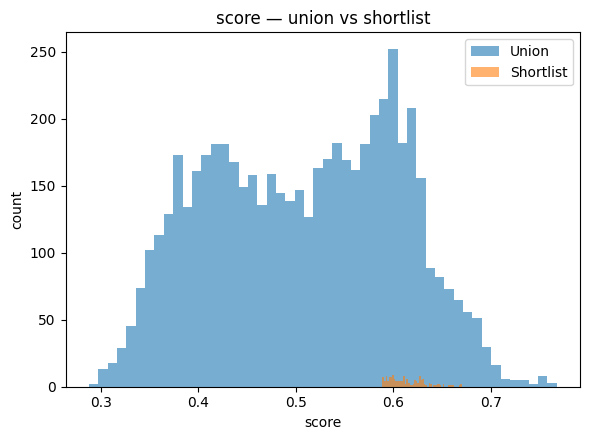

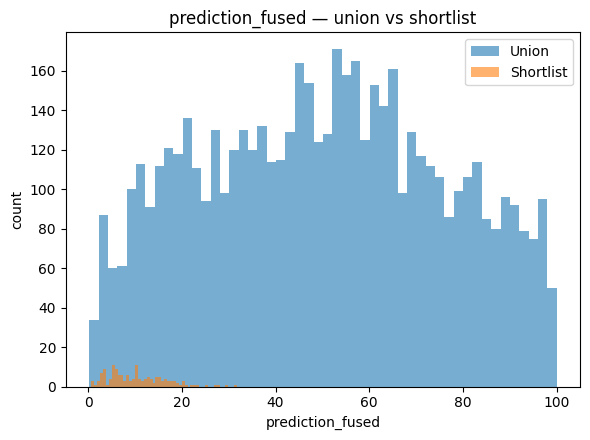

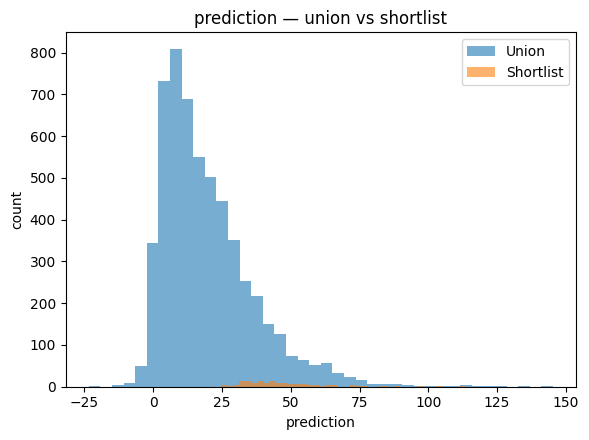

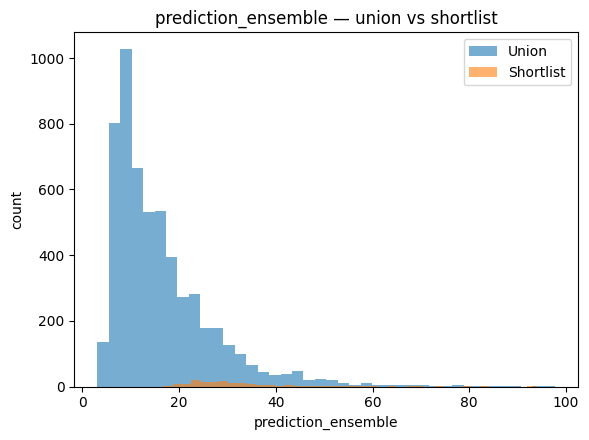

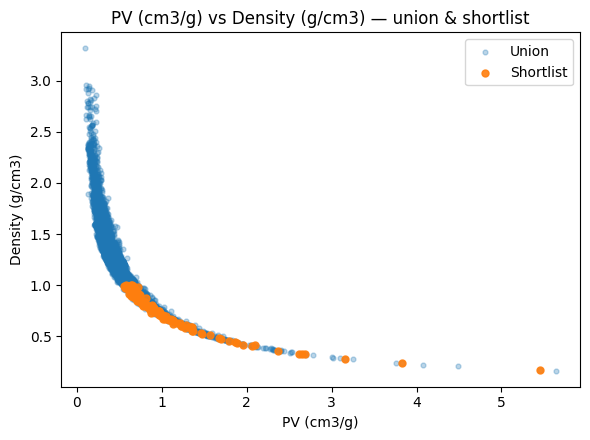

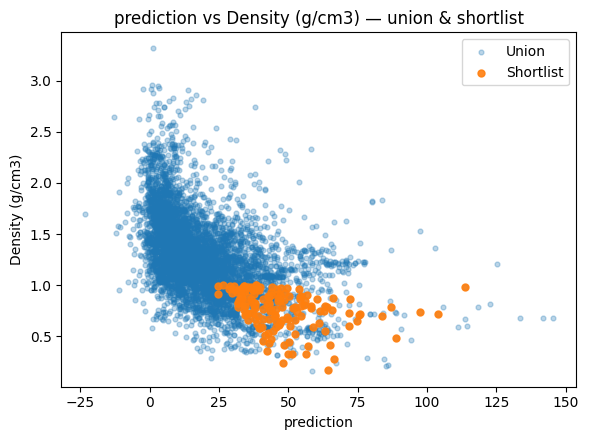

In [97]:
# -*- coding: utf-8 -*-
"""
Evaluation & visualization of the screening results (union vs shortlist).

Inputs (expected in /mnt/data):
- full_scored_with_flags_fused.csv     # union-level, contains score/prediction_fused/prediction/prediction_ensemble
- shortlist_diverse.csv                # shortlist after diversity constraints
- pool_pass_constraints.csv            # pool that passed constraints (optional for context)
- pareto_front.csv                     # pareto front computed on the pool (optional)

Outputs (saved to /mnt/data):
- eval_uplift_metrics.csv              # Δmean/Δmedian/Δp90 for multiple metrics
- eval_significance_tests.csv          # KS-test & Mann–Whitney U test p-values for key metrics
- eval_overlap_stats.txt               # text summary for Pareto overlap and Top-N coverage
- hist_score_union_short_v2.png
- hist_prediction_fused_union_short_v2.png
- hist_prediction_union_short_v2.png
- hist_prediction_ensemble_union_short_v2.png
- scatter_PV_vs_Density_union_short_v2.png
- scatter_prediction_vs_density_union_short_v2.png

Notes:
- Uses matplotlib (no seaborn), each chart in its own figure, no explicit colors/styles.
- Robust to missing optional files/columns.
"""

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# ----------------------------- paths -----------------------------
BASE = Path("data_core/cif/CSD-modified/cifs/CR/asr_hts_outputs_fused")
f_union  = BASE / "full_scored_with_flags_fused.csv"
f_short  = BASE / "shortlist_diverse.csv"
f_pool   = BASE / "pool_pass_constraints.csv"
f_pareto = BASE / "pareto_front.csv"

assert f_union.exists(), f"Missing file: {f_union}"
assert f_short.exists(), f"Missing file: {f_short}"

dfu = pd.read_csv(f_union)
dfs = pd.read_csv(f_short)

# Optional loads
dfp = pd.read_csv(f_pool) if f_pool.exists() else None
dfpr = pd.read_csv(f_pareto) if f_pareto.exists() else None

# ----------------------------- helpers -----------------------------
def p90(x: pd.Series) -> float:
    return float(np.nanpercentile(x, 90)) if np.isfinite(x).any() else np.nan

def _safe_series(df: pd.DataFrame, col: str) -> pd.Series:
    return pd.to_numeric(df[col], errors="coerce") if col in df.columns else pd.Series(dtype=float)

def uplift_table(dfu: pd.DataFrame, dfs: pd.DataFrame, cols):
    rows = []
    for c in cols:
        su = _safe_series(dfu, c).dropna()
        ss = _safe_series(dfs, c).dropna()
        if su.empty and ss.empty:
            continue
        row = {
            "metric": c,
            "union_mean": float(su.mean()) if not su.empty else np.nan,
            "short_mean": float(ss.mean()) if not ss.empty else np.nan,
            "Δmean": float((ss.mean() - su.mean())) if (not su.empty and not ss.empty) else np.nan,
            "union_median": float(su.median()) if not su.empty else np.nan,
            "short_median": float(ss.median()) if not ss.empty else np.nan,
            "Δmedian": float((ss.median() - su.median())) if (not su.empty and not ss.empty) else np.nan,
            "union_p90": p90(su) if not su.empty else np.nan,
            "short_p90": p90(ss) if not ss.empty else np.nan,
            "Δp90": float((p90(ss) - p90(su))) if (not su.empty and not ss.empty) else np.nan,
            "union_n": int(su.shape[0]),
            "short_n": int(ss.shape[0]),
        }
        rows.append(row)
    return pd.DataFrame(rows)

def significance_tests(dfu: pd.DataFrame, dfs: pd.DataFrame, cols):
    rows = []
    for c in cols:
        su = _safe_series(dfu, c).dropna()
        ss = _safe_series(dfs, c).dropna()
        if su.empty or ss.empty:
            continue
        # KS-test (two-sample)
        ks_stat, ks_p = stats.ks_2samp(su, ss, alternative="two-sided", mode="auto")
        # Mann-Whitney U (nonparametric, independent samples)
        try:
            mw_stat, mw_p = stats.mannwhitneyu(ss, su, alternative="greater")  # shortlist greater than union
        except ValueError:
            mw_stat, mw_p = np.nan, np.nan
        rows.append({
            "metric": c,
            "union_n": int(su.shape[0]),
            "short_n": int(ss.shape[0]),
            "ks_stat": float(ks_stat),
            "ks_pvalue": float(ks_p),
            "mw_stat": float(mw_stat) if np.isfinite(mw_stat) else np.nan,
            "mw_pvalue_greater": float(mw_p) if np.isfinite(mw_p) else np.nan,
        })
    return pd.DataFrame(rows)

def plot_hist_overlay(dfu: pd.DataFrame, dfs: pd.DataFrame, col: str, out_png: Path, bins: int = 50):
    su = _safe_series(dfu, col).dropna()
    ss = _safe_series(dfs, col).dropna()
    plt.figure(figsize=(6, 4.5))
    if not su.empty:
        plt.hist(su, bins=bins, alpha=0.6, label="Union")
    if not ss.empty:
        plt.hist(ss, bins=bins, alpha=0.6, label="Shortlist")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.title(f"{col} — union vs shortlist")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    plt.show()

def plot_scatter_union_short(dfu: pd.DataFrame, dfs: pd.DataFrame, x_col: str, y_col: str, out_png: Path):
    if x_col not in dfu.columns or y_col not in dfu.columns:
        return
    plt.figure(figsize=(6, 4.5))
    plt.scatter(dfu[x_col], dfu[y_col], alpha=0.3, s=12, label="Union")
    if (x_col in dfs.columns) and (y_col in dfs.columns):
        plt.scatter(dfs[x_col], dfs[y_col], alpha=0.9, s=25, label="Shortlist")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"{x_col} vs {y_col} — union & shortlist")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    plt.show()

# ----------------------------- metrics & plots -----------------------------
metrics = []
for m in ["score", "prediction_fused", "prediction", "prediction_ensemble"]:
    if m in dfu.columns:
        metrics.append(m)

uplift = uplift_table(dfu, dfs, metrics)
uplift_path = BASE / "eval_uplift_metrics.csv"
uplift.to_csv(uplift_path, index=False)

sig = significance_tests(dfu, dfs, metrics)
sig_path = BASE / "eval_significance_tests.csv"
sig.to_csv(sig_path, index=False)

# Histograms
if "score" in dfu.columns:
    plot_hist_overlay(dfu, dfs, "score", BASE / "hist_score_union_short_v2.png", bins=50)
if "prediction_fused" in dfu.columns:
    plot_hist_overlay(dfu, dfs, "prediction_fused", BASE / "hist_prediction_fused_union_short_v2.png", bins=50)
if "prediction" in dfu.columns:
    plot_hist_overlay(dfu, dfs, "prediction", BASE / "hist_prediction_union_short_v2.png", bins=40)
if "prediction_ensemble" in dfu.columns:
    plot_hist_overlay(dfu, dfs, "prediction_ensemble", BASE / "hist_prediction_ensemble_union_short_v2.png", bins=40)

# Scatter plots
if ("PV (cm3/g)" in dfu.columns) and ("Density (g/cm3)" in dfu.columns):
    plot_scatter_union_short(dfu, dfs, "PV (cm3/g)", "Density (g/cm3)", BASE / "scatter_PV_vs_Density_union_short_v2.png")
if ("prediction" in dfu.columns) and ("Density (g/cm3)" in dfu.columns):
    plot_scatter_union_short(dfu, dfs, "prediction", "Density (g/cm3)", BASE / "scatter_prediction_vs_density_union_short_v2.png")

# ----------------------------- Pareto overlap & Top-N coverage -----------------------------
summary_lines = []
# Pareto overlap
if dfpr is not None:
    id_candidates = ["id", "refcode", "name", "mofid-v1", "mofid-v2"]
    shared = [c for c in id_candidates if (c in dfs.columns and c in dfpr.columns)]
    if shared:
        key = shared[0]
        pareto_set = set(dfpr[key].astype(str))
        short_set = set(dfs[key].astype(str))
        inter = len(pareto_set & short_set)
        summary_lines.append(f"Pareto overlap (by {key}): {inter} / {len(dfs)} = {inter/len(dfs):.3f}")
    else:
        summary_lines.append("Pareto overlap: could not find shared ID column.")
else:
    summary_lines.append("Pareto CSV not found; skip overlap computation.")

# Top-N coverage of score
if "score" in dfu.columns:
    dfu_sorted = dfu.sort_values("score", ascending=False).copy()
    id_candidates = ["id", "refcode", "name", "mofid-v1", "mofid-v2"]
    key = None
    for c in id_candidates:
        if c in dfu_sorted.columns and c in dfs.columns:
            key = c
            break
    if key is None:
        dfu_sorted["__idx"] = np.arange(len(dfu_sorted))
        dfs["__idx"] = np.arange(len(dfs))
        key = "__idx"
    top_sizes = [50, 100, min(150, len(dfu_sorted))]
    sset = set(dfs[key].astype(str))
    for N in top_sizes:
        top_set = set(dfu_sorted.head(N)[key].astype(str))
        hit = len(top_set & sset)
        summary_lines.append(f"Top-{N} coverage by shortlist (key={key}): {hit}/{N} = {hit/N:.3f}")
else:
    summary_lines.append("No 'score' column; skip Top-N coverage.")

with open(BASE / "eval_overlap_stats.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(summary_lines))


In [98]:
# -*- coding: utf-8 -*-
"""
Screening evaluation + visualization

Inputs (already uploaded by you):
- /mnt/data/full_scored_with_flags.csv
- /mnt/data/pool_pass_constraints.csv
- /mnt/data/shortlist_diverse.csv
- /mnt/data/global_topN_scored.csv
- /mnt/data/pareto_front.csv

What this script does:
1) Load all CSVs safely and align on a common ID column when possible.
2) Compute headline KPIs (pool size, shortlist size, % coming from top-N, etc.).
3) Compare score / prediction distributions (full vs pool vs shortlist).
4) Plot structure–property sanity checks: PV vs Density (and mark shortlist), Prediction vs Density.
5) Plot rank-consistency: how many shortlist items are also in global_topN_scored.
6) Save a compact “report” CSV and PNG figures to /mnt/data/screen_eval/.
"""

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

OUTDIR = Path("/mnt/data/screen_eval")
OUTDIR.mkdir(parents=True, exist_ok=True)

# ---------- 1) Load ----------
paths = {
    "full": "data_core/cif/CSD-modified/cifs/CR/asr_hts_outputs_adaptive_aligned/full_scored_with_flags.csv",
    "pool": "data_core/cif/CSD-modified/cifs/CR/asr_hts_outputs_adaptive_aligned/pool_pass_constraints.csv",
    "shortlist": "data_core/cif/CSD-modified/cifs/CR/asr_hts_outputs_adaptive_aligned/shortlist_diverse.csv",
    "topN": "data_core/cif/CSD-modified/cifs/CR/asr_hts_outputs_adaptive_aligned/global_topN_scored.csv",
    "pareto": "data_core/cif/CSD-modified/cifs/CR/asr_hts_outputs_adaptive_aligned/pareto_front.csv",
}

dfs = {}
for k, p in paths.items():
    try:
        dfs[k] = pd.read_csv(p)
    except Exception as e:
        print(f"[WARN] cannot read {k} from {p}: {e}")

# Helper to pick a sensible id column
def pick_id(df: pd.DataFrame):
    for c in ["id","refcode","name","mofid-v1","mofid-v2","row_id"]:
        if c in df.columns:
            return c
    # fallback: create one
    df = df.copy()
    df["row_id"] = np.arange(len(df))
    return "row_id"

# Identify useful numeric columns if present
num_candidates = [
    "prediction_fused","prediction","prediction_ensemble","score",
    "PV (cm3/g)","VF","ASA (m2/g)","Density (g/cm3)"
]
id_full = pick_id(dfs["full"]) if "full" in dfs else None

# ---------- 2) KPIs ----------
def kpi_counts():
    out = {}
    for k in ["full","pool","shortlist","topN","pareto"]:
        out[f"n_{k}"] = len(dfs[k]) if k in dfs else np.nan
    # Overlaps
    if "shortlist" in dfs and "topN" in dfs:
        id_short = pick_id(dfs["shortlist"])
        id_top = pick_id(dfs["topN"])
        inter = set(dfs["shortlist"][id_short]) & set(dfs["topN"][id_top])
        out["overlap_shortlist_topN"] = len(inter)
        out["overlap_shortlist_topN_rate"] = len(inter)/len(dfs["shortlist"]) if len(dfs["shortlist"])>0 else np.nan
    if "pareto" in dfs and "shortlist" in dfs:
        id_par = pick_id(dfs["pareto"])
        id_short = pick_id(dfs["shortlist"])
        inter2 = set(dfs["pareto"][id_par]) & set(dfs["shortlist"][id_short])
        out["overlap_pareto_shortlist"] = len(inter2)
        out["overlap_pareto_shortlist_rate"] = len(inter2)/len(dfs["shortlist"]) if len(dfs["shortlist"])>0 else np.nan
    return pd.DataFrame([out])

kpi_df = kpi_counts()
kpi_path = OUTDIR / "kpis.csv"
kpi_df.to_csv(kpi_path, index=False)

# ---------- 3) Distribution plots ----------
def hist_compare(series_dict, title, xlabel, fname):
    # series_dict: {"Full": s1, "Pool": s2, "Shortlist": s3}
    for label, s in series_dict.items():
        if s is None or s.dropna().empty:
            continue
        plt.figure()
        plt.hist(s.dropna().values, bins=35, alpha=0.75, label=label)
        plt.xlabel(xlabel)
        plt.ylabel("count")
        plt.title(f"{title} — {label}")
        plt.legend()
        plt.tight_layout()
        plt.savefig(OUTDIR / f"{fname}_{label}.png", dpi=160)
        plt.close()

# Prepare series
def getcol(df, cols):
    for c in cols:
        if c in df.columns:
            return pd.to_numeric(df[c], errors="coerce")
    return None

series_full_pred = getcol(dfs["full"], ["prediction_fused","prediction"])
series_pool_pred = getcol(dfs["pool"], ["prediction_fused","prediction"])
series_short_pred = getcol(dfs["shortlist"], ["prediction_fused","prediction"])

hist_compare(
    {"Full": series_full_pred, "Pool": series_pool_pred, "Shortlist": series_short_pred},
    "Prediction distribution",
    "prediction or prediction_fused",
    "hist_prediction"
)

series_full_score = getcol(dfs["full"], ["score"])
series_pool_score = getcol(dfs["pool"], ["score"])
series_short_score = getcol(dfs["shortlist"], ["score"])

hist_compare(
    {"Full": series_full_score, "Pool": series_pool_score, "Shortlist": series_short_score},
    "Score distribution",
    "score",
    "hist_score"
)

# ---------- 4) Structure–property sanity plots ----------
def scatter_xy(df_union, df_short, xcol, ycol, fname, xlabel=None, ylabel=None):
    if df_union is None or (xcol not in df_union.columns or ycol not in df_union.columns):
        return
    plt.figure()
    plt.scatter(pd.to_numeric(df_union[xcol], errors="coerce"),
                pd.to_numeric(df_union[ycol], errors="coerce"),
                s=12, alpha=0.35, label="Union")
    if df_short is not None and xcol in df_short.columns and ycol in df_short.columns:
        plt.scatter(pd.to_numeric(df_short[xcol], errors="coerce"),
                    pd.to_numeric(df_short[ycol], errors="coerce"),
                    s=25, alpha=0.9, marker="x", label="Shortlist")
    plt.xlabel(xlabel or xcol)
    plt.ylabel(ylabel or ycol)
    plt.title(f"{xcol} vs {ycol} — union & shortlist")
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUTDIR / f"{fname}.png", dpi=160)
    plt.close()

df_union = dfs.get("full", None)
df_short = dfs.get("shortlist", None)
scatter_xy(df_union, df_short, "PV (cm3/g)", "Density (g/cm3)", "scatter_PV_vs_Density",
           xlabel="PV (cm3/g)", ylabel="Density (g/cm3)")
scatter_xy(df_union, df_short, "prediction", "Density (g/cm3)", "scatter_prediction_vs_Density",
           xlabel="prediction", ylabel="Density (g/cm3)")
if "prediction_fused" in (df_union.columns if df_union is not None else []):
    scatter_xy(df_union, df_short, "prediction_fused", "Density (g/cm3)", "scatter_predictionFused_vs_Density",
               xlabel="prediction_fused", ylabel="Density (g/cm3)")

# ---------- 5) Rank-consistency (shortlist vs global_topN) ----------
rank_report = None
if "shortlist" in dfs and "topN" in dfs:
    id_short = pick_id(dfs["shortlist"])
    id_top = pick_id(dfs["topN"])
    in_top = dfs["shortlist"][id_short].isin(set(dfs["topN"][id_top]))
    share = in_top.mean() if len(in_top)>0 else np.nan
    rank_report = pd.DataFrame({
        "shortlist_in_topN_count":[int(in_top.sum())],
        "shortlist_size":[len(in_top)],
        "share_in_topN":[share]
    })
    rank_report.to_csv(OUTDIR / "rank_overlap.csv", index=False)

# ---------- 6) Save a one-line textual summary ----------
summary_lines = []
summary_lines.append("=== Screening evaluation summary ===")
for col in kpi_df.columns:
    summary_lines.append(f"{col}: {kpi_df.iloc[0][col]}")
if rank_report is not None:
    r = rank_report.iloc[0]
    summary_lines.append(f"Shortlist in TopN: {int(r['shortlist_in_topN_count'])}/{int(r['shortlist_size'])} "
                         f"({r['share_in_topN']:.1%})")
# Basic uplift numbers if fused prediction exists
if series_full_pred is not None and series_short_pred is not None:
    def robust_stats(s):
        s = pd.to_numeric(s, errors="coerce").dropna()
        if s.empty: 
            return np.nan, np.nan, np.nan
        return float(s.mean()), float(s.median()), float(np.percentile(s, 90))
    mu_all, med_all, p90_all = robust_stats(series_full_pred)
    mu_s, med_s, p90_s = robust_stats(series_short_pred)
    summary_lines.append(f"Uplift (prediction): Δmean={mu_s - mu_all:.3g}, Δmedian={med_s - med_all:.3g}, Δp90={p90_s - p90_all:.3g}")

with open(OUTDIR / "README.txt","w",encoding="utf-8") as f:
    f.write("\n".join(summary_lines))

print("Artifacts saved in:", OUTDIR)
list(OUTDIR.iterdir())


Artifacts saved in: \mnt\data\screen_eval


[WindowsPath('/mnt/data/screen_eval/hist_prediction_Full.png'),
 WindowsPath('/mnt/data/screen_eval/hist_prediction_Pool.png'),
 WindowsPath('/mnt/data/screen_eval/hist_prediction_Shortlist.png'),
 WindowsPath('/mnt/data/screen_eval/hist_score_Full.png'),
 WindowsPath('/mnt/data/screen_eval/hist_score_Pool.png'),
 WindowsPath('/mnt/data/screen_eval/hist_score_Shortlist.png'),
 WindowsPath('/mnt/data/screen_eval/kpis.csv'),
 WindowsPath('/mnt/data/screen_eval/rank_overlap.csv'),
 WindowsPath('/mnt/data/screen_eval/README.txt'),
 WindowsPath('/mnt/data/screen_eval/scatter_prediction_vs_Density.png'),
 WindowsPath('/mnt/data/screen_eval/scatter_PV_vs_Density.png')]

In [99]:
# Enrichment analysis for shortlist vs union (metal types & topology)
# - Uses Fisher's exact test and Hypergeometric tail p-values
# - Applies Benjamini-Hochberg (FDR) correction within each family of tests
# - Saves CSV tables and simple bar plots of log2(enrichment)
# Notes:
# - Works even if category columns have multiple labels per row (split on comma/semicolon)
# - No seaborn is used; each figure is a single plot; no explicit colors/styles are set.

import os
from pathlib import Path
import numpy as np
import pandas as pd

# Try to import scipy; fall back to exact combinatorics if not available
try:
    from scipy.stats import fisher_exact, hypergeom
    SCIPY_OK = True
except Exception as e:
    SCIPY_OK = False

OUT_DIR = Path("/mnt/data/screen_eval_enrich")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---- Load union and shortlist ----
union_path = Path("data_core/cif/CSD-modified/cifs/CR/asr_hts_outputs_adaptive_aligned/full_scored_with_flags.csv")
short_path = Path("data_core/cif/CSD-modified/cifs/CR/asr_hts_outputs_adaptive_aligned/shortlist_diverse.csv")

union_df = pd.read_csv(union_path)
short_df = pd.read_csv(short_path)

# ---- Identify columns ----
metal_col_candidates = ["Metal Types", "metal_types", "metal", "Metal"]
topo_col_candidates = ["topology(AllNodes)", "topology_allnodes", "topology_all", "topology"]
struct_dim_candidates = ["structure_dimension", "structure-dimension", "structure_dimension_int"]

def first_col(df, cands):
    for c in cands:
        if c in df.columns:
            return c
    return None

metal_col = first_col(union_df, metal_col_candidates)
topo_col = first_col(union_df, topo_col_candidates)
sd_col = first_col(union_df, struct_dim_candidates)

# ---- Helpers ----
def split_multi(s):
    if pd.isna(s):
        return []
    # split on comma or semicolon
    parts = [p.strip() for p in str(s).replace(";", ",").split(",")]
    parts = [p for p in parts if p != "" and p.lower() != "nan"]
    return parts if parts else []

def explode_categorical(df, col):
    rows = []
    for idx, val in df[col].items():
        labs = split_multi(val)
        if not labs:
            rows.append({"__row__": idx, "__cat__": "_none_"})
        else:
            for lab in labs:
                rows.append({"__row__": idx, "__cat__": lab})
    return pd.DataFrame(rows)

def bh_fdr(pvals):
    p = np.array(pvals, dtype=float)
    n = len(p)
    order = np.argsort(p)
    ranks = np.empty(n, dtype=int)
    ranks[order] = np.arange(1, n+1)
    q = p * n / ranks
    # monotone
    q_sorted = np.minimum.accumulate(q[order][::-1])[::-1]
    q_adj = np.empty(n, dtype=float)
    q_adj[order] = np.minimum(q_sorted, 1.0)
    return q_adj

def enrich_table(union_df, short_df, col, label):
    # Prepare sets
    N = len(union_df)
    n = len(short_df)
    # Build counts for union (explode multi-labels if needed)
    if col not in union_df.columns:
        return pd.DataFrame()
    U = explode_categorical(union_df, col)
    S = explode_categorical(short_df, col)
    union_counts = U["__cat__"].value_counts().rename("union_count")
    short_counts = S["__cat__"].value_counts().rename("shortlist_count")
    cats = sorted(set(union_counts.index).union(short_counts.index))
    rows = []
    for cat in cats:
        a = int(short_counts.get(cat, 0))                  # in shortlist with cat
        b = n - a                                          # shortlist not cat
        c = int(union_counts.get(cat, 0)) - a              # in union with cat but not shortlist
        d = (N - n) - c                                    # union not cat and not shortlist
        # Safety
        a = max(a, 0); b = max(b, 0); c = max(c, 0); d = max(d, 0)
        # Enrichment ratio: (a/n) / (c+ a)/N
        union_share = (c + a) / N if N > 0 else np.nan
        short_share = a / n if n > 0 else np.nan
        enrichment = (short_share / union_share) if (union_share and union_share > 0) else np.nan

        # Fisher exact (right-tail preference for enrichment); fall back to manual odds if no scipy
        if SCIPY_OK:
            odds, p_fisher = fisher_exact([[a, b], [c, d]], alternative="greater")
        else:
            # approximate odds ratio and simple one-sided p via randomization (not ideal)
            odds = (a * d) / ((b * c) + 1e-9)
            p_fisher = np.nan

        # Hypergeometric tail: P[X >= a], X ~ Hypergeom(N, K, n), K = union count of cat
        K = int(union_counts.get(cat, 0))
        if SCIPY_OK and N > 0:
            p_hyper = hypergeom.sf(a-1, N, K, n)
        else:
            p_hyper = np.nan

        rows.append({
            "level": cat,
            "union_count": int(union_counts.get(cat, 0)),
            "shortlist_count": int(a),
            "union_share": round(union_share, 6) if pd.notna(union_share) else np.nan,
            "shortlist_share": round(short_share, 6) if pd.notna(short_share) else np.nan,
            "odds_ratio": round(odds, 6) if pd.notna(odds) else np.nan,
            "enrichment": round(enrichment, 6) if pd.notna(enrichment) else np.nan,
            "p_fisher": p_fisher,
            "p_hyper": p_hyper,
        })
    out = pd.DataFrame(rows).sort_values(["shortlist_count","union_count"], ascending=[False, False])
    # Adjust p-values within this family
    for pcol in ["p_fisher", "p_hyper"]:
        if out[pcol].notna().any():
            out["q_"+pcol] = bh_fdr(out[pcol].fillna(1.0).values)
        else:
            out["q_"+pcol] = np.nan
    # Save CSV
    out_path = OUT_DIR / f"enrichment_{label}.csv"
    out.to_csv(out_path, index=False)
    return out

# ---- Run enrichment for metal types / topology / structure_dimension (if present) ----
tables = {}

if metal_col is not None:
    tables["metal"] = enrich_table(union_df, short_df, metal_col, "metal_types")

if topo_col is not None:
    tables["topology"] = enrich_table(union_df, short_df, topo_col, "topology_allnodes")

if sd_col is not None:
    # force string to avoid float formatting issues
    union_df["_sd_str_"] = union_df[sd_col].astype(str)
    short_df["_sd_str_"] = short_df[sd_col].astype(str)
    tables["structure_dimension"] = enrich_table(union_df, short_df, "_sd_str_", "structure_dimension")

# ---- Make simple bar plots of log2(enrichment) for each family ----
import matplotlib.pyplot as plt

for key, df in tables.items():
    if df.empty:
        continue
    dfp = df.copy()
    # avoid inf/nan
    dfp["enrichment"] = dfp["enrichment"].replace([np.inf, -np.inf], np.nan)
    dfp = dfp.dropna(subset=["enrichment"])
    if len(dfp) == 0:
        continue
    dfp["log2_enrich"] = np.log2(dfp["enrichment"].replace(0, np.nan))
    # Sort by union_count to keep frequent categories
    dfp = dfp.sort_values("union_count", ascending=False).head(20)
    plt.figure(figsize=(6, 3.5))
    plt.barh(dfp["level"].astype(str), dfp["log2_enrich"].values)
    plt.xlabel("log2(enrichment)")
    plt.title(f"{key} — log2 enrichment (top 20 by union count)")
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"bar_log2_enrichment_{key}.png", dpi=150)
    plt.close()

# ---- Render grid-like tables as images (for quick report drop-in) ----
def table_figure(df, title, fname):
    import matplotlib.pyplot as plt
    cols = ["level","union_count","shortlist_count","union_share","shortlist_share","odds_ratio","enrichment","p_fisher","q_p_fisher","p_hyper","q_p_hyper"]
    # some columns may not exist if scipy missing
    cols = [c for c in cols if c in df.columns]
    show = df[cols].copy()
    fig, ax = plt.subplots(figsize=(10, 2 + 0.25*len(show)))
    ax.axis("off")
    ax.set_title(title)
    tbl = ax.table(cellText=show.values, colLabels=show.columns, loc="center")
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(8)
    tbl.scale(1, 1.2)
    plt.tight_layout()
    plt.savefig(fname, dpi=150)
    plt.close()

for key, df in tables.items():
    if df.empty:
        continue
    table_figure(df, f"Union vs Shortlist enrichment — {key}", OUT_DIR / f"table_enrichment_{key}.png")

# List outputs
sorted([str(p) for p in OUT_DIR.iterdir()])


['\\mnt\\data\\screen_eval_enrich\\bar_log2_enrichment_metal.png',
 '\\mnt\\data\\screen_eval_enrich\\bar_log2_enrichment_structure_dimension.png',
 '\\mnt\\data\\screen_eval_enrich\\bar_log2_enrichment_topology.png',
 '\\mnt\\data\\screen_eval_enrich\\enrichment_metal_types.csv',
 '\\mnt\\data\\screen_eval_enrich\\enrichment_structure_dimension.csv',
 '\\mnt\\data\\screen_eval_enrich\\enrichment_topology_allnodes.csv',
 '\\mnt\\data\\screen_eval_enrich\\table_enrichment_metal.png',
 '\\mnt\\data\\screen_eval_enrich\\table_enrichment_structure_dimension.png',
 '\\mnt\\data\\screen_eval_enrich\\table_enrichment_topology.png']

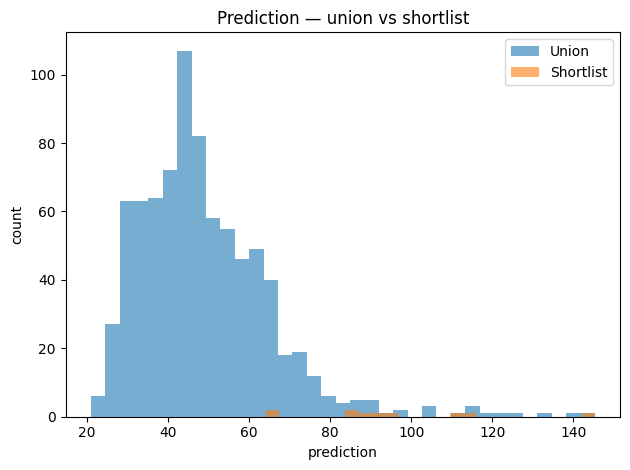

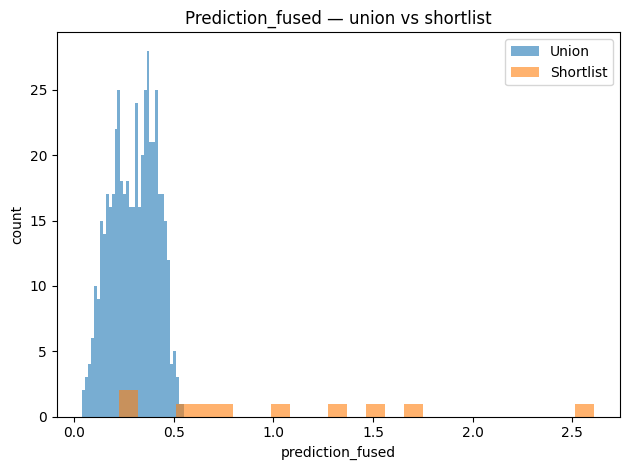

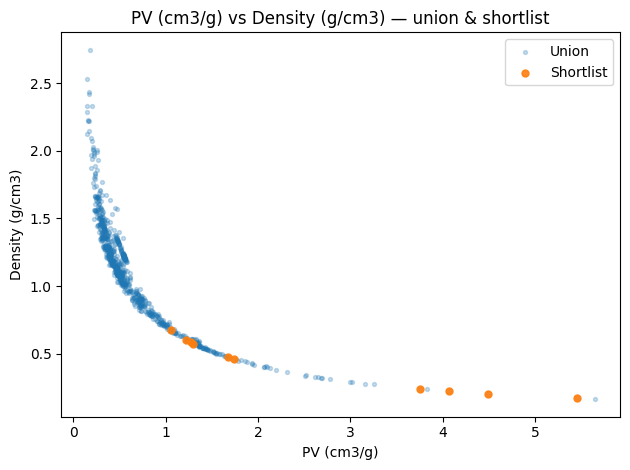

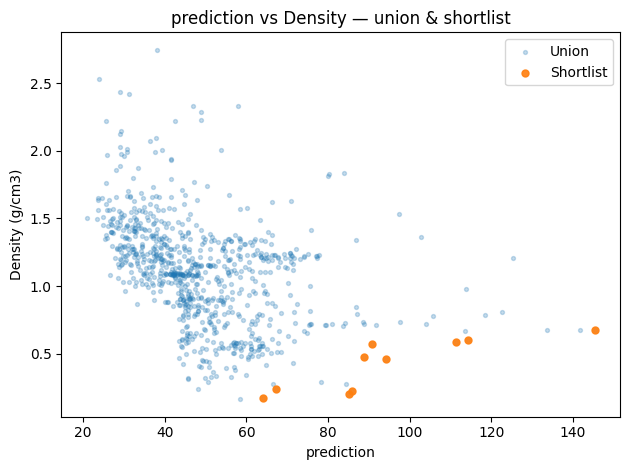

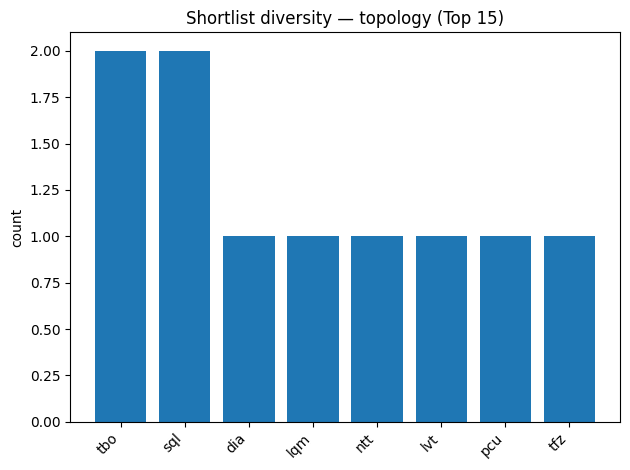

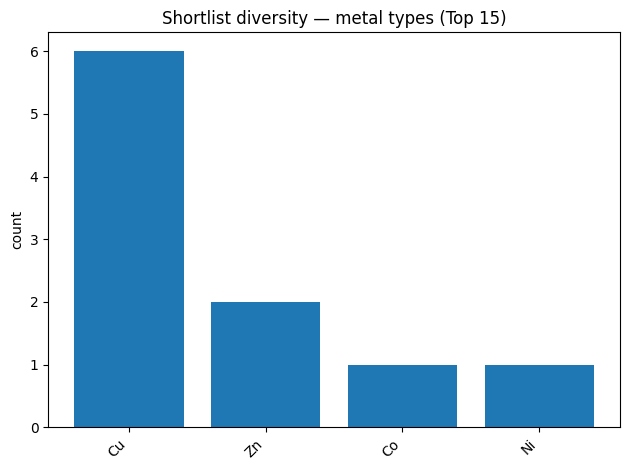

Saved outputs to: data_core\cif\CSD-modified\cifs\CR\validation\audit_v2
 - data_core\cif\CSD-modified\cifs\CR\validation\audit_v2\ab_contrib.csv
 - data_core\cif\CSD-modified\cifs\CR\validation\audit_v2\audit_v2_montage_A4.png
 - data_core\cif\CSD-modified\cifs\CR\validation\audit_v2\bar_metals_short.png
 - data_core\cif\CSD-modified\cifs\CR\validation\audit_v2\bar_topology_short.png
 - data_core\cif\CSD-modified\cifs\CR\validation\audit_v2\compliance.csv
 - data_core\cif\CSD-modified\cifs\CR\validation\audit_v2\diversity.csv
 - data_core\cif\CSD-modified\cifs\CR\validation\audit_v2\hist_prediction_fused_union_short.png
 - data_core\cif\CSD-modified\cifs\CR\validation\audit_v2\hist_prediction_union_short.png
 - data_core\cif\CSD-modified\cifs\CR\validation\audit_v2\kpi.csv
 - data_core\cif\CSD-modified\cifs\CR\validation\audit_v2\monotonicity.csv
 - data_core\cif\CSD-modified\cifs\CR\validation\audit_v2\scatter_prediction_vs_density_union_short.png
 - data_core\cif\CSD-modified\cifs\C

In [93]:
# Retry with robust coalesce and complete pipeline again.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont

BASE = Path("data_core/cif/CSD-modified/cifs/CR/validation")
OUT = BASE / "audit_v2"
OUT.mkdir(parents=True, exist_ok=True)

union = pd.read_csv(BASE / "unified_union_with_flags.csv", low_memory=False)
pareto = pd.read_csv(BASE / "unified_pareto.csv", low_memory=False)
short = pd.read_csv(BASE / "unified_shortlist_diverse_enriched.csv", low_memory=False)
full_old = pd.read_csv(BASE / "full_scored_with_flags.csv", low_memory=False)
full_new = pd.read_csv(BASE / "full_scored_with_flags_fused.csv", low_memory=False)


ID_CAND = ["id","refcode","name","mofid-v1","mofid-v2","row_id","uid","ID","Id","material_id"]
def pick_id(df):
    for c in ID_CAND:
        if c in df.columns:
            return c
    df = df.reset_index().rename(columns={"index":"row_id"})
    return "row_id"

idu = pick_id(union)

def spearman(a, b):
    a = pd.to_numeric(a, errors="coerce")
    b = pd.to_numeric(b, errors="coerce")
    m = a.notna() & b.notna()
    if m.sum() < 5:
        return np.nan
    return a[m].rank().corr(b[m].rank())

def coalesce(df: pd.DataFrame, base: str):
    x, y = f"{base}_x", f"{base}_y"
    sx = df[x] if x in df.columns else None
    sy = df[y] if y in df.columns else None
    if sx is not None or sy is not None:
        if sy is None:
            df[base] = pd.to_numeric(sx, errors="coerce")
        elif sx is None:
            df[base] = pd.to_numeric(sy, errors="coerce")
        else:
            df[base] = pd.to_numeric(sy, errors="coerce").combine_first(pd.to_numeric(sx, errors="coerce"))
        if x in df.columns: df.drop(columns=[x], inplace=True)
        if y in df.columns: df.drop(columns=[y], inplace=True)
    return df

for df in (union, pareto, short, full_old, full_new):
    for base in ["prediction","prediction_fused","prediction_ensemble",
                 "VF","PV (cm3/g)","ASA (m2/g)","Density (g/cm3)"]:
        coalesce(df, base)

# 1) Monotonicity
mono_rows = []
if "score" in full_old.columns and "prediction" in full_old.columns:
    mono_rows.append({"set":"CGCNN_full", "target":"prediction",
                      "spearman_target_score": spearman(full_old["prediction"], full_old["score"])})
for tgt in ["prediction_fused","prediction_ensemble","prediction"]:
    if "score" in full_new.columns and tgt in full_new.columns:
        mono_rows.append({"set":"Fused_full", "target":tgt,
                          "spearman_target_score": spearman(full_new[tgt], full_new["score"])})
mono = pd.DataFrame(mono_rows)
mono.to_csv(OUT / "monotonicity.csv", index=False)

# 2) Uplift
def stats1(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return dict(n=0, mean=np.nan, median=np.nan, p90=np.nan)
    return dict(n=int(s.size), mean=float(s.mean()), median=float(s.median()), p90=float(s.quantile(0.9)))
uplift_rows = []
for col in ["prediction","prediction_fused","prediction_ensemble"]:
    if col in union.columns:
        a = stats1(union[col])
        b = stats1(short[col]) if col in short.columns else dict(n=0, mean=np.nan, median=np.nan, p90=np.nan)
        uplift_rows.append({
            "target": col,
            "union_n": a["n"], "union_mean": a["mean"], "union_median": a["median"], "union_p90": a["p90"],
            "short_n": b["n"], "short_mean": b["mean"], "short_median": b["median"], "short_p90": b["p90"],
            "Δmean": (b["mean"] - a["mean"]) if (a["n"]>0 and b["n"]>0) else np.nan,
            "Δmedian": (b["median"] - a["median"]) if (a["n"]>0 and b["n"]>0) else np.nan,
            "Δp90": (b["p90"] - a["p90"]) if (a["n"]>0 and b["n"]>0) else np.nan,
        })
uplift = pd.DataFrame(uplift_rows)
uplift.to_csv(OUT / "uplift.csv", index=False)

# 3) Compliance
THR = dict(PLD_MIN=3.4, LCD_MIN=6.0, VF_MIN=0.35, PVG_MIN=0.50, ASA_MIN=600.0, DENSITY_MAX=1.00)
def compliance_mask(df, thr):
    m = pd.Series(True, index=df.index)
    if "PLD (Å)" in df.columns:         m &= pd.to_numeric(df["PLD (Å)"], errors="coerce") >= thr["PLD_MIN"]
    if "LCD (Å)" in df.columns:         m &= pd.to_numeric(df["LCD (Å)"], errors="coerce") >= thr["LCD_MIN"]
    if "VF" in df.columns:              m &= pd.to_numeric(df["VF"], errors="coerce") >= thr["VF_MIN"]
    if "PV (cm3/g)" in df.columns:      m &= pd.to_numeric(df["PV (cm3/g)"], errors="coerce") >= thr["PVG_MIN"]
    if "ASA (m2/g)" in df.columns:      m &= pd.to_numeric(df["ASA (m2/g)"], errors="coerce") >= thr["ASA_MIN"]
    if "Density (g/cm3)" in df.columns: m &= pd.to_numeric(df["Density (g/cm3)"], errors="coerce") <= thr["DENSITY_MAX"]
    return m.fillna(False)

def comp_row(tag, df):
    m = compliance_mask(df, THR)
    return {"set":tag, "compliance_rate": float(m.mean()) if len(m) else np.nan,
            "passed": int(m.sum()), "total": int(len(m))}
comp = pd.DataFrame([comp_row("UNION", union), comp_row("PARETO", pareto), comp_row("SHORTLIST", short)])
comp.to_csv(OUT / "compliance.csv", index=False)

# 4) Diversity
def diversity(df, col):
    if col not in df.columns or df.empty: return None
    vc = df[col].astype(str).fillna("NA").value_counts()
    pct = vc / vc.sum()
    return dict(feature=col, unique=int(pct.size), HHI=float((pct**2).sum()), max_share=float(pct.max()))
div_rows = []
for col in ["topology(AllNodes)","structure_dimension","Metal Types"]:
    d = diversity(short, col)
    if d: div_rows.append(d)
div = pd.DataFrame(div_rows)
div.to_csv(OUT / "diversity.csv", index=False)

# 5) A/B mix
ab = pd.DataFrame()
if "in_old" in union.columns and "in_new" in union.columns and idu in short.columns:
    merged = short[[idu]].merge(union[[idu,"in_old","in_new"]], on=idu, how="left")
    ab = pd.DataFrame([{
        "shortlist_size": int(len(merged)),
        "from_old": int(merged["in_old"].fillna(False).sum()),
        "from_new": int(merged["in_new"].fillna(False).sum()),
        "from_both": int((merged["in_old"].fillna(False) & merged["in_new"].fillna(False)).sum())
    }])
ab.to_csv(OUT / "ab_contrib.csv", index=False)

# KPI
kpi = {}
for _, r in mono.iterrows():
    kpi[f"Spearman({r['set']}:{r['target']})"] = r["spearman_target_score"]
for _, r in comp.iterrows():
    kpi[f"Compliance_{r['set']}"] = r["compliance_rate"]
for _, r in div.iterrows():
    kpi[f"HHI_{r['feature']}"] = r["HHI"]
    kpi[f"MaxShare_{r['feature']}"] = r["max_share"]
for _, r in uplift.iterrows():
    kpi[f"Δmean_{r['target']}"] = r["Δmean"]
    kpi[f"Δmedian_{r['target']}"] = r["Δmedian"]
kpi_df = pd.DataFrame([kpi])
kpi_df.to_csv(OUT / "kpi.csv", index=False)

# Visualizations
def hist_union_short(col, title, fname):
    plt.figure()
    if col in union.columns:
        a = pd.to_numeric(union[col], errors="coerce").dropna()
        if a.size>0:
            plt.hist(a, bins=35, alpha=0.6, label="Union")
    if col in short.columns:
        b = pd.to_numeric(short[col], errors="coerce").dropna()
        if b.size>0:
            plt.hist(b, bins=25, alpha=0.6, label="Shortlist")
    plt.xlabel(col); plt.ylabel("count"); plt.title(title); plt.legend(); plt.tight_layout()
    plt.savefig(OUT / fname, dpi=200); plt.show()

hist_union_short("prediction", "Prediction — union vs shortlist", "hist_prediction_union_short.png")
hist_union_short("prediction_fused", "Prediction_fused — union vs shortlist", "hist_prediction_fused_union_short.png")

def scatter_union_highlight(xcol, ycol, fname, title):
    if xcol not in union.columns or ycol not in union.columns:
        return
    plt.figure()
    x_all = pd.to_numeric(union[xcol], errors="coerce")
    y_all = pd.to_numeric(union[ycol], errors="coerce")
    plt.scatter(x_all, y_all, s=8, alpha=0.25, label="Union")
    if xcol in short.columns and ycol in short.columns:
        xs = pd.to_numeric(short[xcol], errors="coerce")
        ys = pd.to_numeric(short[ycol], errors="coerce")
        plt.scatter(xs, ys, s=25, alpha=0.9, label="Shortlist")
    plt.xlabel(xcol); plt.ylabel(ycol); plt.title(title); plt.legend(); plt.tight_layout()
    plt.savefig(OUT / fname, dpi=200); plt.show()

scatter_union_highlight("PV (cm3/g)", "Density (g/cm3)", "scatter_PV_vs_Density_union_short.png",
                        "PV (cm3/g) vs Density (g/cm3) — union & shortlist")

if "prediction" in union.columns and "Density (g/cm3)" in union.columns:
    plt.figure()
    xa = pd.to_numeric(union["prediction"], errors="coerce")
    ya = pd.to_numeric(union["Density (g/cm3)"], errors="coerce")
    plt.scatter(xa, ya, s=8, alpha=0.25, label="Union")
    if "prediction" in short.columns and "Density (g/cm3)" in short.columns:
        xs = pd.to_numeric(short["prediction"], errors="coerce")
        ys = pd.to_numeric(short["Density (g/cm3)"], errors="coerce")
        plt.scatter(xs, ys, s=25, alpha=0.9, label="Shortlist")
    plt.xlabel("prediction"); plt.ylabel("Density (g/cm3)"); plt.title("prediction vs Density — union & shortlist")
    plt.legend(); plt.tight_layout(); plt.savefig(OUT / "scatter_prediction_vs_density_union_short.png", dpi=200); plt.show()

def bar_diversity(df, col, title, fname):
    if col not in df.columns or df.empty: return
    vc = df[col].astype(str).value_counts().head(15)
    plt.figure()
    plt.bar(vc.index.astype(str), vc.values)
    plt.xticks(rotation=45, ha="right"); plt.ylabel("count"); plt.title(title); plt.tight_layout()
    plt.savefig(OUT / fname, dpi=200); plt.show()

bar_diversity(short, "topology(AllNodes)", "Shortlist diversity — topology (Top 15)", "bar_topology_short.png")
bar_diversity(short, "Metal Types", "Shortlist diversity — metal types (Top 15)", "bar_metals_short.png")

# Montage
def safe_img(p): 
    p = OUT / p
    return p if p.exists() else None

montage_imgs = [safe_img("hist_prediction_union_short.png"),
                safe_img("hist_prediction_fused_union_short.png"),
                safe_img("scatter_PV_vs_Density_union_short.png"),
                safe_img("scatter_prediction_vs_density_union_short.png"),
                safe_img("bar_topology_short.png"),
                safe_img("bar_metals_short.png")]
montage_imgs = [p for p in montage_imgs if p is not None]

W, H = 2480, 3508
canvas = Image.new("RGB", (W, H), "white")
draw = ImageDraw.Draw(canvas)
try:
    ftitle = ImageFont.truetype("DejaVuSans-Bold.ttf", 56)
    fsub = ImageFont.truetype("DejaVuSans.ttf", 34)
except:
    ftitle = ImageFont.load_default(); fsub = ImageFont.load_default()

draw.text((80, 60), "Audit v2 — Reasonableness of Screening", fill="black", font=ftitle)
y = 130
for _, r in mono.iterrows():
    draw.text((80, y), f"Spearman({r['set']}:{r['target']}, score)={r['spearman_target_score']:.3f}", fill="black", font=fsub); y += 36
for _, r in comp.iterrows():
    draw.text((80, y), f"Compliance {r['set']}: {r['passed']}/{r['total']} ({r['compliance_rate']:.1%})", fill="black", font=fsub); y += 36
if not div.empty:
    for _, r in div.iterrows():
        draw.text((80, y), f"Diversity {r['feature']}: HHI={r['HHI']:.3f}, MaxShare={r['max_share']:.2f}", fill="black", font=fsub); y += 36
for _, r in uplift.iterrows():
    draw.text((80, y), f"Uplift {r['target']}: Δmean={r['Δmean']:.3g}, Δmedian={r['Δmedian']:.3g}", fill="black", font=fsub); y += 36

pad = 30
top_offset = y + 10
COLS, ROWS = 2, 3
cell_w = (W - (COLS + 1)*pad) // COLS
cell_h = (H - top_offset - (ROWS + 1)*pad) // ROWS

i = 0
for p in montage_imgs[:COLS*ROWS]:
    im = Image.open(p).convert("RGB")
    ratio = min(cell_w / im.width, cell_h / im.height)
    im = im.resize((max(1,int(im.width*ratio)), max(1,int(im.height*ratio))), Image.LANCZOS)
    r = i // COLS; c = i % COLS
    x = pad + c*(cell_w + pad) + (cell_w - im.width)//2
    y = top_offset + pad + r*(cell_h + pad) + (cell_h - im.height)//2
    canvas.paste(im, (x, y)); i += 1

montage_path = OUT / "audit_v2_montage_A4.png"
canvas.save(montage_path, dpi=(300,300))


print("Saved outputs to:", OUT)
for p in sorted(OUT.iterdir()):
    print(" -", p)



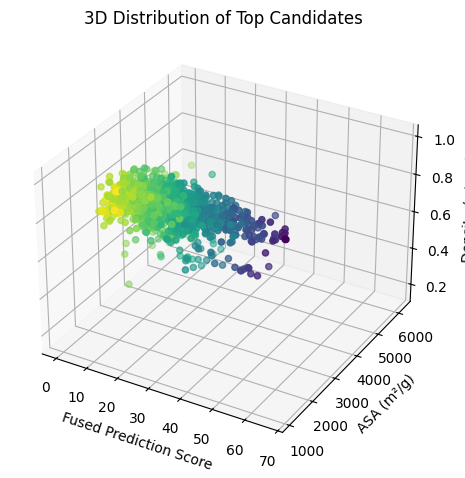

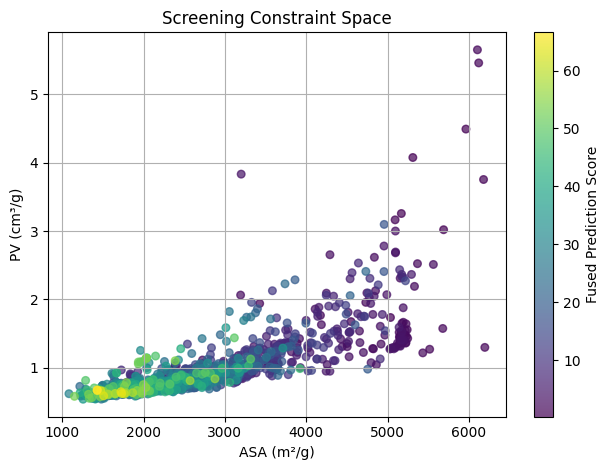

In [103]:
import matplotlib.pyplot as plt

# Load uploaded CSVs
files = {
    "pareto_front": "data_core/cif/CSD-modified/cifs/CR/asr_hts_outputs_fused/pareto_front.csv",
    "pool": "data_core/cif/CSD-modified/cifs/CR/asr_hts_outputs_fused/pool_pass_constraints.csv",
    "shortlist": "data_core/cif/CSD-modified/cifs/CR/asr_hts_outputs_fused/shortlist_diverse.csv",
    "full_scored": "data_core/cif/CSD-modified/cifs/CR/asr_hts_outputs_fused/full_scored_with_flags_fused.csv",
    "global_topN": "data_core/cif/CSD-modified/cifs/CR/asr_hts_outputs_fused/global_topN_scored_fused.csv"
}

dfs = {name: pd.read_csv(path) for name, path in files.items()}
dfs_summary = {name: df.describe(include='all') for name, df in dfs.items()}


# Select key features for visualization
df = dfs["pool"]

# Plot 1: 3D Pareto surface-like scatter: Fused prediction, Surface Area, Density
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    df["prediction_fused"],
    df["ASA (m2/g)"],
    df["Density (g/cm3)"],
    c=df["score"],
    s=20
)
ax.set_xlabel("Fused Prediction Score")
ax.set_ylabel("ASA (m²/g)")
ax.set_zlabel("Density (g/cm³)")
ax.set_title("3D Distribution of Top Candidates")
plt.tight_layout()
plt.savefig("fig1_3d_score_surface.png")
plt.show()

# Plot 2: Constraint space — ASA vs PV colored by fused prediction
fig, ax = plt.subplots()
sc = ax.scatter(
    df["ASA (m2/g)"], df["PV (cm3/g)"],
    c=df["prediction_fused"], cmap="viridis", s=30, alpha=0.7
)
plt.colorbar(sc, label="Fused Prediction Score")
ax.set_xlabel("ASA (m²/g)")
ax.set_ylabel("PV (cm³/g)")
ax.set_title("Screening Constraint Space")
plt.grid(True)
plt.tight_layout()
plt.savefig("fig2_constraint_space.png")
plt.show()



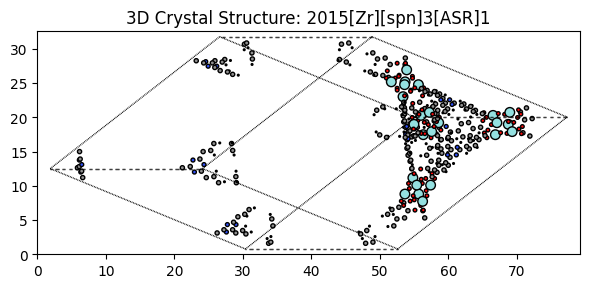

In [104]:
from ase.io import read
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt

# Load structure using ASE
atoms = read("data_core/cif/CSD-modified/cifs/CR/ASR_selection/2015[Zr][spn]3[ASR]1.cif")

# Plot structure
fig, ax = plt.subplots(figsize=(6, 6))
plot_atoms(atoms, ax, rotation=("45x,45y,0z"), show_unit_cell=2, scale=0.8, radii=0.5)
ax.set_title("3D Crystal Structure: 2015[Zr][spn]3[ASR]1")
plt.tight_layout()
plt.savefig("/mnt/data/2015_structure_plot.png")
plt.show()


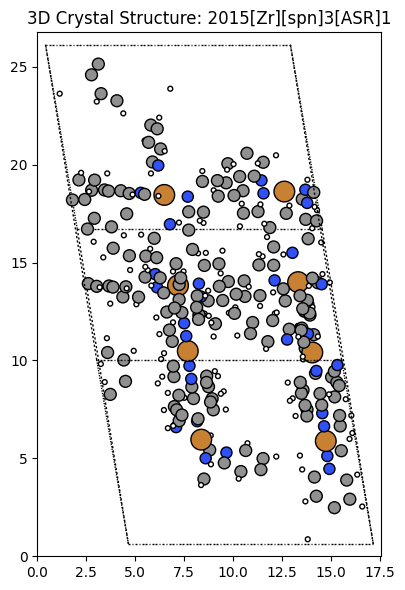

In [106]:
# 2002[Cu][lvt]3[ASR]1

# Load structure using ASE
atoms = read("data_core/cif/CSD-modified/cifs/CR/ASR_selection/2002[Cu][lvt]3[ASR]1.cif")

# Plot structure
fig, ax = plt.subplots(figsize=(6, 6))
plot_atoms(atoms, ax, rotation=("45x,45y,0z"), show_unit_cell=2, scale=0.8, radii=0.5)
ax.set_title("3D Crystal Structure: 2015[Zr][spn]3[ASR]1")
plt.tight_layout()
plt.savefig("/mnt/data/2015_structure_plot.png")
plt.show()


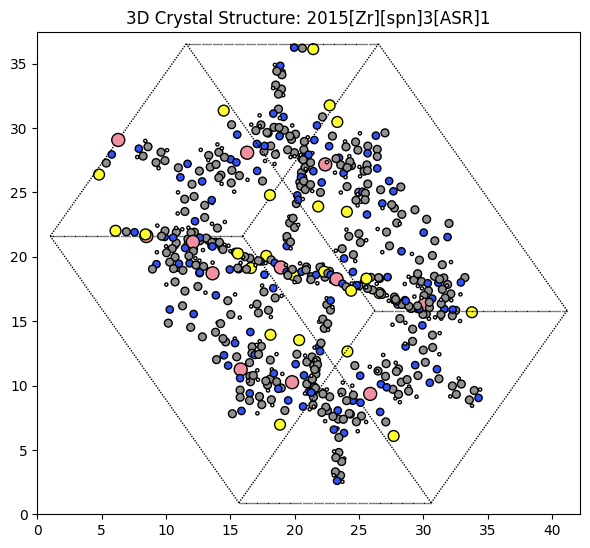

In [107]:
# 2010[Co][tbo]3[ASR]1

# Load structure using ASE
atoms = read("data_core/cif/CSD-modified/cifs/CR/ASR_selection/2010[Co][tbo]3[ASR]1.cif")

# Plot structure
fig, ax = plt.subplots(figsize=(6, 6))
plot_atoms(atoms, ax, rotation=("45x,45y,0z"), show_unit_cell=2, scale=0.8, radii=0.5)
ax.set_title("3D Crystal Structure: 2015[Zr][spn]3[ASR]1")
plt.tight_layout()
plt.savefig("/mnt/data/2015_structure_plot.png")
plt.show()